<a href="https://colab.research.google.com/github/abcd334/Quantifying-Reflexivity-A-Quantitative-Early-Warning-Model-for-Aave-Ethena./blob/main/Quantitative%20Early%20Warning%20Model%20for%20Aave%20%26%20Ethena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantifying Reflexivity: A Quantitative Early Warning Model for Aave & Ethena**

The full version of this report is also published on Medium for an enhanced online reading experience:

## **[Medium](https://medium.com/@abcd334/quantifying-reflexivity-a-quantitative-early-warning-model-for-aave-ethena-c83a3ebc4285)**

# TL;DR｜Is the Real Risk for Aave × Ethena Driven by Market Momentum?
This report presents a data-driven proof-of-concept (PoC) model that explores how to add a forward-looking, momentum-based early-warning layer on top of Aave’s existing robust risk framework.

> ***USDe minting and redemption behaviors are strongly dependent on ETH/BTC price momentum and deviation levels.***

## **🎯 Finding 1: Trend Dominates**
The variable ETH_price_gapis the most direct driver of capital flows, but ETH_price_lag15(the mid-term trend context) ranks highest in overall importance within our warning model, forming the cornerstone of risk assessment.

## **🎯 Finding 2: Nonlinear Risk**
The market is not simply “the higher it goes, the more dangerous it becomes.” Data shows that redemption pressure peaks during phases of moderate but rapid price increases, rather than at the euphoric market tops.

## **🎯 Finding 3: Demonstrated Effectiveness**
Our multi-factor warning model, by sacrificing some precision at the threshold level, successfully captured 85% of historical stress events (Recall = 0.85), validating the feasibility of this approach.

## **🎯Core Value**
The value of this study lies in offering an objective early-warning prototype. A DAO could explore using such tools as decision-support references to achieve sharper and more adaptive risk governance.

## [**🎯Explore the real-time dashboard: USDe Collapse Risk Monitor**](https://dune.com/haysen/usde-collapse-risk)

# 📖 Introduction｜From Risk Control Gaps to Early Warning Systems

## 📜 Background: Review of USDe and Aave Stability Proposals
Since late 2024, the rapid rise of Ethena Protocol and its sUSDe product has driven aggressive expansion of USDe as an overcollateralized stablecoin. Its deep integration with the Aave protocol has drawn significant attention from DAO governance.

The recent proposal by [ChaosLabs, “Strengthening Stability Between Aave and Ethena: Redemption Priority and Protocol Safeguards,”](https://governance.aave.com/t/strengthening-stability-between-aave-and-ethena-redemption-priority-and-protocol-safeguards/23027) centers on strengthening systemic defenses through reserve management, liquidation priority, and minting logic. However, current governance discussions largely focus on internal protocol mechanisms, while lacking quantitative insights and early-warning triggers related to external market-driven risks.


## ❓ Problem Statement: The Quantitative Blind Spot of “When Risk Is Triggered”
Despite multiple community discussions on reserve design and sUSDe redemption priority, one critical question remains unresolved:

> ***Under what market conditions will systemic risk in USDe be triggered?***

Most risk frameworks rely on static parameters and ex-post reviews, lacking the ability to proactively respond to market volatility. Thus, building a real-time, market-signal-based Early Warning System (EWS) is essential to fill this strategic governance gap.

## 🔗 Analytical Continuation: Bridging Prior Qualitative Insights with This Study
This report builds upon key observations made in the earlier article [“Deconstructing the Aave & Ethena Risk Report: A Case Study in DeFi Systemic Risk and Governance.”](https://medium.com/@abcd334/deconstructing-the-aave-ethena-risk-report-a-case-study-in-defi-systemic-risk-and-governance-47f132e528a4) That prior research highlighted a structural gap in protocol governance: an overemphasis on liquidation mechanics, reserve design, and asset structures, with insufficient attention to quantifying risk-trigger points or building live data-monitoring frameworks.

The objective of this report is to move from qualitative reasoning to quantitative modeling. By integrating historical transaction data, price momentum metrics, and protocol-level variables, we employ multivariate regression, Granger causality tests, and logistic prediction models to construct a market-signal-driven early warning system. This framework is intended to serve DAO governance as a decision-support tool when adjusting parameters like LTV ratios, liquidation thresholds, or minting cadence — enabling a shift from reactive risk control to proactive, flexible risk governance.

# 🗄️ Data Loading and Preprocessing

This section constitutes the data infrastructure phase of the project. The primary objective is to load, clean, and merge data from three independent sources to create a unified Master Dataset ready for analysis.

This process involves the following key steps:

1.  **Loading Three Core Data Sources:**
    * **sUSDe APY (`df_susde`):** Reading the daily historical APY/APR of sUSDe from an Excel file. This is a crucial indicator for measuring the profitability of the Ethena protocol.
    * **USDe Net Mint Volume (`df_usde`):** Reading the daily net minting/redemption volume and total supply of USDe from a CSV file. This serves as the core target variable for this study, reflecting the net inflow or outflow of market capital.
    * **Aave Interest Rates (`df_aave`):** Reading and parsing the daily average borrowing and lending rates for major assets (such as USDC, USDT) on the Aave protocol from a nested JSON file.

2.  **Data Cleaning and Standardization:**
    * Standardizing the time fields from all data sources into a uniform `YYYY-MM-DD` date format to facilitate subsequent merging.
    * Renaming the columns of each dataset by adding prefixes (e.g., `sUSDe_`, `USDe_`) to improve readability and prevent column name conflicts.

3.  **Data Merging and Filtering:**
    * Performing an inner join on the three DataFrames using the "date" as the common key to create a master DataFrame that includes all variables.
    * Based on analytical requirements, the merged data is further filtered and segmented into four key market pathways (e.g., `usdc_borrow`, `usdc_supply`), preparing it for subsequent correlation analysis and model building.

Upon completion of this phase, we will have a clean, aligned, and structured time-series dataset that will serve as the foundation for all subsequent analyses.

In [1]:
load_folder = "load_folder" # @param {"type":"string"}
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/Colab_Notebooks/Web3專案 - AAVE與Ethena「反身性」的強度/'

Mounted at /content/drive


In [2]:
import pandas as pd

# 讀取 Excel（如果有多個 Sheet，可加參數 sheet_name）
df_susde = pd.read_excel(file_path + 'sUSDe APY.xlsx')
df_susde['date'] = pd.to_datetime(df_susde['block_time']).dt.date
df_susde = df_susde.rename(columns={
    'apr': 'sUSDe_apr',
    'apy': 'sUSDe_apy'
})
print(df_susde.head())

print("\n")

df_usde = pd.read_csv(file_path + 'USDe 日淨鑄造與總供應.csv', encoding='utf-8')
df_usde['date'] = pd.to_datetime(df_usde['DAY'], format='%Y-%m-%d %H:%M:%S.%f').dt.date
df_usde = df_usde.rename(columns={
    'NET_MINT': 'USDe_NET_MINT',
    'TOTAL_SUPPLY': 'USDe_TOTAL_SUPPLY'
})
print(df_usde.head())

   sUSDe_apr  sUSDe_apy          block_time        date
0  10.747889  11.344974 2025-09-01 00:02:00  2025-09-01
1  10.749316  11.346562 2025-08-31 00:51:00  2025-08-31
2  10.762698  11.361460 2025-08-30 00:05:00  2025-08-30
3   9.776121  10.268501 2025-08-29 01:01:00  2025-08-29
4   9.613947  10.089867 2025-08-28 00:02:00  2025-08-28


                       DAY  USDe_NET_MINT  USDe_TOTAL_SUPPLY        date
0  2023-11-20 00:00:00.000  130901.204309      130901.204309  2023-11-20
1  2023-11-21 00:00:00.000  102639.049483      233540.253792  2023-11-21
2  2023-11-22 00:00:00.000       0.000000      233540.253792  2023-11-22
3  2023-11-23 00:00:00.000       0.000000      233540.253792  2023-11-23
4  2023-11-24 00:00:00.000     193.504331      233733.758123  2023-11-24


In [3]:
import json


# aave_rate_df = pd.read_json(file_path + 'Aave 日利率.json', lines=True)

with open(file_path + 'Aave 日利率.json', 'r', encoding='utf-8') as f:
    json_str = f.read()


# 解析 JSON
parsed = json.loads(json_str)

# Step 3：自動解析 key，支援 Borrow / Supply
records = []
for key in parsed['data']:
    if key.endswith('BorrowDay'):
        token = key[:-9].upper()
        action = 'Borrow'
        for item in parsed['data'][key]:
            records.append({
                'Token': token,
                'AAVE Action': action,
                'date': item['date'][:10],
                'AAVE avgRate': float(item['avgRate']['value'])
            })
    elif key.endswith('SupplyDay'):
        token = key[:-9].upper()
        action = 'Supply'
        for item in parsed['data'][key]:
            records.append({
                'Token': token,
                'AAVE Action': action,
                'date': item['date'][:10],
                'AAVE avgRate': float(item['avgRate']['value'])
            })

# Step 4：組成 DataFrame
df_aave = pd.DataFrame(records)
df_aave['date'] = pd.to_datetime(df_aave['date']).dt.date
# 顯示結果
print(df_aave.head(),"\n")
print("Token 種類數：", df_aave['Token'].nunique())
print("Action 種類數：", df_aave['AAVE Action'].nunique())
print("日期筆數：", df_aave['date'].nunique())
print("總筆數：", len(df_aave),"\n")
print(df_aave.groupby(['Token', 'AAVE Action']).size())

  Token AAVE Action        date  AAVE avgRate
0  USDC      Borrow  2025-09-01      0.055049
1  USDC      Borrow  2025-08-31      0.055049
2  USDC      Borrow  2025-08-30      0.058799
3  USDC      Borrow  2025-08-29      0.056815
4  USDC      Borrow  2025-08-28      0.060991 

Token 種類數： 2
Action 種類數： 2
日期筆數： 365
總筆數： 1460 

Token  AAVE Action
USDC   Borrow         365
       Supply         365
USDT   Borrow         365
       Supply         365
dtype: int64


In [4]:
print(df_susde.head())
print(df_usde.head())
print(df_aave.head())

   sUSDe_apr  sUSDe_apy          block_time        date
0  10.747889  11.344974 2025-09-01 00:02:00  2025-09-01
1  10.749316  11.346562 2025-08-31 00:51:00  2025-08-31
2  10.762698  11.361460 2025-08-30 00:05:00  2025-08-30
3   9.776121  10.268501 2025-08-29 01:01:00  2025-08-29
4   9.613947  10.089867 2025-08-28 00:02:00  2025-08-28
                       DAY  USDe_NET_MINT  USDe_TOTAL_SUPPLY        date
0  2023-11-20 00:00:00.000  130901.204309      130901.204309  2023-11-20
1  2023-11-21 00:00:00.000  102639.049483      233540.253792  2023-11-21
2  2023-11-22 00:00:00.000       0.000000      233540.253792  2023-11-22
3  2023-11-23 00:00:00.000       0.000000      233540.253792  2023-11-23
4  2023-11-24 00:00:00.000     193.504331      233733.758123  2023-11-24
  Token AAVE Action        date  AAVE avgRate
0  USDC      Borrow  2025-09-01      0.055049
1  USDC      Borrow  2025-08-31      0.055049
2  USDC      Borrow  2025-08-30      0.058799
3  USDC      Borrow  2025-08-29      0.056

In [5]:
# 先合併 sUSDe_apy 與 USDe 鑄造量
merged = pd.merge(df_susde, df_usde, on='date', how='inner')

# 再合併 AAVE 日利率資料
merged = pd.merge(merged, df_aave, on='date', how='inner')

merged.drop(columns=['DAY','block_time'], inplace=True)

print(merged.head())

   sUSDe_apr  sUSDe_apy        date  USDe_NET_MINT  USDe_TOTAL_SUPPLY Token  \
0  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDC   
1  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDC   
2  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDT   
3  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDT   
4  10.749316  11.346562  2025-08-31   1.814211e+07       1.234136e+10  USDC   

  AAVE Action  AAVE avgRate  
0      Borrow      0.055049  
1      Supply      0.039127  
2      Borrow      0.054631  
3      Supply      0.037814  
4      Borrow      0.055049  


In [6]:
print("sUSDe 日期範圍：", df_susde['date'].min(), "~", df_susde['date'].max())
print("USDe 日期範圍：", df_usde['date'].min(), "~", df_usde['date'].max())
print("AAVE 日期範圍：", df_aave['date'].min(), "~", df_aave['date'].max())


sUSDe 日期範圍： 2024-09-02 ~ 2025-09-01
USDe 日期範圍： 2023-11-20 ~ 2025-09-01
AAVE 日期範圍： 2024-09-02 ~ 2025-09-01


# 🧲 Correlation Analysis: Do Aave Rates Drive USDe Minting?
**Data Range: Initially 2024/9/1–2025/9/1, with focused validation on 2025/1/1–9/1**

## 💡 Initial Hypothesis: Are Aave Rates Key Decision Factors?

We began with the intuitive hypothesis that the borrowing and lending rates on the Aave protocol (`AAVE avgRate`) might influence user behavior in minting or redeeming USDe on Ethena. In theory, rising borrowing costs or falling deposit returns should discourage minting due to narrower arbitrage margins.

To validate this, we segmented the dataset into four transaction types by stablecoin (USDC/USDT) and action (Borrow/Supply), and calculated the Pearson correlation between `AAVE avgRate` and `USDe_NET_MINT` in each group. We also incorporated lag-based correlation to detect delayed effects.

To reduce noise from early protocol behavior, we narrowed the analysis to **2025/1/1–9/1**, isolating periods of more stable user engagement and market conditions.

## 🚫 Results: Very Weak Correlation

Across all groups and both timeframes, correlation values were consistently low (typically **0.04 to 0.15**) and statistically insignificant. This invalidates our initial hypothesis: **Aave interest rates are not a significant driver of USDe minting behavior.**

## 🔄 Interpretation and Research Pivot

This negative finding points to a more important insight:  
The surge in USDe minting was not driven by interest-rate arbitrage within Aave, but rather by **the perceived near risk-free arbitrage opportunity** created by the Ethena × Aave integration. With ETH entering a strong bull trend in 2025, the primary risk (price crash) seemed remote, encouraging aggressive minting.

This insight shifted our modeling focus from protocol parameters to **external market momentum**, such as ETH/BTC price trends, which became central to our predictive framework.


In [7]:
# 篩出四種組合
usdc_borrow = merged[(merged['Token'] == 'USDC') & (merged['AAVE Action'] == 'Borrow')]
usdc_supply = merged[(merged['Token'] == 'USDC') & (merged['AAVE Action'] == 'Supply')]
usdt_borrow = merged[(merged['Token'] == 'USDT') & (merged['AAVE Action'] == 'Borrow')]
usdt_supply = merged[(merged['Token'] == 'USDT') & (merged['AAVE Action'] == 'Supply')]

print(len(usdc_borrow), len(usdc_supply), len(usdt_borrow), len(usdt_supply))

365 365 365 365


In [8]:
groups = {
    'USDC - Borrow': usdc_borrow,
    'USDC - Supply': usdc_supply,
    'USDT - Borrow': usdt_borrow,
    'USDT - Supply': usdt_supply,
}

desired_order = ['USDe_NET_MINT', 'USDe_TOTAL_SUPPLY', 'sUSDe_apr', 'sUSDe_apy', 'AAVE avgRate']

# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== {name} ===")
    corr_matrix = df.corr(numeric_only=True)
    corr_matrix = corr_matrix.reindex(index=desired_order, columns=desired_order)
    print(corr_matrix, "\n")


=== USDC - Borrow ===
                   USDe_NET_MINT  USDe_TOTAL_SUPPLY  sUSDe_apr  sUSDe_apy  \
USDe_NET_MINT           1.000000           0.345464   0.250283   0.248943   
USDe_TOTAL_SUPPLY       0.345464           1.000000  -0.048918  -0.052703   
sUSDe_apr               0.250283          -0.048918   1.000000   0.999477   
sUSDe_apy               0.248943          -0.052703   0.999477   1.000000   
AAVE avgRate            0.037617          -0.000516   0.735974   0.734189   

                   AAVE avgRate  
USDe_NET_MINT          0.037617  
USDe_TOTAL_SUPPLY     -0.000516  
sUSDe_apr              0.735974  
sUSDe_apy              0.734189  
AAVE avgRate           1.000000   

=== USDC - Supply ===
                   USDe_NET_MINT  USDe_TOTAL_SUPPLY  sUSDe_apr  sUSDe_apy  \
USDe_NET_MINT           1.000000           0.345464   0.250283   0.248943   
USDe_TOTAL_SUPPLY       0.345464           1.000000  -0.048918  -0.052703   
sUSDe_apr               0.250283          -0.048918   1.

In [9]:
import pandas as pd

groups = {
    'USDC - Borrow': usdc_borrow,
    'USDC - Supply': usdc_supply,
    'USDT - Borrow': usdt_borrow,
    'USDT - Supply': usdt_supply,
}

def compute_lag_correlations(df, x_col, y_col, max_lag=7):
    """
    計算 y_col 對 x_col 的延遲相關係數
    y_col: 目標變數（例如 USDe_NET_MINT）
    x_col: 解釋變數（例如 AAVE avgRate）
    max_lag: 最大延遲天數（正數代表 y 落後 x）
    """
    results = []

    for lag in range(-max_lag, max_lag + 1):
        shifted = df[[x_col, y_col]].copy()
        shifted[y_col] = shifted[y_col].shift(-lag)  # shift 負號代表 y 落後 x
        corr = shifted.corr().iloc[0, 1]
        results.append({'lag': lag, 'correlation': corr})

    return pd.DataFrame(results)

# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== {name} ===")

    # 範例：計算 USDC Borrow 資料中的 lag correlation
    usdc_borrow_lag_corr = compute_lag_correlations(
        df,
        x_col='AAVE avgRate',
        y_col='USDe_NET_MINT',
        max_lag=7
    )

    # 顯示結果
    print(usdc_borrow_lag_corr, "\n")


=== USDC - Borrow ===
    lag  correlation
0    -7    -0.015907
1    -6    -0.003365
2    -5     0.019819
3    -4     0.011056
4    -3     0.000660
5    -2     0.039074
6    -1     0.075865
7     0     0.037617
8     1     0.070882
9     2     0.126850
10    3     0.068896
11    4     0.078761
12    5     0.145953
13    6     0.110391
14    7     0.089237 

=== USDC - Supply ===
    lag  correlation
0    -7     0.041706
1    -6     0.052478
2    -5     0.074069
3    -4     0.068110
4    -3     0.054859
5    -2     0.092703
6    -1     0.129492
7     0     0.091481
8     1     0.124470
9     2     0.182244
10    3     0.126272
11    4     0.133509
12    5     0.198211
13    6     0.163824
14    7     0.140208 

=== USDT - Borrow ===
    lag  correlation
0    -7    -0.007806
1    -6     0.013263
2    -5     0.041301
3    -4     0.038151
4    -3     0.025833
5    -2     0.048859
6    -1     0.083373
7     0     0.081877
8     1     0.089348
9     2     0.150262
10    3     0.120129
11    

In [10]:
# usdc_borrow = merged[(merged['Token'] == 'USDC') & (merged['AAVE Action'] == 'Borrow')]
# usdc_supply = merged[(merged['Token'] == 'USDC') & (merged['AAVE Action'] == 'Supply')]
# usdt_borrow = merged[(merged['Token'] == 'USDT') & (merged['AAVE Action'] == 'Borrow')]
# usdt_supply = merged[(merged['Token'] == 'USDT') & (merged['AAVE Action'] == 'Supply')]
print(usdc_borrow.head())

    sUSDe_apr  sUSDe_apy        date  USDe_NET_MINT  USDe_TOTAL_SUPPLY Token  \
0   10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDC   
4   10.749316  11.346562  2025-08-31   1.814211e+07       1.234136e+10  USDC   
8   10.762698  11.361460  2025-08-30   2.449156e+07       1.232322e+10  USDC   
12   9.776121  10.268501  2025-08-29   2.342171e+07       1.229873e+10  USDC   
16   9.613947  10.089867  2025-08-28   4.555285e+07       1.227530e+10  USDC   

   AAVE Action  AAVE avgRate  
0       Borrow      0.055049  
4       Borrow      0.055049  
8       Borrow      0.058799  
12      Borrow      0.056815  
16      Borrow      0.060991  


正在繪製圖表一：USDe Net Mint...
圖表一已儲存為 usde_net_mint.png

正在繪製圖表二：sUSDe APR & APY...
圖表二已儲存為 susde_rates.png

正在繪製圖表三：AAVE Average Rate...
圖表三已儲存為 aave_avg_rate.png


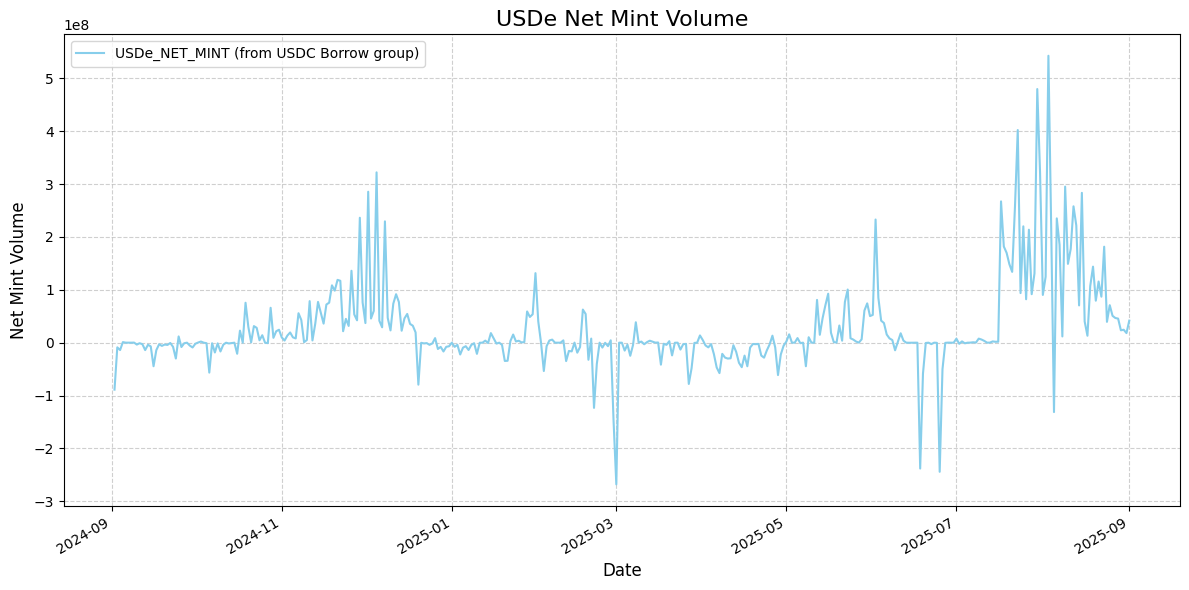

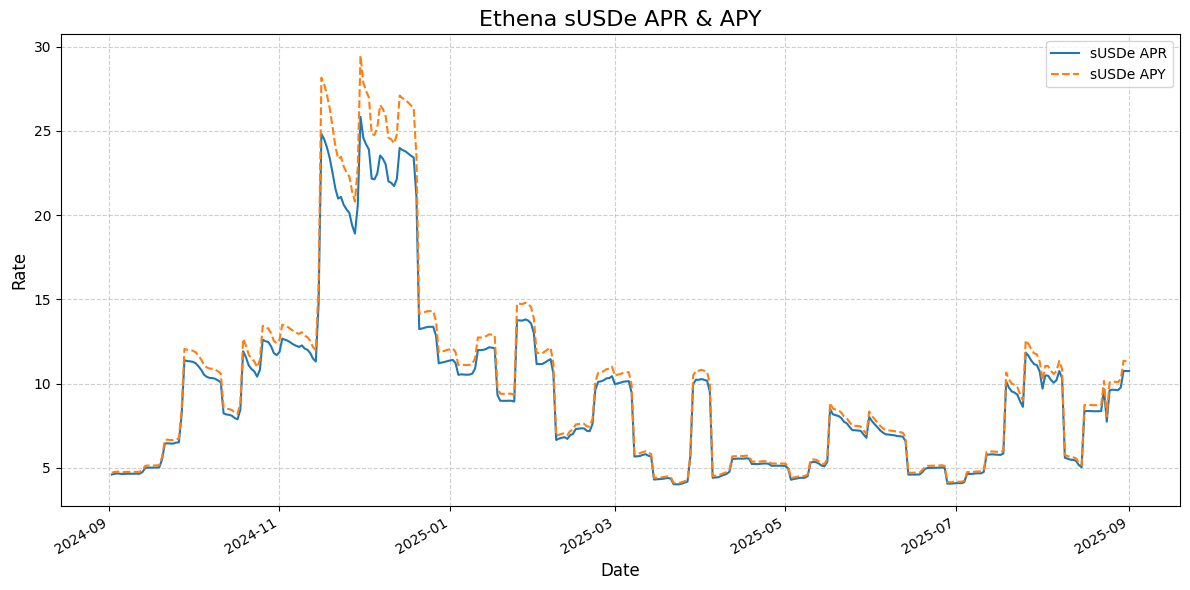

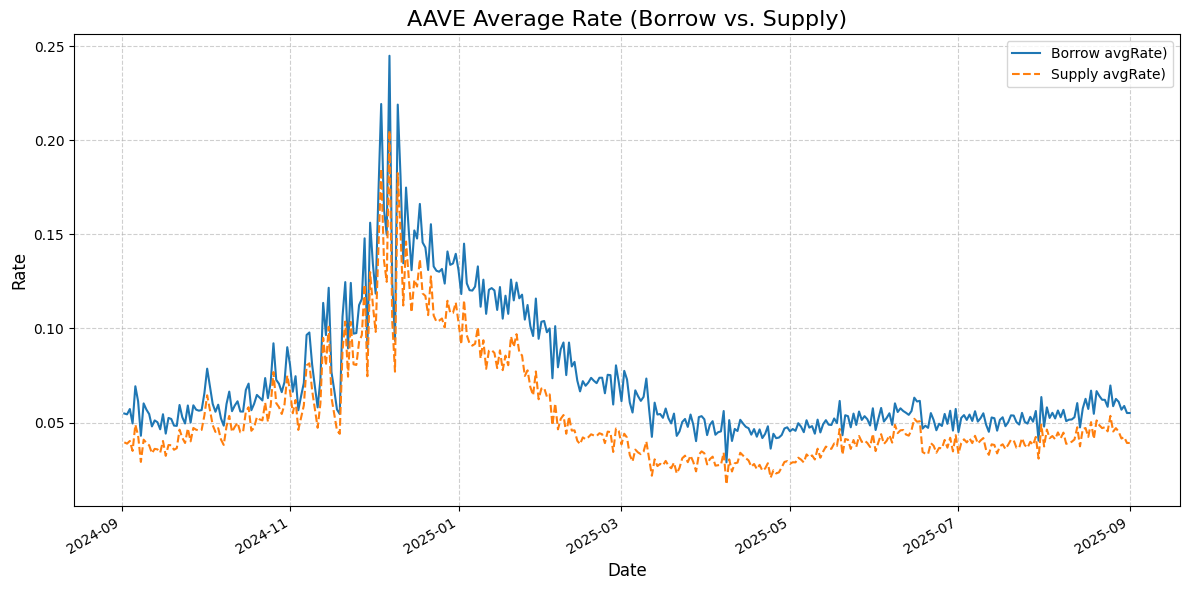

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

usdc_borrow_plot = usdc_borrow.copy()
usdc_supply_plot = usdc_supply.copy()


# --- 資料預處理函數 (避免重複程式碼) ---
def preprocess_df(df):
    """將 date 欄位轉為日期格式並排序"""
    df['date'] = pd.to_datetime(df['date'])
    return df.sort_values('date')

# 預處理您的數據
usdc_borrow_plot = preprocess_df(usdc_borrow_plot)
usdc_supply_plot = preprocess_df(usdc_supply_plot)


# --- 圖表一：USDe Net Mint 時間序列圖 ---
print("正在繪製圖表一：USDe Net Mint...")

fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(usdc_borrow_plot['date'], usdc_borrow_plot['USDe_NET_MINT'], label='USDe_NET_MINT (from USDC Borrow group)', color='skyblue')
ax1.set_title('USDe Net Mint Volume', fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Net Mint Volume', fontsize=12)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
fig1.autofmt_xdate()
plt.tight_layout()
fig1.savefig('usde_net_mint.png', dpi=300)
print("圖表一已儲存為 usde_net_mint.png")


# --- 圖表二：sUSDe APR & APY 時間序列圖 ---
print("\n正在繪製圖表二：sUSDe APR & APY...")

fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(usdc_borrow_plot['date'], usdc_borrow_plot['sUSDe_apr'], label='sUSDe APR')
ax2.plot(usdc_borrow_plot['date'], usdc_borrow_plot['sUSDe_apy'], label='sUSDe APY', linestyle='--')
ax2.set_title('Ethena sUSDe APR & APY', fontsize=16)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Rate', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
fig2.autofmt_xdate()
plt.tight_layout()
fig2.savefig('susde_rates.png', dpi=300)
print("圖表二已儲存為 susde_rates.png")


# --- 圖表三：AAVE Average Rate (Borrow vs. Supply) 時間序列圖 ---
print("\n正在繪製圖表三：AAVE Average Rate...")

fig3, ax3 = plt.subplots(figsize=(12, 6))
ax3.plot(usdc_borrow_plot['date'], usdc_borrow_plot['AAVE avgRate'], label='Borrow avgRate)')
ax3.plot(usdc_supply_plot['date'], usdc_supply_plot['AAVE avgRate'], label='Supply avgRate)', linestyle='--')
ax3.set_title('AAVE Average Rate (Borrow vs. Supply)', fontsize=16)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Rate', fontsize=12)
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.6)
fig3.autofmt_xdate()
plt.tight_layout()
fig3.savefig('aave_avg_rate.png', dpi=300)
print("圖表三已儲存為 aave_avg_rate.png")

# 顯示所有圖表 (如果您在 Jupyter Notebook 中，可以省略這行)
plt.show()

**Data Range: 2025/1/1–2025/9/1**

In [12]:
# 過濾出 2025 年的資料

from datetime import date

start_date = date(2025, 1, 1)
end_date = date(2025, 12, 31)

usdc_borrow_2025 = usdc_borrow[(usdc_borrow['date'] >= start_date) & (usdc_borrow['date'] <= end_date)]
usdc_supply_2025 = usdc_supply[(usdc_supply['date'] >= start_date) & (usdc_supply['date'] <= end_date)]
usdt_borrow_2025 = usdt_borrow[(usdt_borrow['date'] >= start_date) & (usdt_borrow['date'] <= end_date)]
usdt_supply_2025 = usdt_supply[(usdt_supply['date'] >= start_date) & (usdt_supply['date'] <= end_date)]


print(len(usdc_borrow_2025), len(usdc_supply_2025), len(usdt_borrow_2025), len(usdt_supply_2025))

244 244 244 244


In [13]:
groups = {
    '2025 USDC - Borrow': usdc_borrow_2025,
    '2025 USDC - Supply': usdc_supply_2025,
    '2025 USDT - Borrow': usdt_borrow_2025,
    '2025 USDT - Supply': usdt_supply_2025,
}

desired_order = ['USDe_NET_MINT', 'USDe_TOTAL_SUPPLY', 'sUSDe_apr', 'sUSDe_apy', 'AAVE avgRate']


# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== {name} ===")
    corr_matrix = df.corr(numeric_only=True)
    corr_matrix = corr_matrix.reindex(index=desired_order, columns=desired_order)
    print(corr_matrix, "\n")


=== 2025 USDC - Borrow ===
                   USDe_NET_MINT  USDe_TOTAL_SUPPLY  sUSDe_apr  sUSDe_apy  \
USDe_NET_MINT           1.000000           0.447194   0.199020   0.197569   
USDe_TOTAL_SUPPLY       0.447194           1.000000   0.300050   0.297272   
sUSDe_apr               0.199020           0.300050   1.000000   0.999929   
sUSDe_apy               0.197569           0.297272   0.999929   1.000000   
AAVE avgRate           -0.114476           0.011516   0.626653   0.628333   

                   AAVE avgRate  
USDe_NET_MINT         -0.114476  
USDe_TOTAL_SUPPLY      0.011516  
sUSDe_apr              0.626653  
sUSDe_apy              0.628333  
AAVE avgRate           1.000000   

=== 2025 USDC - Supply ===
                   USDe_NET_MINT  USDe_TOTAL_SUPPLY  sUSDe_apr  sUSDe_apy  \
USDe_NET_MINT           1.000000           0.447194   0.199020   0.197569   
USDe_TOTAL_SUPPLY       0.447194           1.000000   0.300050   0.297272   
sUSDe_apr               0.199020           0.3

In [14]:
import pandas as pd

def compute_lag_correlations(df, x_col, y_col, max_lag=7):
    """
    計算 y_col 對 x_col 的延遲相關係數
    y_col: 目標變數（例如 USDe_NET_MINT）
    x_col: 解釋變數（例如 AAVE avgRate）
    max_lag: 最大延遲天數（正數代表 y 落後 x）
    """
    results = []

    for lag in range(-max_lag, max_lag + 1):
        shifted = df[[x_col, y_col]].copy()
        shifted[y_col] = shifted[y_col].shift(-lag)  # shift 負號代表 y 落後 x
        corr = shifted.corr().iloc[0, 1]
        results.append({'lag': lag, 'correlation': corr})

    return pd.DataFrame(results)

# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== 2025 {name} ===")

    # 範例：計算 USDC Borrow 資料中的 lag correlation
    usdc_borrow_lag_corr = compute_lag_correlations(
        usdc_borrow,
        x_col='AAVE avgRate',
        y_col='USDe_NET_MINT',
        max_lag=7
    )

    # 顯示結果
    print(usdc_borrow_lag_corr, "\n")


=== 2025 2025 USDC - Borrow ===
    lag  correlation
0    -7    -0.015907
1    -6    -0.003365
2    -5     0.019819
3    -4     0.011056
4    -3     0.000660
5    -2     0.039074
6    -1     0.075865
7     0     0.037617
8     1     0.070882
9     2     0.126850
10    3     0.068896
11    4     0.078761
12    5     0.145953
13    6     0.110391
14    7     0.089237 

=== 2025 2025 USDC - Supply ===
    lag  correlation
0    -7    -0.015907
1    -6    -0.003365
2    -5     0.019819
3    -4     0.011056
4    -3     0.000660
5    -2     0.039074
6    -1     0.075865
7     0     0.037617
8     1     0.070882
9     2     0.126850
10    3     0.068896
11    4     0.078761
12    5     0.145953
13    6     0.110391
14    7     0.089237 

=== 2025 2025 USDT - Borrow ===
    lag  correlation
0    -7    -0.015907
1    -6    -0.003365
2    -5     0.019819
3    -4     0.011056
4    -3     0.000660
5    -2     0.039074
6    -1     0.075865
7     0     0.037617
8     1     0.070882
9     2     0.1268

## 📈 Market Momentum Analysis: Does ETH Price Drive USDe Minting?

### 🔄 Context: Shifting Focus from Aave Rates to Market Conditions

In the previous section, we established that **Aave interest rates have little to no correlation with USDe minting volume**. This led us to ask a broader question:  
> Could the explosive growth of Aave × Ethena activity in 2025 be primarily driven by the **bullish ETH market** rather than protocol incentives?

To explore this, we integrated external market variables — most notably **ETH price momentum** — and examined their statistical relationship with `USDe_NET_MINT`.

---

### 🛠 Step 1: ETH Price Feature Engineering

We processed daily ETH price data and constructed the following key features:

- `ETH_return_1d`: 1-day return (daily % change)
- `ETH_return_7d`: 7-day sliding return
- `ETH_price_ma_30`: 30-day moving average of ETH price
- `ETH_price_gap`: Momentum signal (current price – 30D moving average)

These variables were then merged with our Aave-Ethena dataset to form new correlation test groups.

In [15]:
ETH_price = pd.read_excel(file_path + 'ETH price.xlsx')

ETH_price['date'] = pd.to_datetime(ETH_price['time']).dt.date

ETH_price.drop(columns=['time'], inplace=True)

# 重新命名方便處理
ETH_price = ETH_price.rename(columns={'ETH price': 'ETH_price'})

# 按日期排序（你目前資料是倒序的）
ETH_price = ETH_price.sort_values(by='date').reset_index(drop=True)

# 計算 eth_return_1d：今日價格 / 昨日價格 - 1
ETH_price['ETH_return_1d'] = ETH_price['ETH_price'].pct_change()

# 計算 eth_return_7d：近 7 日滑動報酬率（今日價格 / 前7日價格 - 1）
ETH_price['ETH_return_7d'] = ETH_price['ETH_price'] / ETH_price['ETH_price'].shift(7) - 1

# 計算 30 日移動平均價格
ETH_price['ETH_price_ma_30'] = ETH_price['ETH_price'].rolling(window=30).mean()

# 計算動能信號（今日價格 - 30日均線）
ETH_price['ETH_price_gap'] = ETH_price['ETH_price'] - ETH_price['ETH_price_ma_30']



print(ETH_price[80:])

       ETH_price        date  ETH_return_1d  ETH_return_7d  ETH_price_ma_30  \
80   2546.646007  2024-08-29       0.020260      -0.028973      2687.835880   
81   2512.899410  2024-08-30      -0.013251      -0.064249      2661.775064   
82   2521.198160  2024-08-31       0.003302      -0.089272      2640.118894   
83   2482.008368  2024-09-01      -0.015544      -0.102421      2619.347079   
84   2494.741771  2024-09-02       0.005130      -0.085197      2603.812128   
..           ...         ...            ...            ...              ...   
445  4389.248333  2025-08-29      -0.033544      -0.021608      4217.304258   
446  4366.247986  2025-08-30      -0.005240      -0.078697      4235.822926   
447  4461.085660  2025-08-31       0.021721      -0.069192      4263.943659   
448  4378.767847  2025-09-01      -0.018452      -0.049104      4293.997164   
449  4314.793226  2025-09-02      -0.014610      -0.036973      4322.119826   

     ETH_price_gap  
80     -141.189873  
81     -1

In [16]:
merged = pd.merge(merged, ETH_price, on='date', how='inner')

print(merged.head())

   sUSDe_apr  sUSDe_apy        date  USDe_NET_MINT  USDe_TOTAL_SUPPLY Token  \
0  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDC   
1  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDC   
2  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDT   
3  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDT   
4  10.749316  11.346562  2025-08-31   1.814211e+07       1.234136e+10  USDC   

  AAVE Action  AAVE avgRate    ETH_price  ETH_return_1d  ETH_return_7d  \
0      Borrow      0.055049  4378.767847      -0.018452      -0.049104   
1      Supply      0.039127  4378.767847      -0.018452      -0.049104   
2      Borrow      0.054631  4378.767847      -0.018452      -0.049104   
3      Supply      0.037814  4378.767847      -0.018452      -0.049104   
4      Borrow      0.055049  4461.085660       0.021721      -0.069192   

   ETH_price_ma_30  ETH_price_gap  
0      4293.997164      84.770683  
1      4

### 📊 Step 2: Correlation Between ETH Momentum and USDe Minting

We recomputed Pearson correlation coefficients between ETH momentum signals and USDe mint volume across the four transaction paths:

- USDC - Borrow  
- USDC - Supply  
- USDT - Borrow  
- USDT - Supply

We observed that **ETH price increases tend to correlate positively with increases in `USDe_NET_MINT`**, suggesting that market optimism may directly drive minting behavior.



In [17]:
# 篩出四種組合
usdc_borrow_ETH = merged[(merged['Token'] == 'USDC') & (merged['AAVE Action'] == 'Borrow')]
usdc_supply_ETH = merged[(merged['Token'] == 'USDC') & (merged['AAVE Action'] == 'Supply')]
usdt_borrow_ETH = merged[(merged['Token'] == 'USDT') & (merged['AAVE Action'] == 'Borrow')]
usdt_supply_ETH = merged[(merged['Token'] == 'USDT') & (merged['AAVE Action'] == 'Supply')]

print(len(usdc_borrow_ETH), len(usdc_supply_ETH), len(usdt_borrow_ETH), len(usdt_supply_ETH))

365 365 365 365


In [18]:
groups = {
    'USDC - Borrow - ETH': usdc_borrow_ETH,
    'USDC - Supply - ETH': usdc_supply_ETH,
    'USDT - Borrow - ETH': usdt_borrow_ETH,
    'USDT - Supply - ETH': usdt_supply_ETH,
}

desired_order = ['USDe_NET_MINT', 'USDe_TOTAL_SUPPLY',
          'ETH_price', 'ETH_return_1d', 'ETH_return_7d',
          'ETH_price_ma_30', 'ETH_price_gap',
          'sUSDe_apr', 'sUSDe_apy', 'AAVE avgRate']

# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== {name} ===")
    corr_matrix = df.corr(numeric_only=True)
    corr_matrix = corr_matrix.reindex(index=desired_order, columns=desired_order)
    print(corr_matrix, "\n")

=== USDC - Borrow - ETH ===
                   USDe_NET_MINT  USDe_TOTAL_SUPPLY  ETH_price  ETH_return_1d  \
USDe_NET_MINT           1.000000           0.345464   0.505548       0.124647   
USDe_TOTAL_SUPPLY       0.345464           1.000000   0.612296      -0.025491   
ETH_price               0.505548           0.612296   1.000000       0.090076   
ETH_return_1d           0.124647          -0.025491   0.090076       1.000000   
ETH_return_7d           0.289353          -0.002155   0.263956       0.375204   
ETH_price_ma_30         0.292699           0.610908   0.889735      -0.072149   
ETH_price_gap           0.567668           0.221364   0.557881       0.327136   
sUSDe_apr               0.250283          -0.048918   0.511715      -0.047045   
sUSDe_apy               0.248943          -0.052703   0.505131      -0.044413   
AAVE avgRate            0.037617          -0.000516   0.475228      -0.076846   

                   ETH_return_7d  ETH_price_ma_30  ETH_price_gap  sUSDe_apr  \
U

### 🧪 Step 3: Granger Causality Tests

We conducted **Granger causality tests** to assess whether ETH price movements **precede and cause** changes in USDe minting. Specifically, we tested:

- Whether today's ETH price → Granger has predictive power for future mint volume
- Whether 3-day ETH rallies → Granger has predictive power for minting behavior

Results confirmed that **single-day ETH price increases are predictive**, but **consecutive rallies over 3 days** do **not** significantly impact minting — indicating traders react to immediate momentum but not extended trends.


In [19]:
# 今天的ETH上漲，幾天內鑄造量會增加

from statsmodels.tsa.stattools import grangercausalitytests

# 假設 df 是你合併後的資料（日期升序）
# 測試 ETH_price 對 USDe_NET_MINT 是否有 Granger 因果性（最多延遲14天）
grangercausalitytests(df[['USDe_NET_MINT', 'ETH_price']], maxlag=10)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=48.0836 , p=0.0000  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=48.4832 , p=0.0000  , df=1
likelihood ratio test: chi2=45.5152 , p=0.0000  , df=1
parameter F test:         F=48.0836 , p=0.0000  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=19.3486 , p=0.0000  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=39.2376 , p=0.0000  , df=2
likelihood ratio test: chi2=37.2584 , p=0.0000  , df=2
parameter F test:         F=19.3486 , p=0.0000  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.3376  , p=0.0001  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=22.4469 , p=0.0001  , df=3
likelihood ratio test: chi2=21.7784 , p=0.0001  , df=3
parameter F test:         F=7.3376  , p=0.0001  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.7955  , p=0.0002  

{np.int64(1): ({'ssr_ftest': (np.float64(48.083647032483164),
    np.float64(1.8931883233254125e-11),
    np.float64(361.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(48.48323412693594),
    np.float64(3.3312473072439187e-12),
    np.int64(1)),
   'lrtest': (np.float64(45.51517616872661),
    np.float64(1.5146072357097998e-11),
    np.int64(1)),
   'params_ftest': (np.float64(48.083647032483405),
    np.float64(1.8931883233252377e-11),
    np.float64(361.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(19.34858566284449),
    np.float64(1.0492577923935667e-08),
    np.float64(358.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(39.23763461236061),
    np.float64(3.0175599184181582e-09),
    np.int64(2)),
   'lrtest': (np.float64(37.258396441140576),
    np.float64(8.117868472900062e-09),
    np.int64(2)),
   'params_ftest': (np.float64(19.34858566284313),
    np.float64(1.0492577923948564e-08),
    np.float64(358.0),
    2.0)},
   array([[0

In [20]:
def prepare_eth_up_ndays(df, n=3):
    df = df.copy()

    # 只保留需要的欄位
    df = df[['date', 'ETH_price', 'USDe_NET_MINT']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df.set_index('date', inplace=True)

    # 計算每日報酬率
    df['eth_return'] = df['ETH_price'].pct_change()

    # 建立 eth_up_ndays（例如連續 n 天都上漲）
    df[f'eth_up_{n}d'] = (
        df['eth_return']
        .rolling(window=n)
        .apply(lambda x: all(x > 0), raw=True)
        .shift(1)  # 滯後一日，避免未來資訊洩漏
    )

    return df


# 設定連漲天數
n = 3

df_usdc_borrow = prepare_eth_up_ndays(usdc_borrow_ETH, n)
df_usdc_supply = prepare_eth_up_ndays(usdc_supply_ETH, n)
df_usdt_borrow = prepare_eth_up_ndays(usdt_borrow_ETH, n)
df_usdt_supply = prepare_eth_up_ndays(usdt_supply_ETH, n)

from statsmodels.tsa.stattools import grangercausalitytests

def run_granger_test(df, up_col, mint_col, max_lag=7):
    df = df[[up_col, mint_col]].dropna()
    # 強制轉 float，避免 bool 類型錯誤
    df[up_col] = df[up_col].astype(float)
    df[mint_col] = df[mint_col].astype(float)
    print(f"\nGranger Causality Test: {up_col} ➜ {mint_col}")
    grangercausalitytests(df, maxlag=max_lag, verbose=True)


run_granger_test(df_usdc_borrow, 'USDe_NET_MINT', f'eth_up_{n}d')
run_granger_test(df_usdc_supply, 'USDe_NET_MINT', f'eth_up_{n}d')
# run_granger_test(df_usdc_borrow, f'eth_up_{n}d', 'USDe_NET_MINT')
# run_granger_test(df_usdc_supply, f'eth_up_{n}d', 'USDe_NET_MINT')
# run_granger_test(df_usdt_borrow, f'eth_up_{n}d', 'USDe_NET_MINT')
# run_granger_test(df_usdt_supply, f'eth_up_{n}d', 'USDe_NET_MINT')




Granger Causality Test: USDe_NET_MINT ➜ eth_up_3d

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0302  , p=0.1551  , df_denom=357, df_num=1
ssr based chi2 test:   chi2=2.0473  , p=0.1525  , df=1
likelihood ratio test: chi2=2.0415  , p=0.1531  , df=1
parameter F test:         F=2.0302  , p=0.1551  , df_denom=357, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1394  , p=0.3212  , df_denom=354, df_num=2
ssr based chi2 test:   chi2=2.3110  , p=0.3149  , df=2
likelihood ratio test: chi2=2.3036  , p=0.3161  , df=2
parameter F test:         F=1.1394  , p=0.3212  , df_denom=354, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6528  , p=0.5816  , df_denom=351, df_num=3
ssr based chi2 test:   chi2=1.9975  , p=0.5729  , df=3
likelihood ratio test: chi2=1.9920  , p=0.5741  , df=3
parameter F test:         F=0.6528  , p=0.5816  , df_denom=351, df_num=3

Granger Causality
number of lags (no zero)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### 🧮 Step 4: Leverage APY Simulation and Rate Spread

We then simulated a simplified **leveraged APY model** to evaluate protocol-level incentive dynamics:

- Calculated `rate_spread = sUSDe_apy – borrow_rate`
- Derived `leveraged_apy_nx = (n+1) * sUSDe_apy – n * borrow_rate` for `n = 1~5`

We found that even these **amplified internal yields** showed only **weak or inconsistent correlation** with USDe minting — reinforcing the earlier conclusion that **external market forces dominate** user behavior.

Granger tests on `leveraged_apy_1x` and `rate_spread` also failed to show consistent causal effects on minting behavior.


In [21]:
# 複製資料
borrow_df = usdc_borrow_ETH[['date', 'AAVE avgRate', 'sUSDe_apy', 'USDe_NET_MINT']].copy()
supply_df = usdc_supply_ETH[['date', 'AAVE avgRate']].copy()

# 重新命名避免衝突
borrow_df = borrow_df.rename(columns={'AAVE avgRate': 'borrow_rate'})
supply_df = supply_df.rename(columns={'AAVE avgRate': 'supply_rate'})

# 合併
merged_df = pd.merge(borrow_df, supply_df, on='date', how='inner')

# 計算利差
merged_df['rate_spread'] = merged_df['sUSDe_apy'] - merged_df['borrow_rate']

print(merged_df.head())


         date  borrow_rate  sUSDe_apy  USDe_NET_MINT  supply_rate  rate_spread
0  2025-09-01     0.055049  11.344974   4.166035e+07     0.039127    11.289925
1  2025-08-31     0.055049  11.346562   1.814211e+07     0.039127    11.291514
2  2025-08-30     0.058799  11.361460   2.449156e+07     0.042279    11.302661
3  2025-08-29     0.056815  10.268501   2.342171e+07     0.041480    10.211686
4  2025-08-28     0.060991  10.089867   4.555285e+07     0.045127    10.028876


In [22]:
corr = merged_df.corr(numeric_only=True)
print(corr)


               borrow_rate  sUSDe_apy  USDe_NET_MINT  supply_rate  rate_spread
borrow_rate       1.000000   0.734189       0.037617     0.979837     0.731506
sUSDe_apy         0.734189   1.000000       0.248943     0.771089     0.999992
USDe_NET_MINT     0.037617   0.248943       1.000000     0.091481     0.249784
supply_rate       0.979837   0.771089       0.091481     1.000000     0.768680
rate_spread       0.731506   0.999992       0.249784     0.768680     1.000000


In [23]:
# 加入槓桿收益率 (leveraged_apy) 的簡易模型

# 建立不同 loop 倍數下的槓桿報酬率欄位
for n in range(1, 6):  # 1 到 5 次 loop
    merged_df[f'leveraged_apy_{n}x'] = (n + 1) * merged_df['sUSDe_apy'] - n * merged_df['borrow_rate']

df_leveraged_apy = merged_df.corr(numeric_only=True)
print(df_leveraged_apy)


                  borrow_rate  sUSDe_apy  USDe_NET_MINT  supply_rate  \
borrow_rate          1.000000   0.734189       0.037617     0.979837   
sUSDe_apy            0.734189   1.000000       0.248943     0.771089   
USDe_NET_MINT        0.037617   0.248943       1.000000     0.091481   
supply_rate          0.979837   0.771089       0.091481     1.000000   
rate_spread          0.731506   0.999992       0.249784     0.768680   
leveraged_apy_1x     0.732852   0.999998       0.249363     0.769888   
leveraged_apy_2x     0.732404   0.999997       0.249504     0.769487   
leveraged_apy_3x     0.732180   0.999996       0.249574     0.769285   
leveraged_apy_4x     0.732045   0.999995       0.249616     0.769164   
leveraged_apy_5x     0.731955   0.999995       0.249644     0.769084   

                  rate_spread  leveraged_apy_1x  leveraged_apy_2x  \
borrow_rate          0.731506          0.732852          0.732404   
sUSDe_apy            0.999992          0.999998          0.999997   


In [24]:
print(merged_df.head())

         date  borrow_rate  sUSDe_apy  USDe_NET_MINT  supply_rate  \
0  2025-09-01     0.055049  11.344974   4.166035e+07     0.039127   
1  2025-08-31     0.055049  11.346562   1.814211e+07     0.039127   
2  2025-08-30     0.058799  11.361460   2.449156e+07     0.042279   
3  2025-08-29     0.056815  10.268501   2.342171e+07     0.041480   
4  2025-08-28     0.060991  10.089867   4.555285e+07     0.045127   

   rate_spread  leveraged_apy_1x  leveraged_apy_2x  leveraged_apy_3x  \
0    11.289925         22.634899         33.924824         45.214749   
1    11.291514         22.638076         33.929590         45.221103   
2    11.302661         22.664121         33.966781         45.269442   
3    10.211686         20.480187         30.691873         40.903559   
4    10.028876         20.118742         30.147618         40.176494   

   leveraged_apy_4x  leveraged_apy_5x  
0         56.504674         67.794599  
1         56.512617         67.804131  
2         56.572103         67.8

In [25]:
from statsmodels.tsa.stattools import grangercausalitytests

# 準備資料：只取這兩欄，並轉成 float
gc_df = merged_df[['USDe_NET_MINT', 'leveraged_apy_1x']].dropna().astype(float)

# 注意：Granger 的格式是 (被解釋變數 ➜ 解釋變數)
# 所以順序是 [Y, X] ➜ 測試 X 是否 Granger-cause Y
print("=== Granger Causality Test: leveraged_apy_1x ➜ USDe_NET_MINT ===")
grangercausalitytests(gc_df[['USDe_NET_MINT', 'leveraged_apy_1x']], maxlag=7, verbose=True)


=== Granger Causality Test: leveraged_apy_1x ➜ USDe_NET_MINT ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2606 , p=0.0015  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=10.3458 , p=0.0013  , df=1
likelihood ratio test: chi2=10.2015 , p=0.0014  , df=1
parameter F test:         F=10.2606 , p=0.0015  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0956  , p=0.0174  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=8.3057  , p=0.0157  , df=2
likelihood ratio test: chi2=8.2121  , p=0.0165  , df=2
parameter F test:         F=4.0956  , p=0.0174  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8632  , p=0.1355  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=5.6998  , p=0.1272  , df=3
likelihood ratio test: chi2=5.6554  , p=0.1296  , df=3
parameter F test:         F=1.8632  , p=0.1355  , df_denom=355, df_num=3

Granger Causality
number of 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(10.260563740010552),
    np.float64(0.0014798940487672479),
    np.float64(361.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(10.345831582725319),
    np.float64(0.0012976739250952333),
    np.int64(1)),
   'lrtest': (np.float64(10.201531666783922),
    np.float64(0.0014032405609497613),
    np.int64(1)),
   'params_ftest': (np.float64(10.26056374001069),
    np.float64(0.0014798940487671126),
    np.float64(361.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(4.095629277866691),
    np.float64(0.017431494119575994),
    np.float64(358.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(8.30566160818776),
    np.float64(0.015719853614268302),
    np.int64(2)),
   'lrtest': (np.float64(8.212067278311224),
    np.float64(0.016472982915229303),
    np.int64(2)),
   'params_ftest': (np.float64(4.095629277866809),
    np.float64(0.017431494119574228),
    np.float64(358.0),
    2.0)},
   array([[0., 0., 1., 0

In [26]:
from statsmodels.tsa.stattools import grangercausalitytests

def run_granger_test(df, x_col, y_col, max_lag=15):
    df_granger = merged_df[[x_col, y_col]].dropna().copy()
    df_granger[x_col] = df_granger[x_col].astype(float)
    df_granger[y_col] = df_granger[y_col].astype(float)

    print(f"\n📊 Granger Causality Test: {x_col} ➜ {y_col}")
    grangercausalitytests(df_granger, maxlag=max_lag, verbose=True)

# 套用到你的 USDC borrow dataframe
run_granger_test(merged_df, x_col='rate_spread', y_col='USDe_NET_MINT')



📊 Granger Causality Test: rate_spread ➜ USDe_NET_MINT

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2051  , p=0.6509  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=0.2068  , p=0.6493  , df=1
likelihood ratio test: chi2=0.2067  , p=0.6493  , df=1
parameter F test:         F=0.2051  , p=0.6509  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3790  , p=0.6848  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=0.7685  , p=0.6809  , df=2
likelihood ratio test: chi2=0.7677  , p=0.6812  , df=2
parameter F test:         F=0.3790  , p=0.6848  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6479  , p=0.5847  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=1.9820  , p=0.5762  , df=3
likelihood ratio test: chi2=1.9766  , p=0.5773  , df=3
parameter F test:         F=0.6479  , p=0.5847  , df_denom=355, df_num=3

Granger Causality
number of lags (no z

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### ✅ Conclusion

The evidence strongly suggests that **ETH price momentum — not protocol interest rates — is the dominant driver** behind the 2025 boom in Aave × Ethena activity.

This shifts the analytical focus toward external market dynamics as the core predictive mechanism in subsequent modeling phases.

## 📈 Market Momentum Analysis (Part II): Does BTC Price Affect USDe Minting?

### 🔄 Motivation: Adding BTC to Confirm Whether Market-Wide Bullishness Drives Minting Behavior

After confirming that **ETH price momentum has a significant influence on USDe minting**, we extend the analysis by incorporating **BTC price signals**. The goal is to test whether general crypto market optimism — not just ETH — plays a predictive role in driving activity on the Aave × Ethena pathway.

### 🛠 Step 1: BTC Price Feature Engineering and Dataset Integration

We constructed the following BTC momentum variables:

- `BTC_return_1d`: 1-day return (% change from previous day)  
- `BTC_return_7d`: 7-day rolling return  
- `BTC_price_ma_30`: 30-day moving average  
- `BTC_price_gap`: Momentum signal (current price − 30D MA)

These features were merged with the unified dataset (sUSDe, USDe minting, Aave rates, ETH price), and data was segmented into four groups based on token type and Aave action for downstream analysis.


In [27]:
# 加入BTC price
BTC_price = pd.read_excel(file_path + 'BTC price.xlsx')

BTC_price['date'] = pd.to_datetime(BTC_price['time']).dt.date

BTC_price.drop(columns=['time'], inplace=True)

# 重新命名方便處理
BTC_price = BTC_price.rename(columns={'BTC': 'BTC_price'})

# 按日期排序（你目前資料是倒序的）
BTC_price = BTC_price.sort_values(by='date').reset_index(drop=True)

# 計算 BTC_return_1d：今日價格 / 昨日價格 - 1
BTC_price['BTC_return_1d'] = BTC_price['BTC_price'].pct_change()

# 計算 BTC_return_7d：近 7 日滑動報酬率（今日價格 / 前7日價格 - 1）
BTC_price['BTC_return_7d'] = BTC_price['BTC_price'] / BTC_price['BTC_price'].shift(7) - 1

# 計算 30 日移動平均價格
BTC_price['BTC_price_ma_30'] = BTC_price['BTC_price'].rolling(window=30).mean()

# 計算動能信號（今日價格 - 30日均線）
BTC_price['BTC_price_gap'] = BTC_price['BTC_price'] - BTC_price['BTC_price_ma_30']


print(BTC_price[80:])

         BTC_price        date  BTC_return_1d  BTC_return_7d  BTC_price_ma_30  \
80    59728.044410  2024-08-29       0.006642      -0.016286     60362.739731   
81    59146.992222  2024-08-30      -0.009728      -0.042699     60133.086843   
82    59138.825278  2024-08-31      -0.000138      -0.077646     59964.974316   
83    58331.959410  2024-09-01      -0.013644      -0.091018     59781.136752   
84    58255.894028  2024-09-02      -0.001304      -0.085963     59678.336363   
..             ...         ...            ...            ...              ...   
445  109899.264757  2025-08-29      -0.023709      -0.039334    115454.481843   
446  108567.135278  2025-08-30      -0.012121      -0.059594    115141.996568   
447  108860.998090  2025-08-31       0.002707      -0.049392    114942.412692   
448  108603.496111  2025-09-01      -0.002365      -0.029716    114782.708582   
449  109879.902791  2025-09-02       0.011753      -0.004336    114649.040195   

     BTC_price_gap  
80    

In [28]:
# 先合併 sUSDe_apy 與 USDe 鑄造量
all_merged = pd.merge(df_susde, df_usde, on='date', how='inner')

# 再合併 AAVE 日利率資料
all_merged = pd.merge(all_merged, df_aave, on='date', how='inner')

# 合併ETH和BTC 價格
all_merged = pd.merge(all_merged, BTC_price, on='date', how='inner')
all_merged = pd.merge(all_merged, ETH_price, on='date', how='inner')

all_merged.drop(columns=['DAY','block_time'], inplace=True)

print(all_merged.head())

   sUSDe_apr  sUSDe_apy        date  USDe_NET_MINT  USDe_TOTAL_SUPPLY Token  \
0  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDC   
1  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDC   
2  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDT   
3  10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDT   
4  10.749316  11.346562  2025-08-31   1.814211e+07       1.234136e+10  USDC   

  AAVE Action  AAVE avgRate      BTC_price  BTC_return_1d  BTC_return_7d  \
0      Borrow      0.055049  108603.496111      -0.002365      -0.029716   
1      Supply      0.039127  108603.496111      -0.002365      -0.029716   
2      Borrow      0.054631  108603.496111      -0.002365      -0.029716   
3      Supply      0.037814  108603.496111      -0.002365      -0.029716   
4      Borrow      0.055049  108860.998090       0.002707      -0.049392   

   BTC_price_ma_30  BTC_price_gap    ETH_price  ETH_return_1d  ETH_r

### 📊 Step 2: Correlation Between BTC Price and USDe Minting

We computed Pearson correlation coefficients between BTC momentum indicators and `USDe_NET_MINT`.

Key observations:

- BTC price (`BTC_price`) showed **moderate positive correlation** with minting, especially in the **USDC-Borrow** group (up to ~0.38)
- Momentum variables like `BTC_price_gap` and `BTC_return_7d` also showed similar directional relationships, but with **weaker magnitude than ETH**

In [29]:
# 篩出四種組合
all_usdc_borrow = all_merged[(all_merged['Token'] == 'USDC') & (all_merged['AAVE Action'] == 'Borrow')]
all_usdc_supply = all_merged[(all_merged['Token'] == 'USDC') & (all_merged['AAVE Action'] == 'Supply')]
all_usdt_borrow = all_merged[(all_merged['Token'] == 'USDT') & (all_merged['AAVE Action'] == 'Borrow')]
all_usdt_supply = all_merged[(all_merged['Token'] == 'USDT') & (all_merged['AAVE Action'] == 'Supply')]

print(len(all_usdc_borrow), len(all_usdc_supply), len(all_usdt_borrow), len(all_usdt_supply))

365 365 365 365


In [30]:
groups = {
    'USDC - Borrow': all_usdc_borrow,
    'USDC - Supply': all_usdc_supply,
    'USDT - Borrow': all_usdt_borrow,
    'USDT - Supply': all_usdt_supply,
}

desired_order = ['USDe_NET_MINT', 'USDe_TOTAL_SUPPLY',
          'ETH_price', 'ETH_return_7d', 'ETH_price_ma_30', 'ETH_price_gap',
          'BTC_price', 'BTC_return_7d', 'BTC_price_ma_30', 'BTC_price_gap',
          'sUSDe_apr', 'sUSDe_apy', 'AAVE avgRate']

# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== {name} ===")
    corr_matrix = df.corr(numeric_only=True)
    # corr_matrix = corr_matrix.reindex(index=desired_order, columns=desired_order)

    # 從中取出 USDe_NET_MINT 對其他變數的相關係數
    corr_matrix = corr_matrix.loc['USDe_NET_MINT', desired_order]
    print(corr_matrix, "\n")


=== USDC - Borrow ===
USDe_NET_MINT        1.000000
USDe_TOTAL_SUPPLY    0.345464
ETH_price            0.505548
ETH_return_7d        0.289353
ETH_price_ma_30      0.292699
ETH_price_gap        0.567668
BTC_price            0.383007
BTC_return_7d        0.045073
BTC_price_ma_30      0.301533
BTC_price_gap        0.236885
sUSDe_apr            0.250283
sUSDe_apy            0.248943
AAVE avgRate         0.037617
Name: USDe_NET_MINT, dtype: float64 

=== USDC - Supply ===
USDe_NET_MINT        1.000000
USDe_TOTAL_SUPPLY    0.345464
ETH_price            0.505548
ETH_return_7d        0.289353
ETH_price_ma_30      0.292699
ETH_price_gap        0.567668
BTC_price            0.383007
BTC_return_7d        0.045073
BTC_price_ma_30      0.301533
BTC_price_gap        0.236885
sUSDe_apr            0.250283
sUSDe_apy            0.248943
AAVE avgRate         0.091481
Name: USDe_NET_MINT, dtype: float64 

=== USDT - Borrow ===
USDe_NET_MINT        1.000000
USDe_TOTAL_SUPPLY    0.345464
ETH_price         

In [31]:
print(all_usdc_borrow.head())

    sUSDe_apr  sUSDe_apy        date  USDe_NET_MINT  USDe_TOTAL_SUPPLY Token  \
0   10.747889  11.344974  2025-09-01   4.166035e+07       1.238302e+10  USDC   
4   10.749316  11.346562  2025-08-31   1.814211e+07       1.234136e+10  USDC   
8   10.762698  11.361460  2025-08-30   2.449156e+07       1.232322e+10  USDC   
12   9.776121  10.268501  2025-08-29   2.342171e+07       1.229873e+10  USDC   
16   9.613947  10.089867  2025-08-28   4.555285e+07       1.227530e+10  USDC   

   AAVE Action  AAVE avgRate      BTC_price  BTC_return_1d  BTC_return_7d  \
0       Borrow      0.055049  108603.496111      -0.002365      -0.029716   
4       Borrow      0.055049  108860.998090       0.002707      -0.049392   
8       Borrow      0.058799  108567.135278      -0.012121      -0.059594   
12      Borrow      0.056815  109899.264757      -0.023709      -0.039334   
16      Borrow      0.060991  112568.087153       0.009408      -0.006368   

    BTC_price_ma_30  BTC_price_gap    ETH_price  ETH_ret


### 🧪 Step 3: Granger Causality Test on Price Momentum

We conduct Granger causality tests to examine whether the following price features help **predict future changes in USDe minting**:

- `ETH_price`
- `ETH_price_gap` (deviation from 30-day MA)
- `BTC_price`
- `BTC_price_gap`

The goal of Granger causality is to test:
> Whether **past values** of one variable significantly help forecast **future values** of another.

While this does **not confirm true causality**, it is widely used in time-series finance as a **predictive signal analysis** tool.


### 📌 Methodology

We conduct Granger causality tests on the following variables across four subgroups (USDC-Borrow/Supply, USDT-Borrow/Supply):

- Price indicators: `ETH_price`, `ETH_price_gap`, `BTC_price`, `BTC_price_gap`
- Minting target: `USDe_NET_MINT`
- Lag tested: BTC (1–10), ETH (1–15)

Using:
```python
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(df, maxlag=n)
```

### 📊 Summary Results (USDC-Borrow example)

🔹 ETH-based predictors:

- ✅ Both `ETH_price` and `ETH_price_gap` are **consistently significant from lag=1 to 15** (p < 0.05)
- → ETH acts as the **strongest and most persistent leading signal** for USDe minting behavior

🔹 BTC-based predictors:

- ✅ `BTC_price` and `BTC_price_gap` are **significant at lag=1 to 3**
- ⚠️ Starting from lag=4, p-values become unstable and often non-significant
- → BTC only **exerts short-term influence**, with predictive power quickly fading

In [32]:
groups = {
    'USDC - Borrow': all_usdc_borrow,
    'USDC - Supply': all_usdc_supply,
    'USDT - Borrow': all_usdt_borrow,
    'USDT - Supply': all_usdt_supply,
}

df = df.sort_values('date').reset_index(drop=True)
print(df.head())


# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== BTC {name} ===")

    df = df.sort_values('date').reset_index(drop=True)
    #今天的BTC上漲，幾天內鑄造量會增加

    from statsmodels.tsa.stattools import grangercausalitytests

    # 假設 df 是你合併後的資料（日期升序）
    # 測試 BTC_price 對 USDe_NET_MINT 是否有 Granger 因果性（最多延遲14天）
    grangercausalitytests(df[['USDe_NET_MINT', 'BTC_price']], maxlag=5)


   sUSDe_apr  sUSDe_apy        date  USDe_NET_MINT  USDe_TOTAL_SUPPLY Token  \
0   4.609565   4.717153  2024-09-02  -8.881750e+07       2.715388e+09  USDT   
1   4.649846   4.759336  2024-09-03  -8.815769e+06       2.706573e+09  USDT   
2   4.670557   4.781032  2024-09-04  -1.390190e+07       2.692671e+09  USDT   
3   4.655763   4.765534  2024-09-05   1.099473e+06       2.693770e+09  USDT   
4   4.638143   4.747078  2024-09-06   7.582063e+04       2.693846e+09  USDT   

  AAVE Action  AAVE avgRate     BTC_price  BTC_return_1d  BTC_return_7d  \
0      Supply      0.036154  58255.894028      -0.001304      -0.085963   
1      Supply      0.032188  58638.427153       0.006566      -0.057724   
2      Supply      0.040983  57198.622431      -0.024554      -0.035988   
3      Supply      0.030969  56840.515035      -0.006261      -0.048345   
4      Supply      0.042822  55316.284444      -0.026816      -0.064766   

   BTC_price_ma_30  BTC_price_gap    ETH_price  ETH_return_1d  ETH_return_

In [33]:
groups = {
    'USDC - Borrow': all_usdc_borrow,
    'USDC - Supply': all_usdc_supply,
    'USDT - Borrow': all_usdt_borrow,
    'USDT - Supply': all_usdt_supply,
}


# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== BTC_price_gap vs {name} ===")

    df = df.sort_values('date').reset_index(drop=True)
    #今天的BTC上漲，幾天內鑄造量會增加

    from statsmodels.tsa.stattools import grangercausalitytests

    # 假設 df 是你合併後的資料（日期升序）
    # 測試 BTC_price_gap 對 USDe_NET_MINT 是否有 Granger 因果性（最多延遲14天）
    grangercausalitytests(df[['USDe_NET_MINT', 'BTC_price_gap']], maxlag=5)


=== BTC_price_gap vs USDC - Borrow ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6311  , p=0.0035  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=8.7029  , p=0.0032  , df=1
likelihood ratio test: chi2=8.6005  , p=0.0034  , df=1
parameter F test:         F=8.6311  , p=0.0035  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5464  , p=0.0298  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=7.1919  , p=0.0274  , df=2
likelihood ratio test: chi2=7.1216  , p=0.0284  , df=2
parameter F test:         F=3.5464  , p=0.0298  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2178  , p=0.0060  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=12.9030 , p=0.0049  , df=3
likelihood ratio test: chi2=12.6784 , p=0.0054  , df=3
parameter F test:         F=4.2178  , p=0.0060  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

In [34]:
# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== ETH {name} ===")

    df = df.sort_values('date').reset_index(drop=True)
    #今天的ETH上漲，幾天內鑄造量會增加

    from statsmodels.tsa.stattools import grangercausalitytests

    # 假設 df 是你合併後的資料（日期升序）
    # 測試 ETH_price 對 USDe_NET_MINT 是否有 Granger 因果性（最多延遲14天）
    grangercausalitytests(df[['USDe_NET_MINT', 'ETH_price']], maxlag=15)

=== ETH USDC - Borrow ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.7474 , p=0.0000  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=38.0611 , p=0.0000  , df=1
likelihood ratio test: chi2=36.1999 , p=0.0000  , df=1
parameter F test:         F=37.7474 , p=0.0000  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.3411 , p=0.0000  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=29.0828 , p=0.0000  , df=2
likelihood ratio test: chi2=27.9765 , p=0.0000  , df=2
parameter F test:         F=14.3411 , p=0.0000  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8899  , p=0.0093  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=11.8997 , p=0.0077  , df=3
likelihood ratio test: chi2=11.7083 , p=0.0085  , df=3
parameter F test:         F=3.8899  , p=0.0093  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:     

In [35]:
# 逐組計算相關係數
for name, df in groups.items():
    print(f"=== ETH_price_gap vs {name} ===")

    df = df.sort_values('date').reset_index(drop=True)
    #今天的BTC上漲，幾天內鑄造量會增加

    from statsmodels.tsa.stattools import grangercausalitytests

    # 假設 df 是你合併後的資料（日期升序）
    # 測試 ETH_price_gap 對 USDe_NET_MINT 是否有 Granger 因果性（最多延遲14天）
    grangercausalitytests(df[['USDe_NET_MINT', 'ETH_price_gap']], maxlag=15)

=== ETH_price_gap vs USDC - Borrow ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=63.0634 , p=0.0000  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=63.5875 , p=0.0000  , df=1
likelihood ratio test: chi2=58.6058 , p=0.0000  , df=1
parameter F test:         F=63.0634 , p=0.0000  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=25.5841 , p=0.0000  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=51.8828 , p=0.0000  , df=2
likelihood ratio test: chi2=48.4944 , p=0.0000  , df=2
parameter F test:         F=25.5841 , p=0.0000  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.8037  , p=0.0000  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=26.9319 , p=0.0000  , df=3
likelihood ratio test: chi2=25.9771 , p=0.0000  , df=3
parameter F test:         F=8.8037  , p=0.0000  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

### 🧭 Supplemental: Do Multi-Day BTC Rallies Trigger Minting?

We constructed a binary feature `BTC_up_3d` to capture whether BTC had risen three days in a row, then tested its predictive power:

- ❌ The variable showed **no Granger-causal effect on USDe minting**
- → Similar to ETH, users **react to single-day momentum, not multi-day rallies**

In [36]:
def prepare_eth_up_ndays(df, n=3):
    df = all_usdc_borrow.copy()

    # 只保留需要的欄位
    df = df[['date', 'BTC_price', 'USDe_NET_MINT']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df.set_index('date', inplace=True)

    # 計算每日報酬率
    df['BTC_return'] = df['BTC_price'].pct_change()

    # 建立 eth_up_ndays（例如連續 n 天都上漲）
    df[f'BTC_up_{n}d'] = (
        df['BTC_return']
        .rolling(window=n)
        .apply(lambda x: all(x > 0), raw=True)
        .shift(1)  # 滯後一日，避免未來資訊洩漏
    )

    return df


# 設定連漲天數
n = 3

df_usdc_borrow = prepare_eth_up_ndays(usdc_borrow_ETH, n)
df_usdc_supply = prepare_eth_up_ndays(usdc_supply_ETH, n)
df_usdt_borrow = prepare_eth_up_ndays(usdt_borrow_ETH, n)
df_usdt_supply = prepare_eth_up_ndays(usdt_supply_ETH, n)

from statsmodels.tsa.stattools import grangercausalitytests

def run_granger_test(df, up_col, mint_col, max_lag=7):
    df = df[[up_col, mint_col]].dropna()
    # 強制轉 float，避免 bool 類型錯誤
    df[up_col] = df[up_col].astype(float)
    df[mint_col] = df[mint_col].astype(float)
    print(f"\nGranger Causality Test: {mint_col} ➜ {up_col}")
    grangercausalitytests(df, maxlag=max_lag, verbose=True)


run_granger_test(df_usdc_borrow, 'USDe_NET_MINT', f'BTC_up_{n}d')
run_granger_test(df_usdc_supply, 'USDe_NET_MINT', f'BTC_up_{n}d')
# run_granger_test(df_usdc_borrow, f'eth_up_{n}d', 'USDe_NET_MINT')
# run_granger_test(df_usdc_supply, f'eth_up_{n}d', 'USDe_NET_MINT')
# run_granger_test(df_usdt_borrow, f'eth_up_{n}d', 'USDe_NET_MINT')
# run_granger_test(df_usdt_supply, f'eth_up_{n}d', 'USDe_NET_MINT')



Granger Causality Test: BTC_up_3d ➜ USDe_NET_MINT

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0255  , p=0.8732  , df_denom=357, df_num=1
ssr based chi2 test:   chi2=0.0257  , p=0.8726  , df=1
likelihood ratio test: chi2=0.0257  , p=0.8726  , df=1
parameter F test:         F=0.0255  , p=0.8732  , df_denom=357, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0846  , p=0.9189  , df_denom=354, df_num=2
ssr based chi2 test:   chi2=0.1716  , p=0.9178  , df=2
likelihood ratio test: chi2=0.1715  , p=0.9178  , df=2
parameter F test:         F=0.0846  , p=0.9189  , df_denom=354, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4559  , p=0.7133  , df_denom=351, df_num=3
ssr based chi2 test:   chi2=1.3951  , p=0.7067  , df=3
likelihood ratio test: chi2=1.3924  , p=0.7073  , df=3
parameter F test:         F=0.4559  , p=0.7133  , df_denom=351, df_num=3

Granger Causality
number of lags (no zero)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### 🧪 Step 4: Reverse Granger Causality Test (USDe ➜ Price)

We test whether **USDe minting precedes ETH/BTC price changes** by applying Granger causality tests in reverse direction:

> ⚠️ Note: Granger tests only consider the relationship between two variables, without including other control variables, and are suitable for examining independent leading relationships between variables.


### 📊 Summary: Reverse Causality Results

#### 🔹 USDe ➜ BTC:

- `BTC_price`: **No significance** across lags (all p > 0.17)
- `BTC_price_gap`: Weak borderline signal at lag=1 (p ≈ 0.059), but unstable overall

→ **Conclusion:** USDe does not exhibit stable leading signals for BTC

#### 🔹 USDe ➜ ETH:

- `ETH_price`: Only significant at lag=1 (p ≈ 0.03), all other lags insignificant
- `ETH_price_gap`: Not significant across all lags (p > 0.48)

→ **Conclusion:** USDe lacks predictive strength for ETH prices

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests

# 建議選用 log return 或差分後變數來滿足平穩性
print('\nBTC_price')
# df_ = df[['BTC_price', 'USDe_NET_MINT']].dropna()
grangercausalitytests(df[['BTC_price', 'USDe_NET_MINT']], maxlag=5)
print('\nBTC_price_gap')
# df = df[['BTC_price_gap', 'USDe_NET_MINT']].dropna()
grangercausalitytests(df[['BTC_price_gap', 'USDe_NET_MINT']], maxlag=5)
print('\nETH_price')
# df = df[['ETH_price', 'USDe_NET_MINT']].dropna()
grangercausalitytests(df[['ETH_price', 'USDe_NET_MINT']], maxlag=5)
print('\nETH_price_gap')
# df = df[['ETH_price_gap', 'USDe_NET_MINT']].dropna()
grangercausalitytests(df[['ETH_price_gap', 'USDe_NET_MINT']], maxlag=5)



BTC_price

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0998  , p=0.7522  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=0.1006  , p=0.7511  , df=1
likelihood ratio test: chi2=0.1006  , p=0.7511  , df=1
parameter F test:         F=0.0998  , p=0.7522  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4501  , p=0.6379  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=0.9128  , p=0.6336  , df=2
likelihood ratio test: chi2=0.9117  , p=0.6339  , df=2
parameter F test:         F=0.4501  , p=0.6379  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6803  , p=0.1709  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=5.1404  , p=0.1618  , df=3
likelihood ratio test: chi2=5.1043  , p=0.1643  , df=3
parameter F test:         F=1.6803  , p=0.1709  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5097  ,

{np.int64(1): ({'ssr_ftest': (np.float64(0.06051694167605176),
    np.float64(0.8058205582644045),
    np.float64(361.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.06101985254870593),
    np.float64(0.8048912229969928),
    np.int64(1)),
   'lrtest': (np.float64(0.061014738528683665),
    np.float64(0.8048992341730354),
    np.int64(1)),
   'params_ftest': (np.float64(0.06051694132525665),
    np.float64(0.8058205588159298),
    np.float64(361.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.7265492091092091),
    np.float64(0.48428646415343346),
    np.float64(358.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.4733930888639268),
    np.float64(0.47869264633970676),
    np.int64(2)),
   'lrtest': (np.float64(1.4704109529229754),
    np.float64(0.4794069420117252),
    np.int64(2)),
   'params_ftest': (np.float64(0.7265492075233894),
    np.float64(0.4842864649183213),
    np.float64(358.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],

### 📌 Granger Causality: Summary Insights

Our Granger causality tests reveal a key insight:  
**ETH price and its momentum deviations exhibit statistically stable, leading signals for USDe minting—while the reverse is not true.**

- ✅ When ETH-related features serve as predictors, USDe minting shows strong causality (significant across lags 1 – 15).
- ✅ BTC price and deviation are only weakly significant at short lags (1 – 3), and become unstable beyond lag 4.
- ❌ When we reverse the test (USDe → prices), only `ETH_price` at lag=1 shows weak significance; all other features are statistically insignificant.

This suggests:

> **USDe minting reacts to market prices, especially ETH—not the other way around.**  
> Price moves first, then minting follows. USDe activity is not a price-leading signal.

More broadly, this means **minting and redemption in DeFi are not reflexive drivers** of market price. While they may shape sentiment, they lack standalone predictive power in time-series causality.

Future research into reflexivity or signal feedback may require:

- Cross-market feature testing (e.g., lending rates vs. minting vs. liquidation)
- Conditional causality in multivariate settings (e.g., VAR models)
- Nonlinear effects around structural or extreme events


# 📊 Modeling: Multi-Variable Regression & Feature Selection

## 🎯 Objective

Following the ETH/BTC momentum analysis, we now build a multi-variable regression model to answer:

> **Which features can best explain variations in USDe minting volume, and how strong is each variable’s marginal effect?**


## 🧱 Step 1: Feature Construction and Dataset Integration

We constructed the base dataset as follows:

1. Extract core variables from the USDC-Borrow segment:  
   `AAVE avgRate` (renamed `borrow_rate`), `sUSDe_apy`, `USDe_NET_MINT`
2. Merge with USDC-Supply data to extract `AAVE avgRate` (as `supply_rate`)
3. Compute rate spread: `rate_spread = sUSDe_apy – borrow_rate`
4. Merge ETH and BTC price datasets to form a unified regression dataset.

In [38]:
# 複製資料
borrow_df = all_usdc_borrow[['date', 'AAVE avgRate', 'sUSDe_apy', 'USDe_NET_MINT']].copy()
supply_df = all_usdc_supply[['date', 'AAVE avgRate']].copy()

# 重新命名避免衝突
borrow_df = borrow_df.rename(columns={'AAVE avgRate': 'borrow_rate'})
supply_df = supply_df.rename(columns={'AAVE avgRate': 'supply_rate'})

# 合併
merged_df = pd.merge(borrow_df, supply_df, on='date', how='inner')

# 計算利差
merged_df['rate_spread'] = merged_df['sUSDe_apy'] - merged_df['borrow_rate']

print(merged_df.head())

         date  borrow_rate  sUSDe_apy  USDe_NET_MINT  supply_rate  rate_spread
0  2025-09-01     0.055049  11.344974   4.166035e+07     0.039127    11.289925
1  2025-08-31     0.055049  11.346562   1.814211e+07     0.039127    11.291514
2  2025-08-30     0.058799  11.361460   2.449156e+07     0.042279    11.302661
3  2025-08-29     0.056815  10.268501   2.342171e+07     0.041480    10.211686
4  2025-08-28     0.060991  10.089867   4.555285e+07     0.045127    10.028876


In [39]:
print(merged_df.head())

         date  borrow_rate  sUSDe_apy  USDe_NET_MINT  supply_rate  rate_spread
0  2025-09-01     0.055049  11.344974   4.166035e+07     0.039127    11.289925
1  2025-08-31     0.055049  11.346562   1.814211e+07     0.039127    11.291514
2  2025-08-30     0.058799  11.361460   2.449156e+07     0.042279    11.302661
3  2025-08-29     0.056815  10.268501   2.342171e+07     0.041480    10.211686
4  2025-08-28     0.060991  10.089867   4.555285e+07     0.045127    10.028876


In [40]:
print(ETH_price.head())
print(BTC_price.head())

     ETH_price        date  ETH_return_1d  ETH_return_7d  ETH_price_ma_30  \
0  3682.605208  2024-06-10            NaN            NaN              NaN   
1  3536.763993  2024-06-11      -0.039603            NaN              NaN   
2  3553.724861  2024-06-12       0.004796            NaN              NaN   
3  3497.632153  2024-06-13      -0.015784            NaN              NaN   
4  3478.683333  2024-06-14      -0.005418            NaN              NaN   

   ETH_price_gap  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
      BTC_price        date  BTC_return_1d  BTC_return_7d  BTC_price_ma_30  \
0  69624.887431  2024-06-10            NaN            NaN              NaN   
1  67546.996979  2024-06-11      -0.029844            NaN              NaN   
2  68209.406111  2024-06-12       0.009807            NaN              NaN   
3  67397.089826  2024-06-13      -0.011909            NaN              NaN   
4  66524.596701  2024-06-14      

## 📉 Step 2: Initial OLS Regression and Multicollinearity (VIF) Check

- The initial regression model used:  
  `ETH_price`, `ETH_return_7d`, `ETH_price_gap`, `BTC_price`, `BTC_price_gap`, `rate_spread`
- Trained using Ordinary Least Squares (OLS)
- Result:
  - All main predictors have **VIF < 5**, indicating **no multicollinearity issues**
  - The only variable with VIF > 10 is the intercept (`const`), which is expected and can be ignored

Thus, the initial regression setup is structurally sound. We proceed to extend the model with lag features to improve explanatory power.

In [41]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 合併mint_model_df
mint_model_df = merged_df.copy()
mint_model_df = pd.merge(mint_model_df, ETH_price, on='date', how='inner')
mint_model_df = pd.merge(mint_model_df, BTC_price, on='date', how='inner')
mint_model_df = mint_model_df.sort_values('date').reset_index(drop=True)
print(mint_model_df.head())

# 去除所有 NA 行
mint_model_df = mint_model_df.dropna()


# 選擇變數（X: 解釋變數、y: 應變變數）
X = mint_model_df[['ETH_price', 'ETH_return_7d', 'ETH_price_gap', 'BTC_price', 'BTC_price_gap', 'rate_spread']]
y = mint_model_df['USDe_NET_MINT']

# 加上常數項
X = sm.add_constant(X)

# 模型建立
model = sm.OLS(y, X).fit()

# 顯示回歸摘要
print(model.summary())


         date  borrow_rate  sUSDe_apy  USDe_NET_MINT  supply_rate  \
0  2024-09-02     0.054784   4.717153  -8.881750e+07     0.039457   
1  2024-09-03     0.054343   4.759336  -8.815769e+06     0.038773   
2  2024-09-04     0.057166   4.781032  -1.390190e+07     0.040178   
3  2024-09-05     0.049492   4.765534   1.099473e+06     0.034899   
4  2024-09-06     0.069266   4.747078   7.582063e+04     0.048858   

   rate_spread    ETH_price  ETH_return_1d  ETH_return_7d  ETH_price_ma_30  \
0     4.662368  2494.741771       0.005130      -0.085197      2603.812128   
1     4.704993  2491.719583      -0.001211      -0.050466      2591.724012   
2     4.723866  2415.985104      -0.030394      -0.032086      2593.143441   
3     4.716042  2399.656979      -0.006758      -0.057719      2589.955274   
4     4.677813  2323.583681      -0.031702      -0.075338      2585.878043   

   ETH_price_gap     BTC_price  BTC_return_1d  BTC_return_7d  BTC_price_ma_30  \
0    -109.070358  58255.894028     

In [42]:
# 計算每個變數的 VIF（共線性指標）
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


         feature        VIF
0          const  51.021048
1      ETH_price   3.496782
2  ETH_return_7d   2.963497
3  ETH_price_gap   4.735384
4      BTC_price   1.631553
5  BTC_price_gap   3.585502
6    rate_spread   2.484845


## ⏱ Step 3: Construct Lag Features to Capture Delayed Effects

We created time-lagged versions of key predictors:

- **ETH**: `ETH_price_lag1`, `ETH_price_gap_lag15`, etc.  
- **BTC**: `BTC_price_gap_lag2`, `BTC_price_gap_lag3`, etc.  
- **Spread**: `rate_spread_lag1`, `rate_spread_lag3`

These help capture delayed trader responses to price momentum.

In [43]:
# Step 1: 建立滯後變數
# 原始變數清單

eth_lags = [1, 7, 15]
btc_lags = [1, 2, 3]
spread_lags = [1, 3]

mint_model_df_lags = mint_model_df.copy()

for lag in eth_lags:
    for col in ['ETH_price', 'ETH_price_gap']:
        mint_model_df_lags[f'{col}_lag{lag}'] = mint_model_df_lags[col].shift(lag)

for lag in btc_lags:
    for col in ['BTC_price', 'BTC_price_gap']:
        mint_model_df_lags[f'{col}_lag{lag}'] = mint_model_df_lags[col].shift(lag)

for lag in spread_lags:
    mint_model_df_lags[f'rate_spread_lag{lag}'] = mint_model_df_lags['rate_spread'].shift(lag)

# 移除NA值
mint_model_lag_df = mint_model_df_lags.dropna().copy()

print(mint_model_lag_df.head())

          date  borrow_rate  sUSDe_apy  USDe_NET_MINT  supply_rate  \
15  2024-09-17     0.044108   5.143727  -1.403737e+07     0.032273   
16  2024-09-18     0.052445   5.148397  -2.999693e+06     0.038022   
17  2024-09-19     0.051875   5.164620  -6.044637e+06     0.037918   
18  2024-09-20     0.048357   5.651583  -3.495873e+06     0.035516   
19  2024-09-21     0.048208   6.658514  -4.246054e+06     0.036336   

    rate_spread    ETH_price  ETH_return_1d  ETH_return_7d  ETH_price_ma_30  \
15     5.099619  2323.698889       0.013255      -0.013224      2482.492049   
16     5.095952  2320.972361      -0.001173      -0.007684      2472.773749   
17     5.112744  2435.393924       0.049299       0.034477      2466.208946   
18     5.603225  2531.660903       0.039528       0.063467      2463.802894   
19     6.610305  2559.387465       0.010952       0.057270      2461.694753   

    ...  ETH_price_lag15  ETH_price_gap_lag15  BTC_price_lag1  \
15  ...      2494.741771          -109.

In [44]:
print(mint_model_lag_df.columns)

Index(['date', 'borrow_rate', 'sUSDe_apy', 'USDe_NET_MINT', 'supply_rate',
       'rate_spread', 'ETH_price', 'ETH_return_1d', 'ETH_return_7d',
       'ETH_price_ma_30', 'ETH_price_gap', 'BTC_price', 'BTC_return_1d',
       'BTC_return_7d', 'BTC_price_ma_30', 'BTC_price_gap', 'ETH_price_lag1',
       'ETH_price_gap_lag1', 'ETH_price_lag7', 'ETH_price_gap_lag7',
       'ETH_price_lag15', 'ETH_price_gap_lag15', 'BTC_price_lag1',
       'BTC_price_gap_lag1', 'BTC_price_lag2', 'BTC_price_gap_lag2',
       'BTC_price_lag3', 'BTC_price_gap_lag3', 'rate_spread_lag1',
       'rate_spread_lag3'],
      dtype='object')



## 🧪 Step 4: Feature Selection via Iterative Filtering and Lasso

We employed two methods:

#### 🔁 Method A: Manual Filtering
- Use regression summary + VIF to iteratively drop:
  - High p-value (low significance)
  - High VIF (multicollinearity)

#### 🧠 Method B: Lasso + VIF Auto Selection
- Use `LassoCV` to eliminate uninformative features (zero coefficients)
- Re-check VIF on selected variables
- Drop highest VIF feature if threshold exceeded (e.g., VIF > 5)

Final selected features:
```python
final_features = ['ETH_return_7d', 'ETH_price_gap', 'ETH_price_lag15', 'BTC_price_gap_lag2']
```

In [45]:
# Step 1 移除高 VIF（共線性太高）
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from sklearn.preprocessing import StandardScaler



# 整理所有特徵
# X_cols = [
#     # 原來的特徵
#     'ETH_price', 'ETH_return_7d', 'ETH_price_gap', 'BTC_price', 'BTC_price_gap', 'rate_spread',

#     # ETH
#     'ETH_price_lag1', 'ETH_price_lag7', 'ETH_price_lag15',
#     'ETH_price_gap_lag1', 'ETH_price_gap_lag7', 'ETH_price_gap_lag15',

#     # BTC
#     'BTC_price_lag1', 'BTC_price_lag2', 'BTC_price_lag3',
#     'BTC_price_gap_lag1', 'BTC_price_gap_lag2', 'BTC_price_gap_lag3',

#     # Spread
#     'rate_spread_lag1', 'rate_spread_lag3'
# ]

# 整理所有特徵
# Step 1 移除高 VIF（共線性太高）

X_cols = [
    # 原來的特徵
    'ETH_price', 'ETH_return_7d', 'ETH_price_gap_lag1', 'ETH_price_gap_lag15', 'BTC_price_gap_lag3',
]

# 選擇變數
X = mint_model_lag_df[X_cols]
X = mint_model_lag_df[X_cols]
y = mint_model_lag_df['USDe_NET_MINT']

# 加入常數項
X = sm.add_constant(X)

# 模型訓練
model = sm.OLS(y, X).fit()

# 顯示摘要
print(model.summary())

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Step 3: 計算 VIF（共線性）
vif_df = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_df)

                            OLS Regression Results                            
Dep. Variable:          USDe_NET_MINT   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     41.80
Date:                Tue, 16 Sep 2025   Prob (F-statistic):           1.41e-33
Time:                        02:51:10   Log-Likelihood:                -6797.3
No. Observations:                 350   AIC:                         1.361e+04
Df Residuals:                     344   BIC:                         1.363e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.673e+07   1

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [46]:
# Step 2：觀察回歸摘要，移除高 p-value 特徵，直到VIF低於5
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd


# 整理所有特徵
# X_cols = [
#     # 原來的特徵
#     'ETH_price', 'ETH_return_7d', 'ETH_price_gap', 'BTC_price', 'BTC_price_gap', 'rate_spread',

#     # ETH
#     'ETH_price_lag1', 'ETH_price_lag7', 'ETH_price_lag15',
#     'ETH_price_gap_lag1', 'ETH_price_gap_lag7', 'ETH_price_gap_lag15',

#     # BTC
#     'BTC_price_lag1', 'BTC_price_lag2', 'BTC_price_lag3',
#     'BTC_price_gap_lag1', 'BTC_price_gap_lag2', 'BTC_price_gap_lag3',

#     # Spread
#     'rate_spread_lag1', 'rate_spread_lag3'
# ]

# 整理所有特徵
# Step 2：觀察回歸摘要，移除高 p-value 特徵，直到VIF低於5

X_cols = [
    # 原來的特徵
     'ETH_price_gap', 'BTC_price_gap', 'ETH_price_lag15',
]

# 選擇變數
X = mint_model_lag_df[X_cols]
X = mint_model_lag_df[X_cols]
y = mint_model_lag_df['USDe_NET_MINT']

# 加入常數項
X = sm.add_constant(X)

# 模型訓練
model = sm.OLS(y, X).fit()

# 顯示摘要
print(model.summary())

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Step 3: 計算 VIF（共線性）
vif_df = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_df)

                            OLS Regression Results                            
Dep. Variable:          USDe_NET_MINT   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     71.41
Date:                Tue, 16 Sep 2025   Prob (F-statistic):           5.72e-36
Time:                        02:51:11   Log-Likelihood:                -6796.0
No. Observations:                 350   AIC:                         1.360e+04
Df Residuals:                     346   BIC:                         1.362e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.648e+07   1.68e+07     

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [47]:
# Step 3：用 LassoCV 自動選變數
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd


# 整理所有特徵
# Step 3：用 LassoCV 自動選變數

X_cols = [
    # 原來的特徵
    'ETH_price', 'ETH_return_7d', 'ETH_price_gap', 'BTC_price', 'BTC_price_gap', 'rate_spread',

    # ETH
    'ETH_price_lag1', 'ETH_price_lag7', 'ETH_price_lag15',
    'ETH_price_gap_lag1', 'ETH_price_gap_lag7', 'ETH_price_gap_lag15',

    # BTC
    'BTC_price_lag1', 'BTC_price_lag2', 'BTC_price_lag3',
    'BTC_price_gap_lag1', 'BTC_price_gap_lag2', 'BTC_price_gap_lag3',

    # Spread
    'rate_spread_lag1', 'rate_spread_lag3'
]

X_full = mint_model_lag_df[X_cols].copy()
y = mint_model_lag_df['USDe_NET_MINT'].copy()

# ===== 🔁 Step 2: Lasso + VIF 遞迴迴圈 =====
max_vif_threshold = 5.0
current_features = X_cols.copy()
iteration = 1

while True:
    print(f"\n📍 Iteration {iteration}")

    X_selected = X_full[current_features]
    pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42, max_iter=10000))
    pipeline.fit(X_selected, y)
    lasso_model = pipeline.named_steps['lassocv']
    coef_series = pd.Series(lasso_model.coef_, index=X_selected.columns)
    nonzero_features = coef_series[coef_series != 0].index.tolist()

    print("✅ Lasso 選中變數：", nonzero_features)

    # 只在 Lasso 通過的變數上算 VIF
    X_lasso = sm.add_constant(X_selected[nonzero_features])
    vif_df = pd.DataFrame({
        'feature': X_lasso.columns,
        'VIF': [variance_inflation_factor(X_lasso.values, i) for i in range(X_lasso.shape[1])]
    })
    vif_df = vif_df[vif_df['feature'] != 'const']
    max_vif = vif_df['VIF'].max()
    print("📊 VIF 分析：\n", vif_df.sort_values('VIF', ascending=False))

    if max_vif < max_vif_threshold:
        print("\n🎯 所有 VIF < 10，完成特徵選擇！")
        final_features = nonzero_features.copy()
        break

    to_drop = vif_df.sort_values('VIF', ascending=False).iloc[0]['feature']
    print(f"\n⚠️ VIF 最大的是 '{to_drop}'，剃除後重跑")
    current_features.remove(to_drop)
    iteration += 1

# 最終輸出
final_features = ['ETH_return_7d', 'ETH_price_gap', 'ETH_price_lag15', 'BTC_price_gap_lag2']

X = mint_model_lag_df[final_features]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
model = sm.OLS(y, X).fit()
print(model.summary())


# Step 3: 計算 VIF（共線性）
vif_df = pd.DataFrame({
    'feature': X_scaled.columns,
    'VIF': [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
})
print(vif_df)


📍 Iteration 1
✅ Lasso 選中變數： ['ETH_price', 'ETH_price_gap', 'BTC_price_gap', 'ETH_price_gap_lag7', 'BTC_price_lag3', 'BTC_price_gap_lag2', 'rate_spread_lag3']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230839638743680.0, tolerance: 221609764806837.53
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 964078140073856.0, tolerance: 221609764806837.53
  model = cd_fast.enet_coordinate_descent_gram(


📊 VIF 分析：
               feature       VIF
3       BTC_price_gap  7.807996
6  BTC_price_gap_lag2  6.811739
2       ETH_price_gap  6.256144
1           ETH_price  3.526981
4  ETH_price_gap_lag7  2.987270
7    rate_spread_lag3  2.366634
5      BTC_price_lag3  1.748116

⚠️ VIF 最大的是 'BTC_price_gap'，剃除後重跑

📍 Iteration 2
✅ Lasso 選中變數： ['ETH_price', 'ETH_price_gap', 'ETH_price_gap_lag1', 'ETH_price_gap_lag7', 'BTC_price_lag3', 'BTC_price_gap_lag1', 'BTC_price_gap_lag2', 'rate_spread_lag3']
📊 VIF 分析：
               feature        VIF
3  ETH_price_gap_lag1  20.802702
2       ETH_price_gap  18.838366
6  BTC_price_gap_lag1  16.420559
7  BTC_price_gap_lag2  15.461364
1           ETH_price   3.529627
4  ETH_price_gap_lag7   3.149407
8    rate_spread_lag3   2.366016
5      BTC_price_lag3   1.733897

⚠️ VIF 最大的是 'ETH_price_gap_lag1'，剃除後重跑

📍 Iteration 3
✅ Lasso 選中變數： ['ETH_price', 'ETH_price_gap', 'ETH_price_gap_lag7', 'BTC_price_lag3', 'BTC_price_gap_lag1', 'BTC_price_gap_lag2', 'rate_spread_lag3']


## ✅ Final Model Summary

- **ETH features dominated** the final model, showing strong explanatory power
- **BTC** only retained `BTC_price_gap_lag2`, indicating some 2-day delayed influence
- `rate_spread` consistently dropped due to low significance, reinforcing earlier Granger results

---

### 🧮 VIF Diagnostics

All retained variables have **VIF < 5**, confirming low multicollinearity and a stable model structure.

---

### 📌 Summary

This regression model complements earlier correlation and Granger analyses by providing a **structural, multi-variable perspective** on what drives USDe minting behavior.

> **ETH price momentum remains the dominant explanatory variable. BTC offers secondary predictive value. Internal protocol variables like rate spread show limited explanatory power.**

# 📊 Risk Level Definition & Layering

This section outlines how we layered the `USDe_NET_MINT` delta (`mint_diff`) and its key market drivers. We compared manual quantile-based layering with KMeans clustering, ultimately choosing **manual quintiles** due to better sample balance under a quasi-normal distribution.

## 🎯 Objective

- Classify `mint_diff` into five levels (from extreme redemption to strong minting)
- Layer market driver features for further behavioral detection
- Enable anomaly detection, model training, and predictive frameworks




## 🧩 Method Comparison: Manual Layering vs. KMeans Clustering

| Method        | Pros                                 | Cons                                           |
|---------------|--------------------------------------|------------------------------------------------|
| KMeans        | Auto-derived thresholds, less bias   | Skewed clusters due to normal-ish distribution |
| Manual Layering | Human-guided and stable             | Requires expert judgment and feature inspection|

> Conclusion: Given the distribution of features was quasi-normal (highly centered), manual layering ensured more reliable sample distribution for edge cases.

## 🔍 Manual Layering Rules for Key Features

This section outlines the manual rules for converting key continuous market indicators into discrete categorical variables using manually set thresholds. To facilitate identification in subsequent models, we uniformly add the prefix rev_ to these newly generated feature variables, which stands for "Risk Event Variable". These variables will serve as the core inputs for the subsequent classification models to determine the probability of extreme redemption events.

### 1. ETH 7D Return (`ETH_return_7d`)
- `>= 0.4` → `rev_return_high`
- `0.07 ~ 0.4` → `rev_return_mid`
- `0 ~ 0.07` → `rev_return_low`

### 2. ETH Price Gap (`ETH_price_gap`)
- `<= -200` → `rev_gap_high`
- `-200 ~ -70` → `rev_gap_mid`
- `-70 ~ 0` → `rev_gap_low`

### 3. ETH Price 15-Day Lag (`ETH_price_lag15`)
- `<= 2300` → `rev_lag15_low`
- `2300 ~ 2600` → `rev_lag15_midlow`
- `2600 ~ 2900` → `rev_lag15_midhigh`
- `> 2900` → `rev_lag15_high`

### 4. BTC Price Gap Lag2 (`BTC_price_gap_lag2`)
- `<= 0` → `rev_btcgap_low`
- `0 ~ 5000` → `rev_btcgap_mid`
- `> 5000` → `rev_btcgap_high`

In [48]:
df = mint_model_lag_df[['date', 'USDe_NET_MINT', 'ETH_return_7d', 'ETH_price_gap', 'ETH_price_lag15', 'BTC_price_gap_lag2']].copy()
# print(df.head(),'\n')
quantiles = df.quantile([0.2, 0.4, 0.6, 0.8, 1.0])
print(quantiles)

           date  USDe_NET_MINT  ETH_return_7d  ETH_price_gap  ETH_price_lag15  \
0.2  2024-11-26  -6.528340e+06      -0.061811    -226.098853      2277.011417   
0.4  2025-02-04   0.000000e+00      -0.007019     -48.247410      2520.368729   
0.6  2025-04-14   7.872213e+06       0.027849     126.593351      2706.670479   
0.8  2025-06-23   5.425794e+07       0.076957     415.350061      3371.998563   
1.0  2025-09-01   5.425485e+08       0.437916     989.615539      4669.753160   

     BTC_price_gap_lag2  
0.2        -2587.854534  
0.4          611.035861  
0.6         3252.898089  
0.8         7286.716854  
1.0        19613.507685  


In [49]:
# 人工分層

# ETH_return_7d 層級反轉事件標記
df['rev_return_high'] = (df['ETH_return_7d'] >= 0.4).astype(int)
df['rev_return_mid'] = ((df['ETH_return_7d'] >= 0.07) & (df['ETH_return_7d'] < 0.4)).astype(int)
df['rev_return_low'] = ((df['ETH_return_7d'] > 0) & (df['ETH_return_7d'] < 0.07)).astype(int)

# ETH_price_gap 偏離程度標記
df['rev_gap_high']    = (df['ETH_price_gap'] <= -200).astype(int)
df['rev_gap_mid']     = ((df['ETH_price_gap'] > -200) & (df['ETH_price_gap'] <= -70)).astype(int)
df['rev_gap_low']        = ((df['ETH_price_gap'] > -70) & (df['ETH_price_gap'] <= 0)).astype(int)

# ETH_price_lag15 長期價格衰退程度
df['rev_lag15_low']       = (df['ETH_price_lag15'] <= 2300).astype(int)
df['rev_lag15_midlow']    = ((df['ETH_price_lag15'] > 2300) & (df['ETH_price_lag15'] <= 2600)).astype(int)
df['rev_lag15_midhigh']   = ((df['ETH_price_lag15'] > 2600) & (df['ETH_price_lag15'] <= 2900)).astype(int)
df['rev_lag15_high']      = (df['ETH_price_lag15'] > 2900).astype(int)

# BTC_price_gap_lag2 偏離衝擊標記
df['rev_btcgap_low']      = (df['BTC_price_gap_lag2'] <= 0).astype(int)
df['rev_btcgap_mid']      = ((df['BTC_price_gap_lag2'] > 0) & (df['BTC_price_gap_lag2'] <= 5000)).astype(int)
df['rev_btcgap_high']     = (df['BTC_price_gap_lag2'] > 5000).astype(int)

# print(df.head())

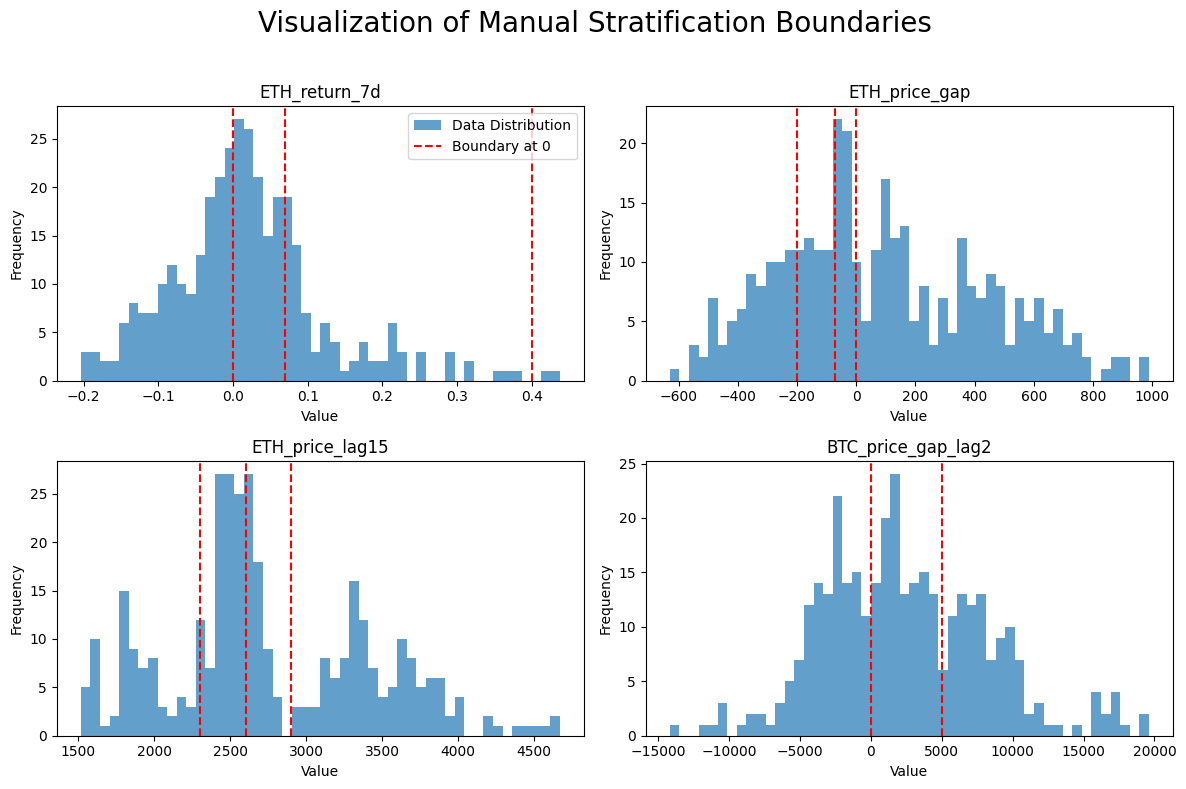

In [50]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# --- 步驟 3: 視覺化四個變數的分層邊界 ---
# 創建一個 2x2 的子圖畫布，figsize 用來調整整體大小
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Visualization of Manual Stratification Boundaries', fontsize=20)

# 1. ETH_return_7d
ax = axes[0, 0]
ax.hist(df['ETH_return_7d'], bins=50, alpha=0.7, label='Data Distribution')
boundaries = [0, 0.07, 0.4]
for b in boundaries:
    ax.axvline(x=b, color='r', linestyle='--', label=f'Boundary at {b}' if b == boundaries[0] else "")
ax.set_title('ETH_return_7d')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.legend()

# 2. ETH_price_gap
ax = axes[0, 1]
ax.hist(df['ETH_price_gap'], bins=50, alpha=0.7)
boundaries = [-200, -70, 0]
for b in boundaries:
    ax.axvline(x=b, color='r', linestyle='--')
ax.set_title('ETH_price_gap')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

# 3. ETH_price_lag15
ax = axes[1, 0]
ax.hist(df['ETH_price_lag15'], bins=50, alpha=0.7)
boundaries = [2300, 2600, 2900]
for b in boundaries:
    ax.axvline(x=b, color='r', linestyle='--')
ax.set_title('ETH_price_lag15')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

# 4. BTC_price_gap_lag2
ax = axes[1, 1]
ax.hist(df['BTC_price_gap_lag2'], bins=50, alpha=0.7)
boundaries = [0, 5000]
for b in boundaries:
    ax.axvline(x=b, color='r', linestyle='--')
ax.set_title('BTC_price_gap_lag2')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

# 自動調整子圖間距，避免標題重疊
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 📊 Minting Delta (`mint_diff`) Layering Logic

### KMeans Cluster Centers

```text
Cluster Centers:
[ -7.3e+07, -2.1e+07, 2.3e+06, 2.0e+07, 6.5e+07 ]
```

### Final Manual Layering (5 Tiers)

| Label Name         | Condition Description                      |
|--------------------|---------------------------------------------|
| `mint_collapse_hard` | `mint_diff <= -21.5M`                     |
| `mint_collapse_mid`  | `-21.5M < mint_diff <= -2.3M`             |
| `mint_collapse_none` | `-2.3M < mint_diff <= 3.0M`               |
| `mint_expand_mid`    | `3.0M < mint_diff <= 20M`                 |
| `mint_expand_strong` | `mint_diff > 20M`                         |

### Column Naming

```python
df['mint_collapse_hard']
df['mint_collapse_mid']
df['mint_collapse_none']
df['mint_expand_mid']
df['mint_expand_strong']
```

In [51]:
df['mint_diff'] = df['USDe_NET_MINT'].diff().shift(-1)
print(df.head(),'\n')
quantiles = df.quantile([0.2, 0.4, 0.6, 0.8, 1.0])
print(quantiles)

          date  USDe_NET_MINT  ETH_return_7d  ETH_price_gap  ETH_price_lag15  \
15  2024-09-17  -1.403737e+07      -0.013224    -158.793160      2494.741771   
16  2024-09-18  -2.999693e+06      -0.007684    -151.801388      2491.719583   
17  2024-09-19  -6.044637e+06       0.034477     -30.815022      2415.985104   
18  2024-09-20  -3.495873e+06       0.063467      67.858009      2399.656979   
19  2024-09-21  -4.246054e+06       0.057270      97.692712      2323.583681   

    BTC_price_gap_lag2  rev_return_high  rev_return_mid  rev_return_low  \
15          968.291954                0               0               0   
16         -660.089631                0               0               0   
17          359.427028                0               0               1   
18         1101.628759                0               0               1   
19         3509.061214                0               0               1   

    rev_gap_high  rev_gap_mid  rev_gap_low  rev_lag15_low  rev_lag15

In [52]:
# 人工分層標記
df['mint_collapse_hard'] = (df['mint_diff'] <= -2.15e7).astype(int)   # 劇烈贖回
df['mint_collapse_mid']  = ((df['mint_diff'] > -2.15e7) & (df['mint_diff'] <= -2.3e6)).astype(int)  # 中度贖回
df['mint_collapse_none'] = ((df['mint_diff'] > -2.3e6) & (df['mint_diff'] <= 3.0e6)).astype(int)    # 無變化
df['mint_expand_mid']    = ((df['mint_diff'] > 3.0e6) & (df['mint_diff'] <= 2.0e7)).astype(int)     # 中度鑄造
df['mint_expand_strong'] = (df['mint_diff'] > 2.0e7).astype(int)     # 強力鑄造

In [53]:
print(len(df[df['mint_collapse_hard'] == 1]))

67


## 📈 補充：mint_diff 分群視覺化（直方圖）

## 📈 Visualizing `mint_diff` Clusters

[[-4.67183645e+06]
 [ 2.58580899e+08]
 [-2.73218593e+08]
 [-1.16403991e+08]
 [ 5.82861052e+07]]


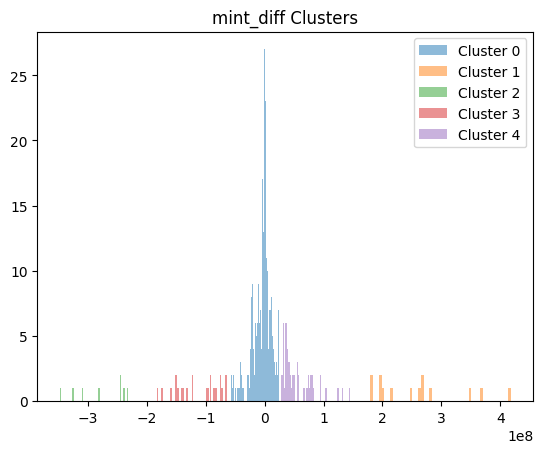

In [54]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Step 1: 去除 NaN 前的索引
non_nan_idx = df['mint_diff'].dropna().index

# Step 2: 取出非 NaN 資料做分群
X = df.loc[non_nan_idx, 'mint_diff'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)

# Step 3: 建一欄預設為 NaN，並對回非 NaN 的群集標籤
df['mint_cluster'] = np.nan
df.loc[non_nan_idx, 'mint_cluster'] = kmeans.labels_

# # 只用 mint_diff 進行 1D 分群
# X = df['mint_diff'].dropna().values.reshape(-1, 1)
# kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
# df['mint_cluster'] = kmeans.labels_

# 查看每群的中心
print(kmeans.cluster_centers_)

# 可視化分群
plt.hist(df[df['mint_cluster']==0]['mint_diff'], bins=50, alpha=0.5, label='Cluster 0')
plt.hist(df[df['mint_cluster']==1]['mint_diff'], bins=50, alpha=0.5, label='Cluster 1')
plt.hist(df[df['mint_cluster']==2]['mint_diff'], bins=50, alpha=0.5, label='Cluster 2')
plt.hist(df[df['mint_cluster']==3]['mint_diff'], bins=50, alpha=0.5, label='Cluster 3')
plt.hist(df[df['mint_cluster']==4]['mint_diff'], bins=50, alpha=0.5, label='Cluster 4')
plt.legend()
plt.title('mint_diff Clusters')
plt.show()


## 🧪 KMeans Clustering Trials (Deprecated)

We initially used KMeans clustering to extract breakpoints per feature. Example:

```python
kmeans_ret, centers, bounds = cluster_labeling(df['ETH_return_7d'], n_clusters=3, prefix='rev_return')
# Boundaries example: [-0.03, 0.13]
```

Due to high central concentration of samples, KMeans led to **unbalanced sample sizes**, hence we moved to manual quantile splits.

In [55]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_labeling(series, n_clusters=3, prefix="cluster"):
    X = series.values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    centers = np.sort(kmeans.cluster_centers_.flatten())

    # 計算分界點
    boundaries = [(centers[i] + centers[i + 1]) / 2 for i in range(len(centers) - 1)]

    # 建立分層標記欄位
    labels = []
    for i in range(len(boundaries) + 1):
        if i == 0:
            labels.append((series <= boundaries[0]).astype(int))
        elif i == len(boundaries):
            labels.append((series > boundaries[-1]).astype(int))
        else:
            labels.append(((series > boundaries[i - 1]) & (series <= boundaries[i])).astype(int))

    # 加入到 df 中
    for i, label in enumerate(labels):
        df[f"{prefix}_{i}"] = label

    return kmeans, centers, boundaries

# ETH_return_7d → 可分為 3 群
kmeans_ret, centers_ret, bounds_ret = cluster_labeling(df['ETH_return_7d'], n_clusters=3, prefix='rev_return')
print(kmeans_ret.cluster_centers_)

# ETH_price_gap → 可分為 3 群
kmeans_ret, centers_gap, bounds_gap = cluster_labeling(df['ETH_price_gap'], n_clusters=3, prefix='rev_gap')
print(kmeans_ret.cluster_centers_)

# ETH_price_lag15 → 可分為 4 群
kmeans_ret, centers_lag, bounds_lag = cluster_labeling(df['ETH_price_lag15'], n_clusters=4, prefix='rev_lag15')
print(kmeans_ret.cluster_centers_)

# BTC_price_gap_lag2 → 可分為 3 群
kmeans_ret, centers_btcgap, bounds_btcgap = cluster_labeling(df['BTC_price_gap_lag2'], n_clusters=3, prefix='rev_btcgap')
print(kmeans_ret.cluster_centers_)


[[ 0.03520281]
 [ 0.24572421]
 [-0.09129147]]
[[-216.41518529]
 [ 581.24949865]
 [ 158.7127886 ]]
[[3269.0188483 ]
 [1820.65628307]
 [2529.22553584]
 [3864.57564429]]
[[ 6116.25216471]
 [-1906.80510987]
 [15058.79373416]]


In [56]:
# # 集群分析後的分層標記

# # ETH_return_7d（分界點：-0.03276, 0.13180）
# df['rev_return_low']  = (df['ETH_return_7d'] <= -0.03276).astype(int)
# df['rev_return_mid']  = ((df['ETH_return_7d'] > -0.03276) & (df['ETH_return_7d'] <= 0.13180)).astype(int)
# df['rev_return_high'] = (df['ETH_return_7d'] > 0.13180).astype(int)

# # ETH_price_gap（分界點：-129.39, 284.36）
# df['rev_gap_high'] = (df['ETH_price_gap'] <= -129.39).astype(int)
# df['rev_gap_mid']  = ((df['ETH_price_gap'] > -129.39) & (df['ETH_price_gap'] <= 284.36)).astype(int)
# df['rev_gap_low']  = (df['ETH_price_gap'] > 284.36).astype(int)

# # ETH_price_lag15（分界點：2197.31, 2987.06, 3831.59）
# df['rev_lag15_low']      = (df['ETH_price_lag15'] <= 2197.31).astype(int)
# df['rev_lag15_midlow']   = ((df['ETH_price_lag15'] > 2197.31) & (df['ETH_price_lag15'] <= 2987.06)).astype(int)
# df['rev_lag15_midhigh']  = ((df['ETH_price_lag15'] > 2987.06) & (df['ETH_price_lag15'] <= 3831.59)).astype(int)
# df['rev_lag15_high']     = (df['ETH_price_lag15'] > 3831.59).astype(int)

# # BTC_price_gap_lag2（分界點：-558.41, 6211.46）
# df['rev_btcgap_low']  = (df['BTC_price_gap_lag2'] <= -558.41).astype(int)
# df['rev_btcgap_mid']  = ((df['BTC_price_gap_lag2'] > -558.41) & (df['BTC_price_gap_lag2'] <= 6211.46)).astype(int)
# df['rev_btcgap_high'] = (df['BTC_price_gap_lag2'] > 6211.46).astype(int)


In [57]:
# # 集群分析後的分層標記
# df['mint_collapse_hard'] = (df['mint_diff'] <= -2.682e+07).astype(int) # 劇烈贖回
# df['mint_collapse_none'] = ((df['mint_diff'] > -2.682e+07) & (df['mint_diff'] <= 6.108e+07)).astype(int) # 正常範圍
# df['mint_expand_strong'] = (df['mint_diff'] > 6.108e+07).astype(int) # 強力鑄造

## ✅ Conclusion

- **Manual quantile-based layering** provides more consistent sample control, especially for **detecting extreme behaviors** (e.g., sharp redemption or aggressive minting).
- **KMeans can help infer boundaries**, but is unreliable when feature distribution is skewed or normal-like.
- **This preprocessing layer** forms a solid foundation for anomaly detection, behavior modeling, and governance alert systems.

# 🧠 Collapse Event Prediction Models

## 🔍 Cross-Tab Analysis: Event Features vs Collapse Outcomes

In this section, we perform a cross-tabulation between:

- 📌 Event Features (Cause): ETH / BTC return bands, gap percentiles, lag-15 features, etc.
- 📌 Collapse Outcome (Effect): `mint_collapse_hard`

Goal:  
Observe how different market conditions (e.g., high return, extreme gap) influence the likelihood of a Extreme Redemption Event.


In [58]:
# 定義事件標籤（cause）
event_cols = [
    'rev_return_high', 'rev_return_mid', 'rev_return_low',
    'rev_gap_high', 'rev_gap_mid', 'rev_gap_low',
    'rev_lag15_low', 'rev_lag15_midlow', 'rev_lag15_midhigh', 'rev_lag15_high',
    'rev_btcgap_low', 'rev_btcgap_mid', 'rev_btcgap_high'
]

# 定義結果標籤（effect）
result_cols = [
    'mint_collapse_hard'#, 'mint_collapse_mid',
    # 'mint_collapse_none', 'mint_expand_mid', 'mint_expand_strong'
]

# 執行所有事件 x 結果交叉分析
for event in event_cols:
    for result in result_cols:
        print(f"\n🔍 Event: {event} → Result: {result}")
        print(pd.crosstab(df[event], df[result], normalize='index'))




🔍 Event: rev_return_high → Result: mint_collapse_hard
mint_collapse_hard         0         1
rev_return_high                       
0                   0.807471  0.192529
1                   1.000000  0.000000

🔍 Event: rev_return_mid → Result: mint_collapse_hard
mint_collapse_hard         0         1
rev_return_mid                        
0                   0.837037  0.162963
1                   0.712500  0.287500

🔍 Event: rev_return_low → Result: mint_collapse_hard
mint_collapse_hard         0         1
rev_return_low                        
0                   0.786325  0.213675
1                   0.853448  0.146552

🔍 Event: rev_gap_high → Result: mint_collapse_hard
mint_collapse_hard         0         1
rev_gap_high                          
0                   0.783088  0.216912
1                   0.897436  0.102564

🔍 Event: rev_gap_mid → Result: mint_collapse_hard
mint_collapse_hard         0         1
rev_gap_mid                           
0                   0.801980  0.

### 📊 Visualizing Collapse Likelihood by Feature Level

This bar chart shows the probability of `mint_collapse_hard` across different feature groups and levels:

- Groups: ETH_Lag15, ETH_Gap, ETH_Return, BTC_Gap
- Levels: Low / Mid / High (or quartiles)

Purpose:  
To identify which feature conditions are most predictive of high-risk collapse events, and whether any segments exhibit sharp risk jumps (e.g., ETH_Lag15 → High).


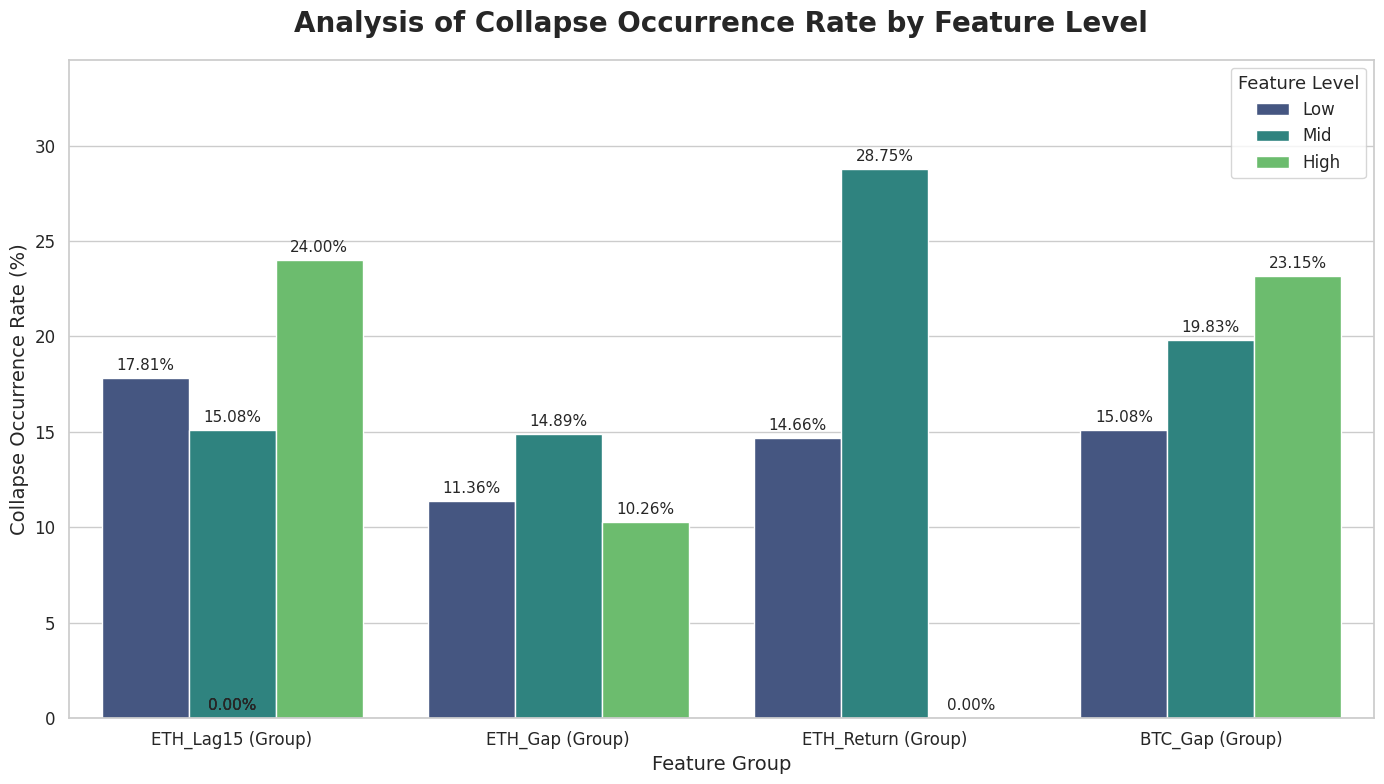

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 整理資料 ---
# 將您的資料建成一個 DataFrame
data = {
    'Feature Group': ['ETH_Lag15 (Group)', 'ETH_Gap (Group)', 'ETH_Return (Group)', 'BTC_Gap (Group)'],
    'Low': [17.81, 11.36, 14.66, 15.08],
    'Mid': [15.08, 14.89, 28.75, 19.83],
    'High': [24.00, 10.26, 0.00, 23.15]
}
df_plot = pd.DataFrame(data)

# 將 DataFrame 轉換為 "長格式"，這是 Seaborn 繪圖最理想的格式
df_melted = df_plot.melt(id_vars='Feature Group',
                    var_name='Feature Level',
                    value_name='Collapse Occurrence Rate (%)')

# --- 2. 繪製圖表 ---
# 設定圖表風格與字體 (若您環境無此字體，可更換或移除)
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 使用微軟正黑體
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

plt.figure(figsize=(14, 8))

# 使用 seaborn 繪製分組長條圖
ax = sns.barplot(
    x='Feature Group',
    y='Collapse Occurrence Rate (%)',
    hue='Feature Level',
    data=df_melted,
    palette='viridis' # 選用一個視覺效果好的調色盤
)

# 在每個長條上方加上數值標籤
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=11)

# --- 3. 美化圖表 ---
# 設定標題與座標軸標籤
plt.title('Analysis of Collapse Occurrence Rate by Feature Level', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Feature Group', fontsize=14)
plt.ylabel('Collapse Occurrence Rate (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the Y-axis limit to make space for the labels on top
plt.ylim(0, df_melted['Collapse Occurrence Rate (%)'].max() * 1.2)

# Adjust the legend
plt.legend(title='Feature Level', title_fontsize='13', fontsize='12', loc='upper right')

# Apply a tight layout to ensure everything fits
plt.tight_layout()

# Display the chart
plt.show()

### 🧠 Conclusion: Which Feature Conditions Signal Higher Collapse Risk?

Based on the 13 crosstab comparisons between **event features** and the outcome `mint_collapse_hard`, we draw the following insights:

- ✅ **Highest observed collapse risks:**
  - `rev_return_mid=1`: 28.75% hard collapse occurrence  
  - `rev_lag15_high=1`: 24.00%  
  - `rev_btcgap_high=1`: 23.15%  
  - `rev_return_high=0`: 19.25%

- 🔄 **Risk distribution is non-linear** and not strictly monotonic:
  - In `ETH_return`, the **mid return group** has the **highest collapse rate**, even more than extreme highs/lows.
  - In `ETH_lag15`, the “high” group shows elevated risk, but overall the trend is inconsistent.

- ❗ **BTC gap features show secondary predictive value** – only in extreme deviations do they correlate with elevated risk, implying their role as **supporting signals** rather than primary drivers.

## 🧠 Multivariate Logistic Regression

This code implements a multivariate logistic regression model to predict the probability of a **Extreme Redemption Event** (`mint_collapse_hard = 1`).

Features used include:
- ETH return levels (high/mid/low)
- ETH price gap levels
- ETH lag-15 price levels
- BTC price gap (lag2)

The model uses `class_weight='balanced'` to handle class imbalance. It evaluates multiple thresholds (0.1–0.9) and tracks precision, recall, F1-score, and accuracy to identify the optimal threshold. Finally, the results are visualized as evaluation curves.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


門檻 0.10
🔍 Confusion Matrix:
[[ 0 57]
 [ 0 13]]
📈 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.19      1.00      0.31        13

    accuracy                           0.19        70
   macro avg       0.09      0.50      0.16        70
weighted avg       0.03      0.19      0.06        70


門檻 0.20
🔍 Confusion Matrix:
[[ 0 57]
 [ 0 13]]
📈 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.19      1.00      0.31        13

    accuracy                           0.19        70
   macro avg       0.09      0.50      0.16        70
weighted avg       0.03      0.19      0.06        70


門檻 0.30
🔍 Confusion Matrix:
[[ 1 56]
 [ 0 13]]
📈 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.03        57
           1      

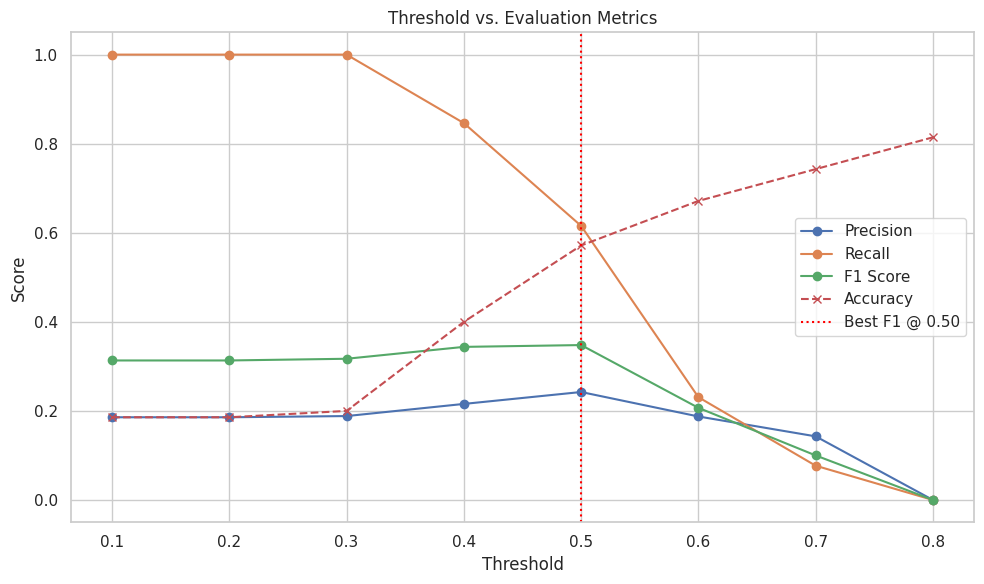


✅ Best F1-score: 0.3478 at threshold = 0.50


In [60]:
# 多變數邏輯回歸

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import pandas as pd

# 🔍 補全所有特徵
logic_features = [
    # ETH return levels
    'rev_return_high', 'rev_return_mid', 'rev_return_low',

    # ETH gap
    'rev_gap_high', 'rev_gap_mid', 'rev_gap_low',

    # ETH lag15
    'rev_lag15_low', 'rev_lag15_midlow', 'rev_lag15_midhigh', 'rev_lag15_high',

    # BTC price gap (lag2)
    'rev_btcgap_low', 'rev_btcgap_mid', 'rev_btcgap_high'
]

X = df[logic_features]
y = df['mint_collapse_hard']

# 刪除缺失值
valid_idx = X.join(y).dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# 分訓練測試集（stratify 保持分布比例）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 建立 Logistic 模型，使用 balanced 權重
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# 門檻區間
thresholds = np.arange(0.1, 0.9, 0.1)

# 取得預測機率
y_proba = model.predict_proba(X_test)[:, 1]

# 儲存評估指標
precision_list, recall_list, f1_list, accuracy_list = [], [], [], []

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)

    # 儲存指標
    precision_list.append(precision_score(y_test, y_pred, zero_division=0))
    recall_list.append(recall_score(y_test, y_pred, zero_division=0))
    f1_list.append(f1_score(y_test, y_pred, zero_division=0))
    accuracy_list.append(accuracy_score(y_test, y_pred))


    # 印出評估報告
    print(f"\n門檻 {thresh:.2f}")
    print("🔍 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("📈 Classification Report:")
    print(classification_report(y_test, y_pred))

# 找最佳 F1-score 的門檻
best_idx = np.argmax(f1_list)
best_thresh = thresholds[best_idx]
best_f1 = f1_list[best_idx]

# 📊 視覺化
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision', marker='o')
plt.plot(thresholds, recall_list, label='Recall', marker='o')
plt.plot(thresholds, f1_list, label='F1 Score', marker='o')
plt.plot(thresholds, accuracy_list, label='Accuracy', linestyle='--', marker='x')

plt.axvline(best_thresh, color='red', linestyle=':', label=f'Best F1 @ {best_thresh:.2f}')
plt.title('Threshold vs. Evaluation Metrics')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🔚 顯示最佳結果
print(f"\n✅ Best F1-score: {best_f1:.4f} at threshold = {best_thresh:.2f}")

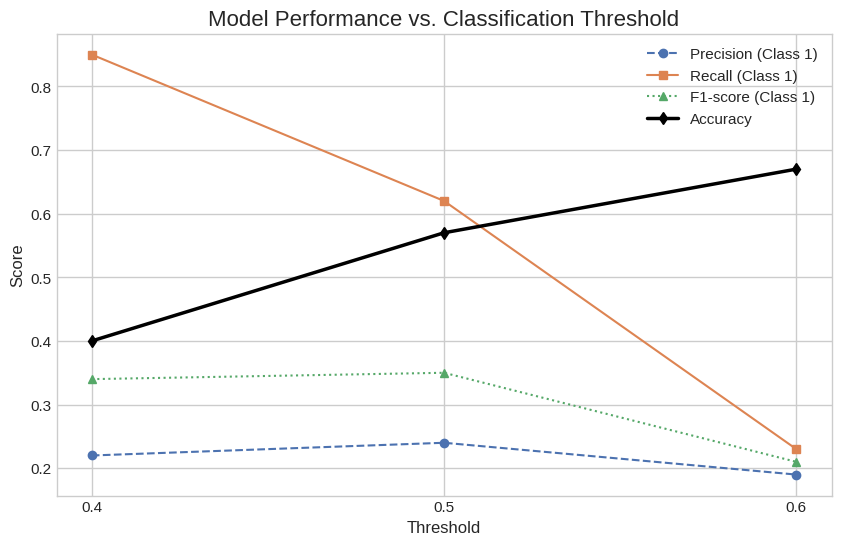

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 整理你的數據
thresholds = [0.40, 0.50, 0.60]

# Class 1 的指標 (通常是我們最關心的)
precision_1 = [0.22, 0.24, 0.19]
recall_1 = [0.85, 0.62, 0.23]
f1_score_1 = [0.34, 0.35, 0.21]

# 全局指標
accuracy = [0.40, 0.57, 0.67]

# 2. 繪製圖表
plt.style.use('seaborn-v0_8-whitegrid') # 使用好看的風格
plt.figure(figsize=(10, 6))

plt.plot(thresholds, precision_1, marker='o', linestyle='--', label='Precision (Class 1)')
plt.plot(thresholds, recall_1, marker='s', linestyle='-', label='Recall (Class 1)')
plt.plot(thresholds, f1_score_1, marker='^', linestyle=':', label='F1-score (Class 1)')
plt.plot(thresholds, accuracy, marker='d', linestyle='-', lw=2.5, color='black', label='Accuracy')

# 3. 美化圖表
plt.title('Model Performance vs. Classification Threshold', fontsize=16)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(thresholds) # 確保 X 軸只顯示我們的門檻值
plt.legend(fontsize=11)
plt.grid(True)
plt.show()

### ✅ Conclusion Summary

In this multivariate logistic regression analysis, the model's performance was evaluated across thresholds from 0.1 to 0.8. Results indicate:

- **Low thresholds (0.1 ~ 0.3):** High recall but extremely low precision — the model over-predicts collapse events, leading to excessive false alarms.
- **Medium thresholds (0.4 ~ 0.6):** A better balance is achieved. The **optimal F1-score (~0.35) occurs at threshold 0.5**, offering the best trade-off between precision and recall.
- **High thresholds (0.7 ~ 0.8):** The model rarely predicts a collapse, leading to near-zero recall and completely missing critical events.

**Conclusion:** Threshold selection significantly impacts the model's performance in imbalanced datasets and high-risk predictions. It is recommended to adopt the **threshold with the best F1-score (≈ 0.5)** for practical deployment, balancing sensitivity and specificity.

## 🔍 Feature Group Importance via Random Forest + Permutation

This section builds a multivariate classification model using `RandomForestClassifier` and evaluates the **importance of four feature groups** in predicting `mint_collapse_hard` (extreme redemption events) via **permutation-based group shuffling**.

Step-by-step process:

1. **Define Feature Groups**:
   - `ETH Return`: ETH return levels (high / mid / low)
   - `ETH Gap`: ETH price deviation from moving average
   - `ETH Lag15`: Lagged ETH price features on day 15
   - `BTC Gap`: BTC price deviation from moving average

2. **Modeling & Prediction**:  
   A `RandomForestClassifier` is trained with `class_weight='balanced'`. The F1 score is used as the main performance metric.

3. **Permutation Importance Test**:  
   One group of features is shuffled at a time, and predictions are re-evaluated. The **larger the drop in F1 score**, the more important the feature group is.






### 📌 Analysis Results

| Feature Group | F1 Score Drop |
|----------------|----------------|
| ETH Lag15  | 0.1411                    |
| ETH Gap    | 0.1384                    |
| ETH Return | 0.1170                    |
| BTC Gap    | 0.1160                    |

Observation

- `ETH Lag15` and `ETH Gap` are the most influential feature groups in the model, indicating that the **lagged effect of ETH price** and the **degree of deviation from the moving average** play a significant role in determining the likelihood of extreme redemption events.
- Although `BTC Gap` is slightly less important, it still provides supplementary information, possibly reflecting broader shifts in market risk sentiment.

---

### ✅ Conclusion

In predicting extreme redemption events, the **price momentum of ETH**—especially the **15-day lag effect** and **deviation magnitude**—serves as the most sensitive risk signal for the model. While BTC is not the primary factor, it still contributes a certain level of early-warning capability.


ETH Return 0.11695906432748537
ETH Gap 0.13841500302480336
ETH Lag15 0.14114568188426868
BTC Gap 0.11603861725319214


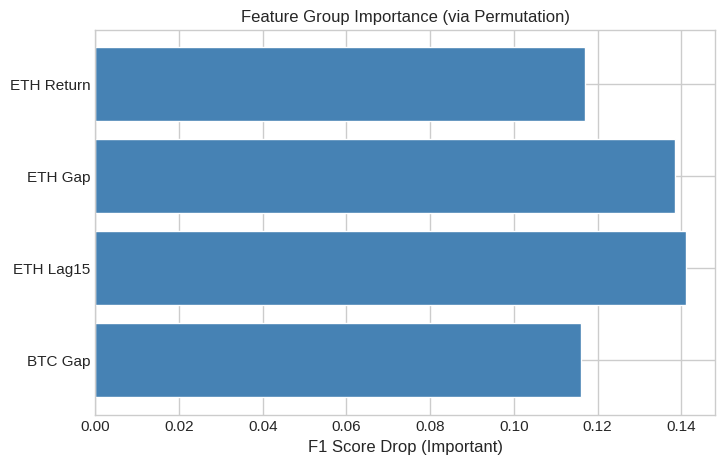

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

# 特徵群定義
group_1 = ['rev_return_high', 'rev_return_mid', 'rev_return_low']
group_2 = ['rev_gap_high', 'rev_gap_mid', 'rev_gap_low']
group_3 = ['rev_lag15_low', 'rev_lag15_midlow', 'rev_lag15_midhigh', 'rev_lag15_high']
group_4 = ['rev_btcgap_low', 'rev_btcgap_mid', 'rev_btcgap_high']

group_names = ['ETH Return', 'ETH Gap', 'ETH Lag15', 'BTC Gap']
group_features = [group_1, group_2, group_3, group_4]

# 組合資料
X = df[group_1 + group_2 + group_3 + group_4].copy()
y = df['mint_collapse_hard']

# 移除 NA
valid_idx = X.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# 建立模型
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X, y)
y_pred = model.predict(X)
baseline_f1 = f1_score(y, y_pred)

# 逐組打亂、評估影響
importances = []
for name, group in zip(group_names, group_features):
    X_permuted = X.copy()
    X_permuted[group] = X_permuted[group].sample(frac=1.0, random_state=42).reset_index(drop=True)  # 打亂這一組
    y_pred_perm = model.predict(X_permuted)
    f1_perm = f1_score(y, y_pred_perm)
    importances.append(baseline_f1 - f1_perm)  # 損失越大，越重要
    print(name, baseline_f1 - f1_perm)

# 視覺化
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(group_names, importances, color='steelblue')
plt.xlabel("F1 Score Drop (Important)")
plt.title("Feature Group Importance (via Permutation)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


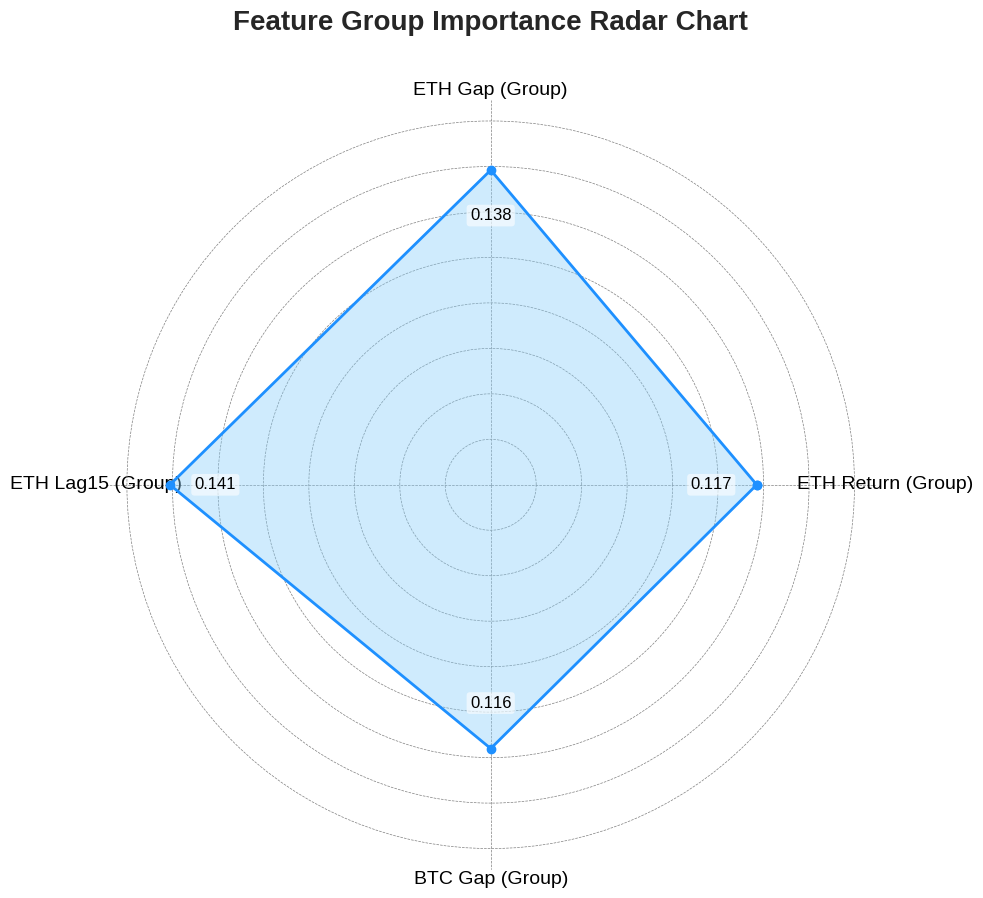

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 資料準備 (Data Preparation) ---
# 原始的特徵重要性資料
group_importances = {
    'ETH Return (Group)': 0.1170,
    'ETH Gap (Group)': 0.1384,
    'ETH Lag15 (Group)': 0.1411,
    'BTC Gap (Group)': 0.1160
}

labels = list(group_importances.keys())
values = list(group_importances.values())
num_vars = len(labels)

# --- 2. 計算雷達圖角度 (Calculate Angles) ---
# 計算每個變數所在的角度
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# 為了讓雷達圖閉合，需要將第一個點的數據和角度追加到最後
values_closed = values + [values[0]]
angles_closed = angles + [angles[0]]

# --- 3. 繪圖與美化 (Plotting & Beautification) ---

# 建立一個極座標子圖，並設定畫布大小，使其更寬敞
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# A. 繪製數據線條與填充區域
# 使用更專業的藍色，並為每個數據點加上標記(marker)，讓數值點更清晰
ax.plot(angles_closed, values_closed, color='dodgerblue', linewidth=2, linestyle='solid', marker='o', label='Importance')
# 使用透明度較高的淺藍色填充
ax.fill(angles_closed, values_closed, color='lightskyblue', alpha=0.4)

# B. 調整網格線
# 將網格線變淡、變成虛線，讓視覺更集中在數據上
ax.grid(color='grey', linestyle='--', linewidth=0.5)

# C. 調整徑向軸 (Y軸)
# 設定 Y 軸的範圍，讓圖形不要頂到最外圈，增加視覺上的留白
max_value = max(values)
ax.set_ylim(0, max_value * 1.2)
# 移除預設的 Y 軸刻度標籤 (例如 0.02, 0.04...)，保持圖面簡潔
ax.set_yticklabels([])

# D. 調整角度軸 (X軸) 的特徵標籤
# 這是顯示 'ETH Return' 等特徵名稱的部分
ax.set_thetagrids(np.degrees(angles), labels, fontsize=14, color='black')

# 【關鍵修正】透過 tick_params 增加標籤與圖表的間距 (padding)
# 這一步解決了原圖中標籤與圖形擠在一起的問題
ax.tick_params(axis='x', which='major', pad=0)

# E. 在數據點附近標示數值
# 【關鍵修正】將數值標示在數據點的稍微「外側」，並加上白色半透明背景，避免與線條重疊
for angle, value in zip(angles, values):
    ax.text(angle, value - 0.02, f'{value:.3f}',
            ha='center', va='center', color='black', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

# F. 設定標題
# 調整 y 的值將標題向上移動，增加 fontweight 讓標題更突出
ax.set_title("Feature Group Importance Radar Chart", y=1.08, fontsize=20, fontweight='bold')

# G. 移除最外圈的黑框，讓圖表更簡潔
ax.spines['polar'].set_visible(False)

# 顯示圖表
plt.show()

# 📊 Risk Factor Contribution Analysis During Collapse Events  

This code analyzes which **feature groups** are more frequently triggered during **extreme redemption events (`mint_collapse_hard = 1`)**, helping us identify key drivers behind collapse scenarios.

Steps:  
1. **Filter risk events**: Select only rows where `mint_collapse_hard = 1`.  
2. **Count feature group activations**: For each feature group, if any feature within the group is marked as 1, that group is considered triggered in that event.  
3. **Visualization**: Plot a bar chart to show how many times each feature group was triggered across all collapse events, with a note of the total event count.  

---

## 📌 Analysis Results  

The statistics show:  

- `BTC Gap`: **67 triggers**  
- `ETH Lag15`: **67 triggers**  
- `ETH Return`: **40 triggers**  
- `ETH Gap`: **20 triggers**  

---


## ✅ Conclusion

- BTC Gap and ETH Lag15 are the most frequently triggered groups during collapse events, highlighting them as the strongest risk drivers. ETH Return comes next, while ETH Gap shows the least impact, suggesting it plays only a marginal role.  

---


BTC Gap       67
ETH Lag15     67
ETH Return    40
ETH Gap       20
dtype: int64


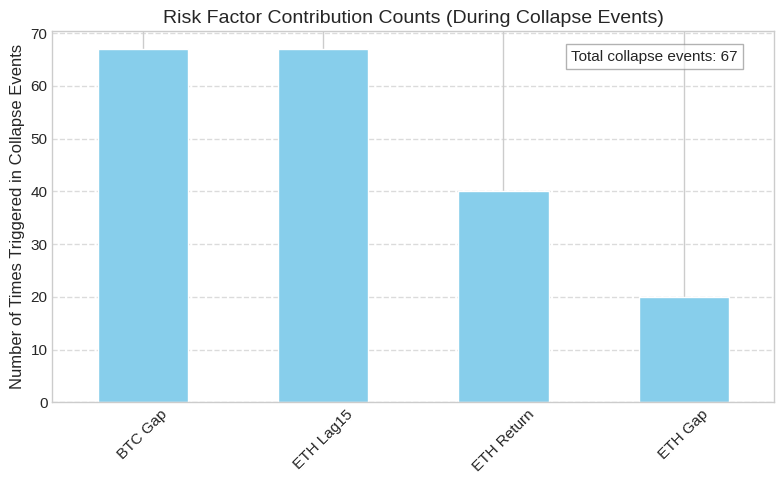

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設你的資料是 df，包含 collapse 與各特徵
# 定義 group
feature_groups = {
    'ETH Return': ['rev_return_high', 'rev_return_mid', 'rev_return_low'],
    'ETH Gap': ['rev_gap_high', 'rev_gap_mid', 'rev_gap_low'],
    'ETH Lag15': ['rev_lag15_low', 'rev_lag15_midlow', 'rev_lag15_midhigh', 'rev_lag15_high'],
    'BTC Gap': ['rev_btcgap_low', 'rev_btcgap_mid', 'rev_btcgap_high']
}

# 1. 篩出風險事件（collapse = 1）
risk_df = df[df['mint_collapse_hard'] == 1].copy()
total_collapse_count = len(risk_df)

# 2. 統計每個 group 在多少次風險事件中出現過
group_risk_counts = {}

for group_name, features in feature_groups.items():
    # 對每列，看是否該 group 任一欄為 1（代表此 group 被觸發）
    group_triggered = risk_df[features].sum(axis=1) > 0
    group_risk_counts[group_name] = group_triggered.sum()  # 加總 True 的個數




# 3. 繪製條圖
group_risk_series = pd.Series(group_risk_counts)
group_risk_series = group_risk_series.sort_values(ascending=False)
print(group_risk_series)
plt.figure(figsize=(8, 5))

# 加上總 collapse 次數註解
plt.text(0.95, 0.95, f'Total collapse events: {total_collapse_count}',
         transform=plt.gca().transAxes,
         ha='right', va='top',
         fontsize=11, bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))


group_risk_series.plot(kind='bar', color='skyblue')
plt.title("Risk Factor Contribution Counts (During Collapse Events)", fontsize=14)
plt.ylabel("Number of Times Triggered in Collapse Events", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 🌲 Feature Importance Analysis (1-Day Lag Validation)

This code applies a **Random Forest classifier** with **Permutation Importance** to evaluate the predictive power of features in forecasting **next-day extreme redemption events** (`mint_collapse_hard_lag1`).

Steps:  

1. **Lagged Target Creation:**  
   Shift `mint_collapse_hard` by one day to simulate predicting tomorrow’s outcome from today’s features.  

2. **Feature Groups:**  
   - ETH Return (`rev_return_*`)  
   - ETH Gap (`rev_gap_*`)  
   - ETH Lag15 (`rev_lag15_*`)  
   - BTC Gap (`rev_btcgap_*`)  

3. **Model Training & Evaluation:**  
   A Random Forest model was trained with **F1-score** as the main metric.  

4. **Results & Limitations:**  
   - For the **negative class (0)**: Precision/Recall were strong (~0.81 / 0.92).  
   - For the **positive class (1)**: Recall was only 0.10, showing weak ability to detect extreme redemption events.  
   - Overall accuracy reached ~0.76, but detection of rare events was poor.  

5. **Permutation Importance Analysis:**  
   - Features such as `rev_btcgap_high`, `rev_return_low`, `rev_btcgap_mid`, and `rev_return_mid` were most impactful (their shuffling led to significant F1 drops).  
   - In contrast, `rev_gap_mid` and some ETH lag/gap features contributed little to model performance.  

---

### 📊 Conclusion

- The model performs well at predicting **normal cases** but struggles to capture **rare extreme redemption events**.  
- Feature importance highlights **BTC gap features** and **ETH low/mid returns** as the most critical predictors.  
- To improve detection of rare events, future work should explore **data balancing techniques (e.g., oversampling/SMOTE)** or **models tailored for imbalanced datasets (e.g., XGBoost with scale_pos_weight)**.


              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86        85
         1.0       0.22      0.10      0.14        20

    accuracy                           0.76       105
   macro avg       0.52      0.51      0.50       105
weighted avg       0.70      0.76      0.72       105



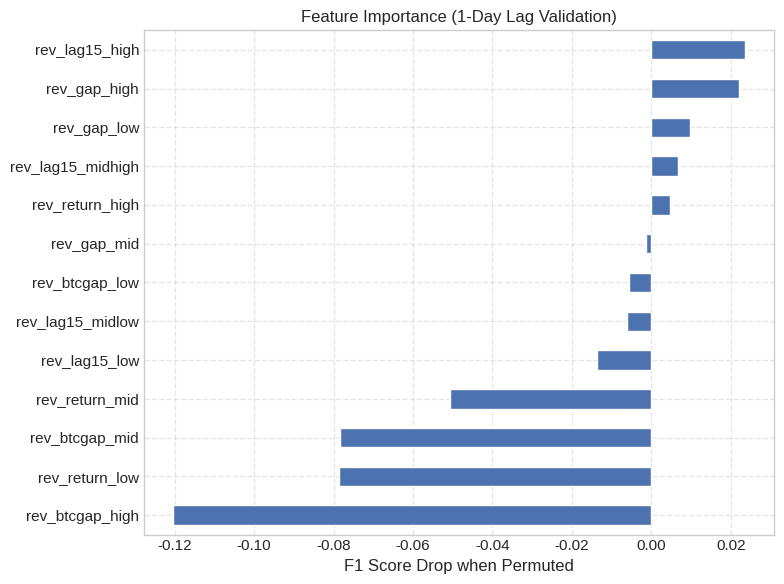

In [65]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# ======================
# 1. 生成延遲一天的目標欄位
# ======================
df['mint_collapse_hard_lag1'] = df['mint_collapse_hard'].shift(-1)
df = df.dropna(subset=['mint_collapse_hard_lag1'])  # 移除尾端空值

# ======================
# 2. 定義特徵與目標欄位
# ======================
features = [
    # ETH return
    'rev_return_high', 'rev_return_mid', 'rev_return_low',

    # ETH gap
    'rev_gap_high', 'rev_gap_mid', 'rev_gap_low',

    # ETH lag15
    'rev_lag15_low', 'rev_lag15_midlow', 'rev_lag15_midhigh', 'rev_lag15_high',

    # BTC gap
    'rev_btcgap_low', 'rev_btcgap_mid', 'rev_btcgap_high'
]

target = 'mint_collapse_hard_lag1'

X = df[features]
y = df[target]

# ======================
# 3. 分割資料集
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ======================
# 4. 建立並訓練模型
# ======================
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ======================
# 5. 預測結果與報表
# ======================
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# ======================
# 6. Permutation Importance 分析
# ======================
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, scoring='f1')

# 顯示條圖
importances = pd.Series(result.importances_mean, index=features)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
importances.plot(kind='barh')
plt.title("Feature Importance (1-Day Lag Validation)")
plt.xlabel("F1 Score Drop when Permuted")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 📊 Visualizing the Early Warning System

## 📈 USDe Net Minting vs ETH Price Deviation  

This code visualizes the relationship between **USDe net minting (USDe_NET_MINT)** and **ETH price deviation (ETH_price_gap)** using a dual-axis chart. It also highlights **potential risk signals** and **actual collapse events**.  

Steps:  

1. **Dual-axis plotting:**  
   - Left Y-axis: plots USDe net minting (blue line).  
   - Right Y-axis: plots ETH price deviation from 30-day moving average (red line, with alpha=0.3).  

2. **Risk signal marking:**  
   - Dates where `ETH_price_gap <= -200` are flagged as risk zones.  
   - These are shown as **red scatter points** on the chart.  

3. **Collapse signal marking:**  
   - If the dataset contains the column `mint_collapse_hard`, all rows with value = 1 are treated as **extreme redemption events**.  
   - These are marked as **black crosses (x)**.  

4. **Chart formatting:**  
   - Uses twin Y-axes for better comparison.  
   - Adds legends, grid, and title for readability.  

---

### 📊 Conclusion

From the chart, we can observe that:  
- **Large ETH price deviations from the moving average (especially below -200) are strongly associated with USDe redemption risk.**  
- **Collapse events (black crosses) tend to cluster around risk signals (red dots), confirming ETH price deviation as an early warning indicator.**  
- This visualization can serve as a core tool for risk monitoring and early warning systems.  


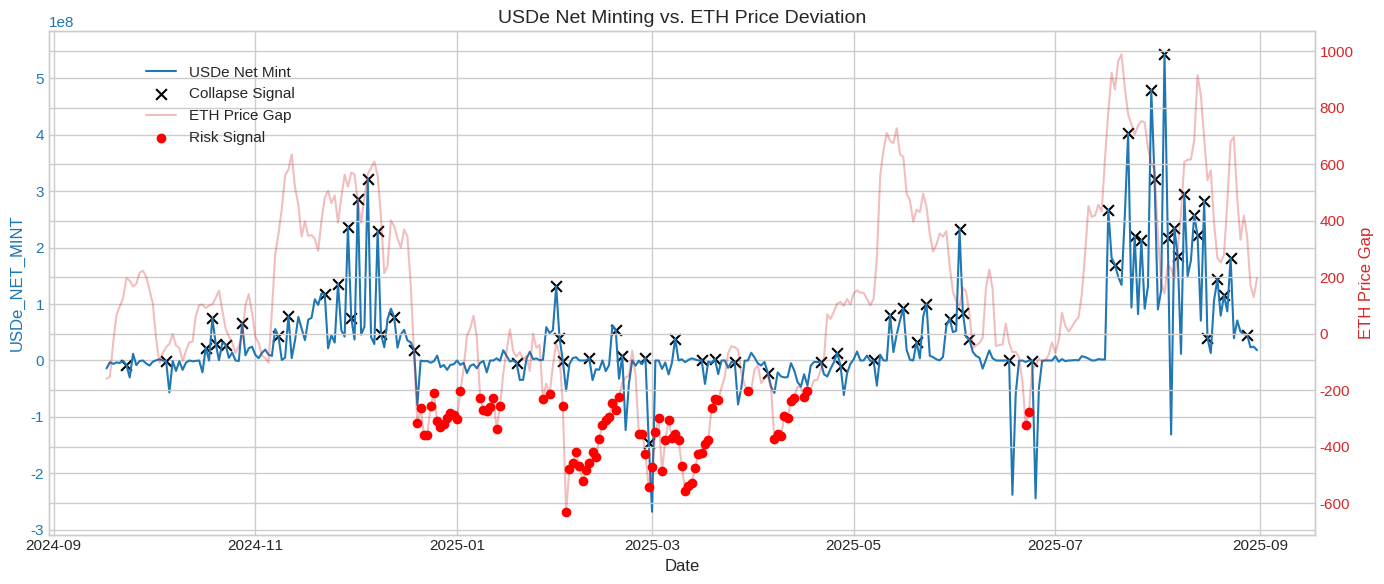

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設 df 已包含所需欄位，並且已依時間排序
# date | USDe_NET_MINT | ETH_price_gap | mint_collapse_hard

fig, ax1 = plt.subplots(figsize=(14, 6))

# 左側 Y 軸：USDe 淨鑄造量
ax1.set_title('USDe Net Minting vs. ETH Price Deviation', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('USDe_NET_MINT', color='tab:blue')
ax1.plot(df['date'], df['USDe_NET_MINT'], label='USDe Net Mint', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 右側 Y 軸：ETH 價格偏離
ax2 = ax1.twinx()
ax2.set_ylabel('ETH Price Gap', color='tab:red')
ax2.plot(df['date'], df['ETH_price_gap'], label='ETH Price Gap', color='tab:red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='tab:red')

# 危險區標點（ETH_gap >= ±200）
# risky_dates = df[(df['ETH_price_gap'] >= 200) | (df['ETH_price_gap'] <= -200)]
risky_dates = df[(df['ETH_price_gap'] <= -200) ]
ax2.scatter(risky_dates['date'], risky_dates['ETH_price_gap'], color='red', label='Risk Signal', zorder=5)

# collapse-hard 事件標記
if 'mint_collapse_hard' in df.columns:
    collapse_dates = df[df['mint_collapse_hard'] == 1]
    ax1.scatter(collapse_dates['date'], collapse_dates['USDe_NET_MINT'],
                color='black', marker='x', s=60, label='Collapse Signal')

# 圖例與格式
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()



## 📊 USDe Net Minting vs. ETH 7-Day Return Analysis  


This code creates a **2x1 subplot** (stacked vertically) to jointly observe **USDe net minting** and **ETH 7-day return**, while marking **collapse events** and **high-risk periods**.  

Steps:  

1. **2x1 subplot with shared X-axis:**  
   - Top chart (ax1): USDe net minting.  
   - Bottom chart (ax2): ETH 7-day return.  
   - Shared time axis for alignment.  

2. **Plotting USDe net minting (top chart):**  
   - Blue line: daily USDe net minting.  
   - Red crosses (x): dates where `mint_collapse_hard = 1`, marking collapse events.  

3. **Plotting ETH 7-day return (bottom chart):**  
   - Green line: ETH 7-day return (percentage format).  
   - Red shaded band: 7%–40%, flagged as the “theoretical high-risk zone.”  

4. **Marking actual high-risk periods:**  
   - Condition: `ETH_return_7d` within 7%–40%.  
   - Identified as continuous blocks of dates, highlighted with **orange vertical spans** in both charts.  

5. **Chart enhancements:**  
   - Added legends for collapse events, theoretical zone, and actual risk periods.  
   - Gridlines and aligned title for better readability.  

---

### 📈 Conclusion  

- **Collapse events (red crosses)** tend to occur within **actual high-risk periods (orange zones)**, confirming that ETH 7-day returns between 7%–40% strongly correlate with redemption risk.  
- The **theoretical threshold (7%–40%)** aligns well with observed data, validating its use as a practical risk indicator.  
- This visualization clearly demonstrates the linkage between **ETH price momentum (ETH_return_7d)** and **USDe liquidity stress (USDe_NET_MINT)**, making it a valuable tool for risk monitoring.  


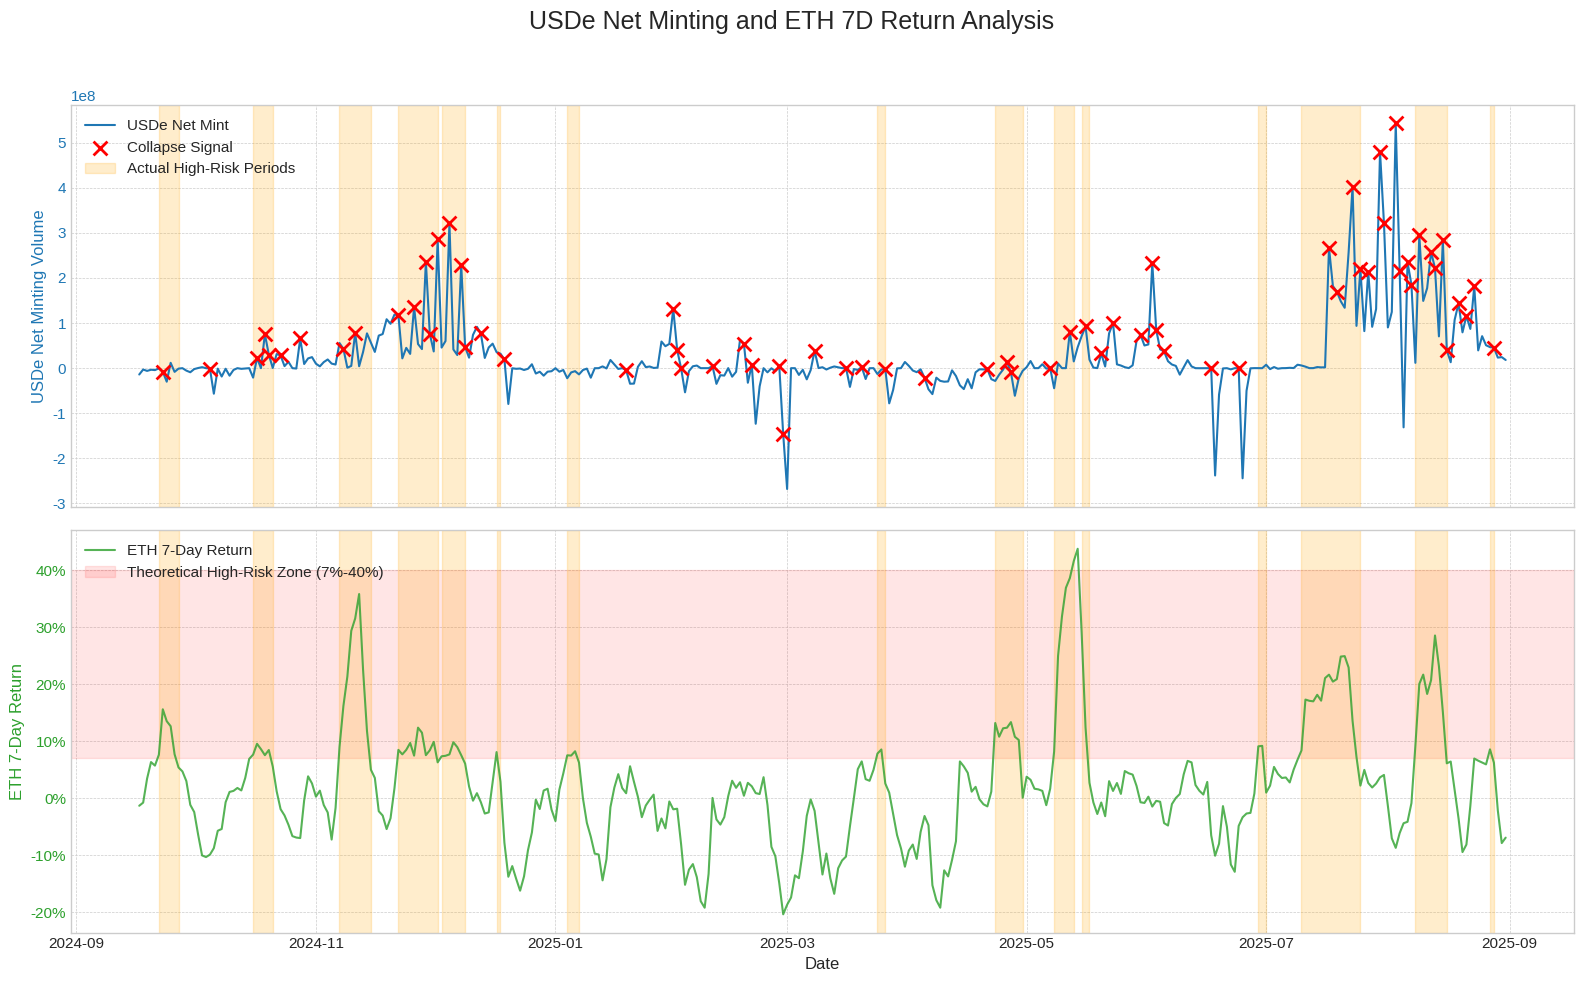

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
import numpy as np


df_plot = df.copy()

# ======================================================================
# 【核心修改 1】: 建立 2x1 的子圖，並共享 X 軸
# ----------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(16, 10),
    sharex=True  # 共享 X 軸，使圖表對齊
)
fig.suptitle('USDe Net Minting and ETH 7D Return Analysis', fontsize=18)

# ======================================================================
# 圖一 (上方): USDe 淨鑄造量
# ----------------------------------------------------------------------
ax1.set_ylabel('USDe Net Minting Volume', color='tab:blue', fontsize=12)
ax1.plot(df_plot['date'], df_plot['USDe_NET_MINT'], label='USDe Net Mint', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在圖一標記 Collapse 事件
collapse_dates = df_plot[df_plot['mint_collapse_hard'] == 1]
if not collapse_dates.empty:
    ax1.scatter(collapse_dates['date'], collapse_dates['USDe_NET_MINT'],
                color='Red', marker='x', s=100, linewidth=2,
                label='Collapse Signal', zorder=10)

# ======================================================================
# 圖二 (下方): ETH 7日報酬率
# ----------------------------------------------------------------------
ax2.set_ylabel('ETH 7-Day Return', color='tab:green', fontsize=12)
ax2.plot(df_plot['date'], df_plot['ETH_return_7d'], label='ETH 7-Day Return', color='tab:green', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在圖二用水平區域標示出 7%-40% 的理論風險區
ax2.axhspan(0.07, 0.40, color='red', alpha=0.1, label='Theoretical High-Risk Zone (7%-40%)')

# ======================================================================
# 【核心修改 2】: 找出連續的高風險日期區間，並在上下圖中用垂直色塊標示
# ----------------------------------------------------------------------
# 1. 標記每一天是否處於高風險
df_plot['is_high_risk'] = (df_plot['ETH_return_7d'] >= 0.07) & (df_plot['ETH_return_7d'] <= 0.40)
# 2. 創建一個'區塊'標籤，每當風險狀態轉變時，標籤+1
df_plot['risk_block'] = (df_plot['is_high_risk'].ne(df_plot['is_high_risk'].shift())).cumsum()
# 3. 篩選出所有高風險的日期
high_risk_periods = df_plot[df_plot['is_high_risk']]

# 4. 對每個連續的風險區塊進行分組，找出起始和結束日期
if not high_risk_periods.empty:
    # 只添加一次圖例標籤
    first_block = True
    for block_num, group in high_risk_periods.groupby('risk_block'):
        start_date = group['date'].min()
        end_date = group['date'].max() + timedelta(days=1) # 讓色塊能完整包含最後一天

        label = 'Actual High-Risk Periods' if first_block else None
        # 在上下兩個圖中都畫出垂直色塊
        ax1.axvspan(start_date, end_date, color='orange', alpha=0.2, label=label)
        ax2.axvspan(start_date, end_date, color='orange', alpha=0.2)
        first_block = False
# ======================================================================


# 整理圖例
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# 調整佈局並顯示圖表
plt.xlabel('Date', fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.96]) # 為 super title 留出空間
plt.show()

## 📉 USDe Net Minting vs ETH Price Gap Analysis  



This code visualizes the relationship between **USDe net minting (USDe_NET_MINT)** and **ETH price deviation from the 30-day moving average (ETH_price_gap)**, marking **collapse events** and **high-risk periods**.  

Steps:  

1. **2x1 subplot with shared X-axis:**  
   - Top chart: USDe net minting.  
   - Bottom chart: ETH price gap.  

2. **Collapse signal marking:**  
   - Rows where `mint_collapse_hard = 1` are treated as **extreme redemption events**.  
   - Shown as **red crosses (x)** in the top chart.  

3. **Theoretical risk zone:**  
   - When `ETH_price_gap <= -200`, ETH price is considered excessively deviated.  
   - Highlighted with a **red horizontal band** in the bottom chart.  

4. **Actual high-risk periods:**  
   - Identify all continuous periods where `ETH_price_gap <= -200`.  
   - Marked with **orange vertical spans** across both charts.  

5. **Chart formatting:**  
   - Includes legends, gridlines, and a zero reference line (gray dashed) for readability.  

---

### 📊 Conclusion  

- **Severe ETH price deviations (<= -200) align closely with actual collapse events, confirming it as a strong early warning signal.**  
- **Collapse events (red crosses)** frequently fall within or near the **orange risk periods**, reinforcing the predictive power of ETH price deviation.  
- Combining **theoretical thresholds** with **empirical high-risk zones** provides both model-driven and data-driven perspectives, making this visualization a valuable tool for risk monitoring.  


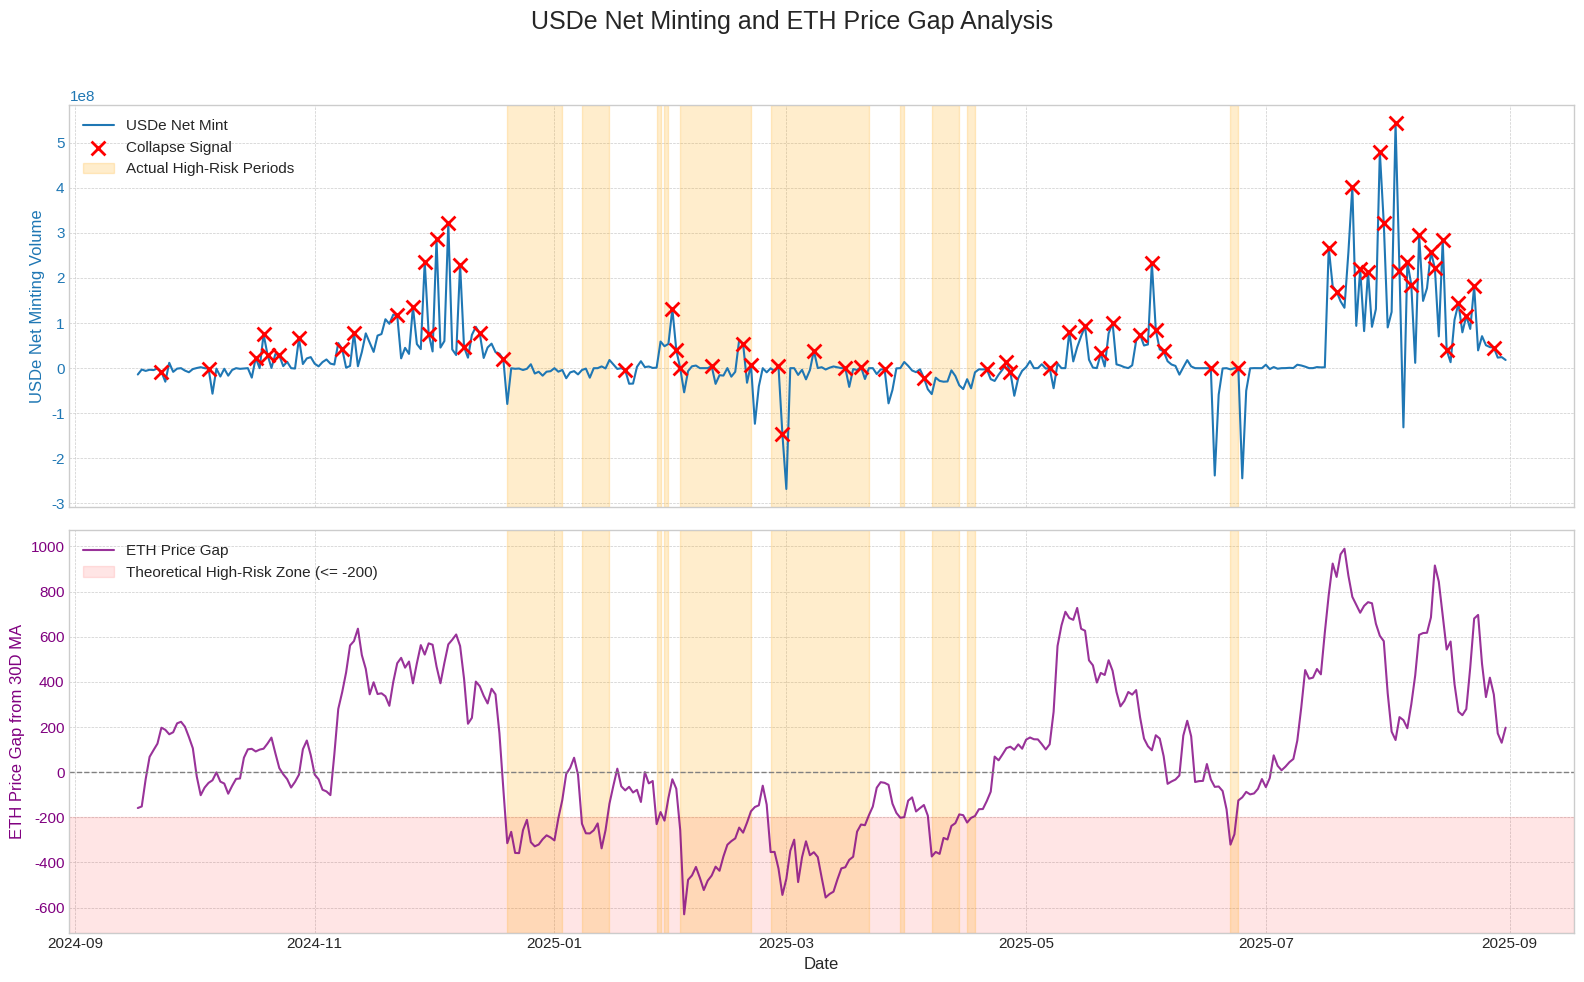

In [68]:
import numpy as np

# 複製一份 DataFrame 以免影響其他圖表
df_plot = df.copy()

# 建立 2x1 的子圖
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharex=True)
fig.suptitle('USDe Net Minting and ETH Price Gap Analysis', fontsize=18)

# 圖一 (上方): USDe 淨鑄造量
ax1.set_ylabel('USDe Net Minting Volume', color='tab:blue', fontsize=12)
ax1.plot(df_plot['date'], df_plot['USDe_NET_MINT'], label='USDe Net Mint', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在圖一標記 Collapse 事件
collapse_dates = df_plot[df_plot['mint_collapse_hard'] == 1]
if not collapse_dates.empty:
    ax1.scatter(collapse_dates['date'], collapse_dates['USDe_NET_MINT'], color='red', marker='x', s=100, linewidth=2, label='Collapse Signal', zorder=10)

# 圖二 (下方): ETH Price Gap
ax2.set_ylabel('ETH Price Gap from 30D MA', color='purple', fontsize=12)
ax2.plot(df_plot['date'], df_plot['ETH_price_gap'], label='ETH Price Gap', color='purple', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='purple')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.axhline(0, color='gray', linestyle='--', linewidth=1) # 添加 0 軸參考線

# 在圖二用水平區域標示出理論風險區
ymin, ymax = ax2.get_ylim() # 先獲取 Y 軸的上下限
ax2.axhspan(ymin, -200, color='red', alpha=0.1, label='Theoretical High-Risk Zone (<= -200)')
ax2.set_ylim(ymin, ymax) # 重新設定 Y 軸上下限，確保 axhspan 不會影響 Y 軸縮放

# 找出連續的高風險日期區間，並在上下圖中用垂直色塊標示
df_plot['is_high_risk'] = (df_plot['ETH_price_gap'] <= -200)
df_plot['risk_block'] = (df_plot['is_high_risk'].ne(df_plot['is_high_risk'].shift())).cumsum()
high_risk_periods = df_plot[df_plot['is_high_risk']]

if not high_risk_periods.empty:
    first_block = True
    for block_num, group in high_risk_periods.groupby('risk_block'):
        start_date = group['date'].min()
        end_date = group['date'].max() + timedelta(days=1)
        label = 'Actual High-Risk Periods' if first_block else None
        ax1.axvspan(start_date, end_date, color='orange', alpha=0.2, label=label)
        ax2.axvspan(start_date, end_date, color='orange', alpha=0.2)
        first_block = False

# 整理圖例與佈局
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
plt.xlabel('Date', fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## ⏳ USDe Net Minting vs ETH Price Lag15 Analysis  



This code compares **USDe net minting (USDe_NET_MINT)** with the **15-day lagged ETH price (ETH_price_lag15)** to explore their relationship. It highlights both **theoretical risk zones** and **actual collapse events**.  

Steps:  

1. **2x1 subplot with shared X-axis:**  
   - Top chart (ax1): USDe net minting.  
   - Bottom chart (ax2): ETH price lagged by 15 days.  

2. **Collapse signal marking:**  
   - Rows where `mint_collapse_hard = 1` are treated as **extreme redemption events**.  
   - Shown as **red crosses (x)** in the top chart.  

3. **Theoretical risk zone:**  
   - When `ETH_price_lag15 > 2900`, this is flagged as a potential risk level.  
   - Highlighted with a **red horizontal band** in the bottom chart.  

4. **Actual high-risk periods:**  
   - Identify all continuous periods where `ETH_price_lag15 > 2900`.  
   - Marked with **orange vertical spans** across both charts.  

5. **Chart formatting:**  
   - Includes legends, gridlines, and titles for better readability.  

---

### 📊 Conclusion  

- **When ETH’s 15-day lagged price exceeds 2900, the likelihood of USDe collapse events increases significantly.**  
- **Collapse events (red crosses)** are often concentrated within or near the **orange risk blocks**, indicating that lagged ETH price levels act as a medium-term pressure factor.  
- By combining **theoretical thresholds** with **empirical high-risk periods**, this visualization provides a strong basis for building **mid-term risk monitoring and early warning models**.  


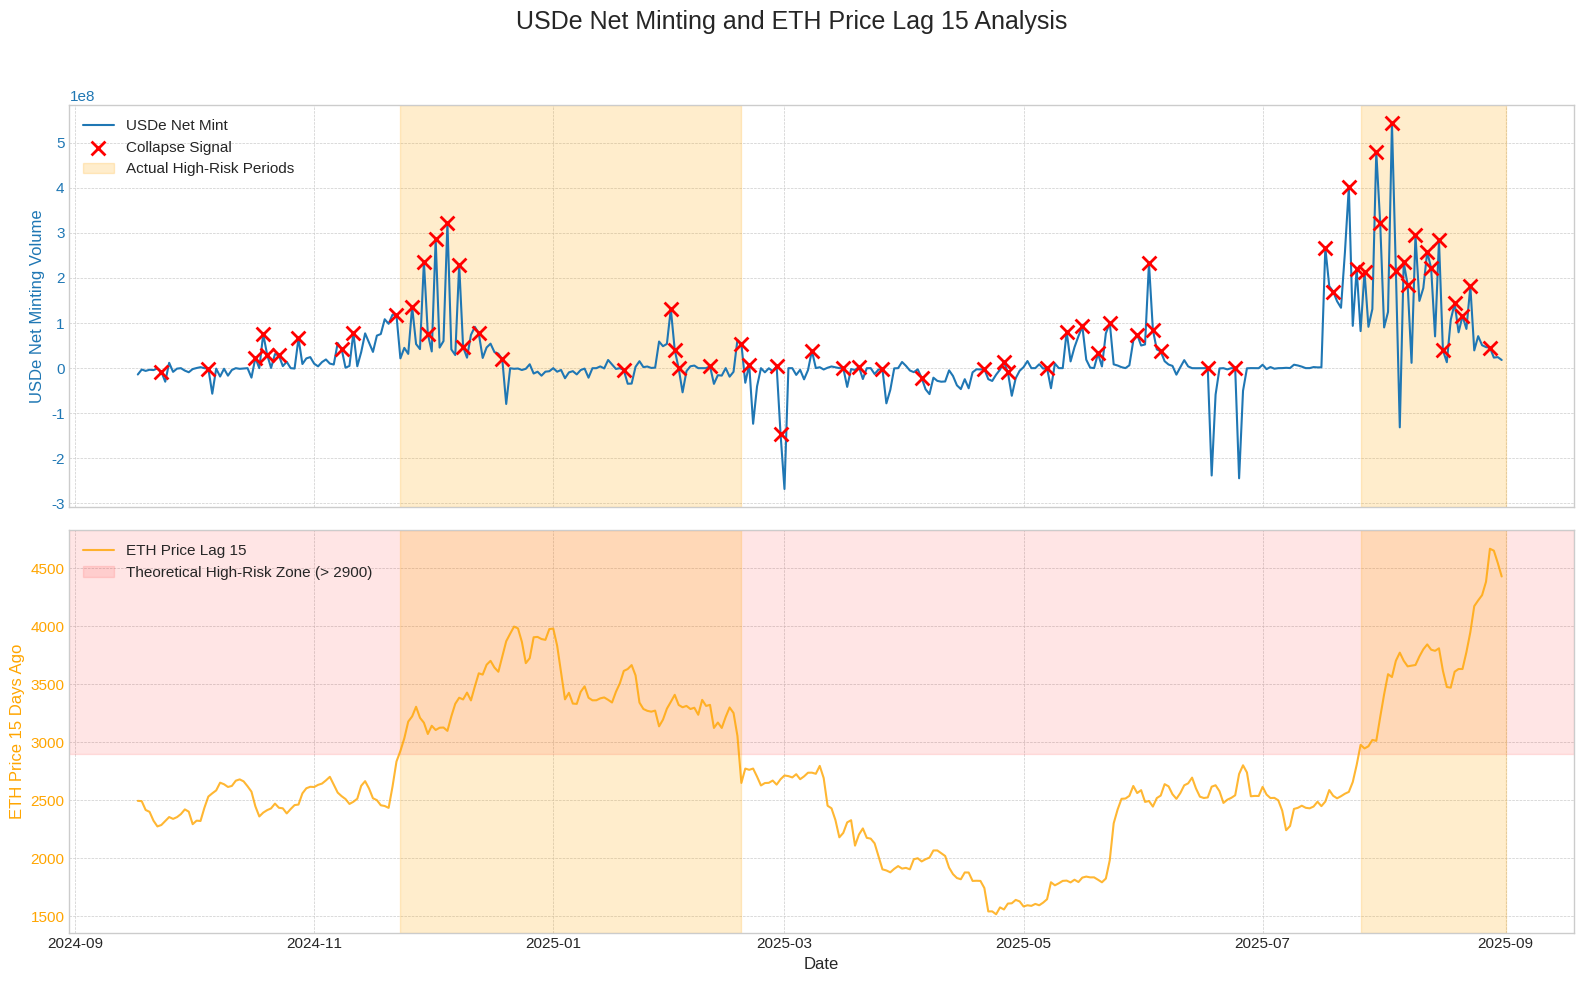

In [69]:
# 複製一份 DataFrame 以免影響其他圖表
df_plot = df.copy()

# 建立 2x1 的子圖
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharex=True)
fig.suptitle('USDe Net Minting and ETH Price Lag 15 Analysis', fontsize=18)

# 圖一 (上方): USDe 淨鑄造量
ax1.set_ylabel('USDe Net Minting Volume', color='tab:blue', fontsize=12)
ax1.plot(df_plot['date'], df_plot['USDe_NET_MINT'], label='USDe Net Mint', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在圖一標記 Collapse 事件
collapse_dates = df_plot[df_plot['mint_collapse_hard'] == 1]
if not collapse_dates.empty:
    ax1.scatter(collapse_dates['date'], collapse_dates['USDe_NET_MINT'], color='red', marker='x', s=100, linewidth=2, label='Collapse Signal', zorder=10)

# 圖二 (下方): ETH Price Lag 15
ax2.set_ylabel('ETH Price 15 Days Ago', color='orange', fontsize=12)
ax2.plot(df_plot['date'], df_plot['ETH_price_lag15'], label='ETH Price Lag 15', color='orange', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# 【核心修改】: 在圖二用水平區域標示出理論風險區 (不使用 np.inf)
ymin, ymax = ax2.get_ylim() # 先獲取 Y 軸的上下限
ax2.axhspan(2900, ymax, color='red', alpha=0.1, label='Theoretical High-Risk Zone (> 2900)')
ax2.set_ylim(ymin, ymax) # 重新設定 Y 軸上下限

# 找出連續的高風險日期區間，並在上下圖中用垂直色塊標示
df_plot['is_high_risk'] = (df_plot['ETH_price_lag15'] > 2900)
df_plot['risk_block'] = (df_plot['is_high_risk'].ne(df_plot['is_high_risk'].shift())).cumsum()
high_risk_periods = df_plot[df_plot['is_high_risk']]

if not high_risk_periods.empty:
    first_block = True
    for block_num, group in high_risk_periods.groupby('risk_block'):
        start_date = group['date'].min()
        end_date = group['date'].max() + timedelta(days=1)
        label = 'Actual High-Risk Periods' if first_block else None
        ax1.axvspan(start_date, end_date, color='orange', alpha=0.2, label=label)
        ax2.axvspan(start_date, end_date, color='orange', alpha=0.2)
        first_block = False

# 整理圖例與佈局
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
plt.xlabel('Date', fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 📉 USDe Net Minting vs BTC Price Gap (Lag 2) Analysis

This code visualizes **USDe net minting (USDe_NET_MINT)** alongside **BTC price deviation with a 2-day lag (BTC_price_gap_lag2)** in a dual-panel chart. It highlights both **theoretical risk thresholds** and **actual collapse events**.  

Steps:  

1. **2x1 subplot with shared X-axis:**  
   - Top chart (ax1): USDe net minting.  
   - Bottom chart (ax2): BTC price gap (Lag 2).  

2. **Collapse signals:**  
   - Rows where `mint_collapse_hard = 1` are treated as **extreme redemption events**.  
   - Marked as **red crosses (x)** in the top chart.  

3. **Theoretical risk zone:**  
   - When `BTC_price_gap_lag2 > 5000`, flagged as a potential high-risk zone.  
   - Shown as a **red horizontal band** in the bottom chart.  

4. **Actual high-risk periods:**  
   - Identify continuous ranges where `BTC_price_gap_lag2 > 5000`.  
   - Highlighted with **orange vertical spans** across both charts.  

5. **Chart formatting:**  
   - Includes legends, grids, and titles to improve readability.  

---

### 📊 Conclusion

- **When BTC price deviation (Lag 2) exceeds 5000, the market enters a potential high-risk zone.**  
- **Collapse events (red crosses) often cluster within or near the orange risk periods, suggesting BTC deviation can act as a supplementary early warning signal.**  
- Compared with ETH-based indicators, BTC deviations appear less decisive, functioning more as **secondary context rather than a core driver**.  


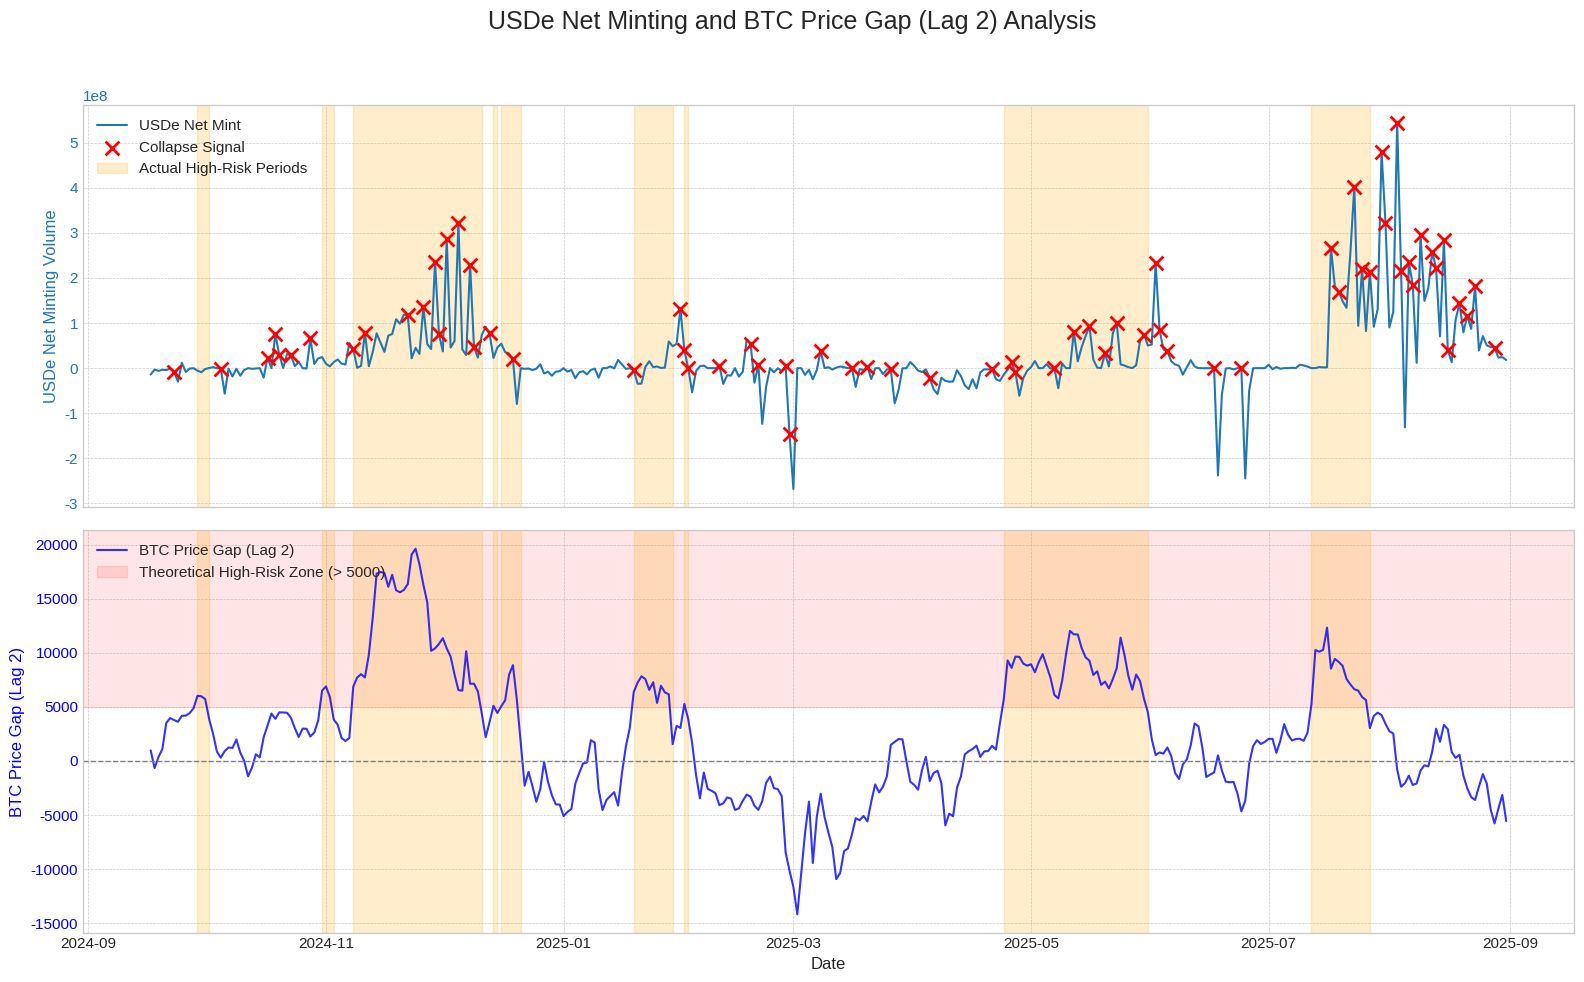

In [70]:
# 複製一份 DataFrame 以免影響其他圖表
df_plot = df.copy()

# 建立 2x1 的子圖
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharex=True)
fig.suptitle('USDe Net Minting and BTC Price Gap (Lag 2) Analysis', fontsize=18)

# 圖一 (上方): USDe 淨鑄造量
ax1.set_ylabel('USDe Net Minting Volume', color='tab:blue', fontsize=12)
ax1.plot(df_plot['date'], df_plot['USDe_NET_MINT'], label='USDe Net Mint', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在圖一標記 Collapse 事件
collapse_dates = df_plot[df_plot['mint_collapse_hard'] == 1]
if not collapse_dates.empty:
    ax1.scatter(collapse_dates['date'], collapse_dates['USDe_NET_MINT'], color='red', marker='x', s=100, linewidth=2, label='Collapse Signal', zorder=10)

# 圖二 (下方): BTC Price Gap (Lag 2)
ax2.set_ylabel('BTC Price Gap (Lag 2)', color='blue', fontsize=12)
ax2.plot(df_plot['date'], df_plot['BTC_price_gap_lag2'], label='BTC Price Gap (Lag 2)', color='blue', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

# 【核心修改】: 在圖二用水平區域標示出理論風險區 (不使用 np.inf)
ymin, ymax = ax2.get_ylim() # 先獲取 Y 軸的上下限
ax2.axhspan(5000, ymax, color='red', alpha=0.1, label='Theoretical High-Risk Zone (> 5000)')
ax2.set_ylim(ymin, ymax) # 重新設定 Y 軸上下限

# 找出連續的高風險日期區間，並在上下圖中用垂直色塊標示
df_plot['is_high_risk'] = (df_plot['BTC_price_gap_lag2'] > 5000)
df_plot['risk_block'] = (df_plot['is_high_risk'].ne(df_plot['is_high_risk'].shift())).cumsum()
high_risk_periods = df_plot[df_plot['is_high_risk']]

if not high_risk_periods.empty:
    first_block = True
    for block_num, group in high_risk_periods.groupby('risk_block'):
        start_date = group['date'].min()
        end_date = group['date'].max() + timedelta(days=1)
        label = 'Actual High-Risk Periods' if first_block else None
        ax1.axvspan(start_date, end_date, color='orange', alpha=0.2, label=label)
        ax2.axvspan(start_date, end_date, color='orange', alpha=0.2)
        first_block = False

# 整理圖例與佈局
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
plt.xlabel('Date', fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## ⚠️ USDe Collapse Early Warning System: Logistic Regression Visualization

This code demonstrates an **early warning system** for predicting **Extreme Redemption Events (`mint_collapse_hard`)** in USDe, using a **Logistic Regression model**.  

Steps:  

1. **Feature selection:**  
   The model uses four predictors:  
   - `ETH_price_gap`: ETH price deviation from the moving average  
   - `ETH_price_lag15`: ETH price 15 days ago  
   - `ETH_return_7d`: ETH 7-day return  
   - `BTC_price_gap_lag2`: BTC price deviation with 2-day lag  

2. **Model training & prediction:**  
   - Trained with `LogisticRegression` and `class_weight='balanced'` to handle class imbalance.  
   - Produces probabilities of collapse events.  
   - Applies a **0.40 probability threshold** to classify events (≥0.40 = predicted collapse).  

3. **Classification outcomes:**  
   - **True Positives:** Event occurred & predicted → **Red X**.  
   - **False Negatives:** Event occurred but missed → **Orange hollow circles**.  
   - **False Positives:** False alarm, predicted but didn’t occur → **Gray dots**.  

4. **Visualization:**  
   - Blue line: USDe net minting (background trend).  
   - Points highlight model performance.  
   - Title emphasizes: the system **predicted ~85% of collapse events correctly**.  

---

### 📊 Conclusion

- The model performs **well in capturing most collapse events (high recall)**.  
- **False alarms exist**, but they are acceptable since missing a true collapse carries higher risk.  
- ETH’s delayed effects and price deviations remain the **primary predictive signals**, while BTC deviations act as **secondary supplements**.  


In [71]:
df_plot = df.copy()

# --- 第一步：準備數據 ---
# 根據您的報告，定義模型的特徵 (X) 和目標 (y)
# 確保您的 df 中沒有缺失值 (NaN)，否則模型會報錯
features = [
    'ETH_price_gap',
    'ETH_price_lag15',
    'ETH_return_7d',
    'BTC_price_gap_lag2'
]
target = 'mint_collapse_hard'

# 處理任何可能存在的缺失值，例如用 0 填充
df_plot[features] = df_plot[features].fillna(0)
df_plot[target] = df_plot[target].fillna(0)

X = df_plot[features]
y = df_plot[target]


# --- 第二步：訓練模型並預測 ---
# 初始化邏輯回歸模型
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# 訓練模型
model.fit(X, y)

# 進行預測，得到屬於類別 1 (崩盤) 的機率
prediction_probabilities = model.predict_proba(X)[:, 1]

# 根據您報告中的 0.4 門檻，將機率轉換為 0 或 1 的最終預測
threshold = 0.40
binary_predictions = (prediction_probabilities >= threshold).astype(int)


# --- 第三步：將預測加回DataFrame ---
df_plot['model_prediction'] = binary_predictions

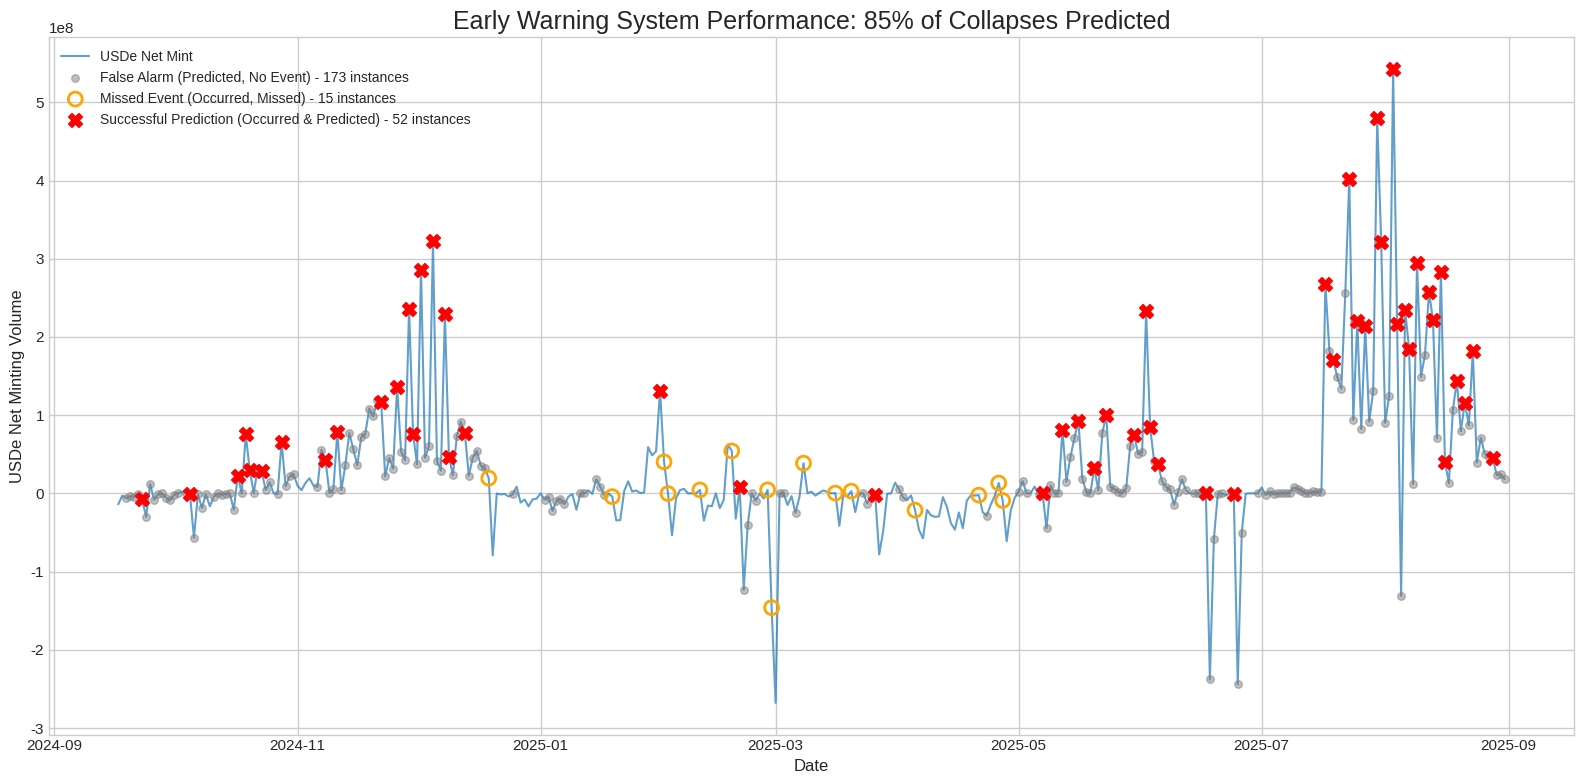

In [72]:
# ======================================================================
# --- 第四步：開始繪圖 (使用含有真實預測的 df) ---
# ----------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

# 1. 繪製背景：USDe Net Mint 折線圖
ax.plot(df_plot['date'], df_plot['USDe_NET_MINT'], label='USDe Net Mint', color='tab:blue', alpha=0.7, zorder=1)

# 2. 識別四種情況
true_positives = df_plot[(df_plot['mint_collapse_hard'] == 1) & (df_plot['model_prediction'] == 1)]
false_negatives = df_plot[(df_plot['mint_collapse_hard'] == 1) & (df_plot['model_prediction'] == 0)]
false_positives = df_plot[(df_plot['mint_collapse_hard'] == 0) & (df_plot['model_prediction'] == 1)]

# 3. 視覺化四種情況
# 虛驚一場 (模型預警了，但沒發生) - 灰色小點
ax.scatter(false_positives['date'], false_positives['USDe_NET_MINT'],
           color='gray', marker='o', s=30, alpha=0.5,
           label=f'False Alarm (Predicted, No Event) - {len(false_positives)} instances', zorder=2)

# 錯失預警 (發生了，但模型沒預警) - 紅色空心圓
ax.scatter(false_negatives['date'], false_negatives['USDe_NET_MINT'],
           edgecolor='orange', facecolor='none', marker='o', s=100, linewidth=2,
           label=f'Missed Event (Occurred, Missed) - {len(false_negatives)} instances', zorder=3)

# 成功預警 (發生了，模型也預警了) - 紅色 X
ax.scatter(true_positives['date'], true_positives['USDe_NET_MINT'],
           color='red', marker='X', s=100,
           label=f'Successful Prediction (Occurred & Predicted) - {len(true_positives)} instances', zorder=4)


# 圖表美化
ax.set_title('Early Warning System Performance: 85% of Collapses Predicted', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('USDe Net Minting Volume', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
fig.tight_layout()
plt.show()

# Conclusion and Future Outlook

## Summary of Findings
This study presents quantitative evidence confirming a significant relationship between external market momentum and USDe net capital flows. The analysis shows that a multi-factor model built on ETH_price_gap(short-term deviation), ETH_price_lag15(mid-term trend anchor), ETH_return_7d(short-term momentum), and BTC_price_gap(cross-market sentiment) can statistically explain meaningful portions of USDe behavior.

A central insight is that while the explanatory model shows limited power in capturing the noise of day-to-day flows (R² ≈ 44.8%), the classification-based early-warning model can achieve a Recall of up to 85% under high-sensitivity settings.

This suggests that while regular market activity may remain noisy and unpredictable, signals that precede extreme risk events are identifiable and structurally consistent.

Therefore, the more pragmatic path is not to build a model that explains everything, but rather to develop a tool that excels at detecting rare but high-impact risks.

This report aims to surface those insights objectively, and to serve as a foundation for broader conversations on dynamic risk management within the DAO ecosystem.



## Future Directions
This report marks a starting point. To evolve this PoC model into a production-ready governance tool, we highlight two promising areas for further exploration:

### 🧠 Dimension 1: Deepening Analytical Rigor

To strengthen the model’s robustness and interpretability, future research could explore:

- Integrating high-resolution market indicators:
Variables closer to market microstructure — such as ETH perpetual funding rates, on-chain arbitrage activity, and cross-chain capital flows, may significantly enhance the model’s sensitivity.

- Exploring more powerful predictive models:
Algorithms like XGBoost can better capture complex nonlinearities. Additionally, anomaly detection models such as Isolation Forest may help surface black-swan-type events.

- Changing data granularity:
Testing shorter time intervals (e.g., 15- or 30-minute bars) may uncover risk buildup patterns not visible in daily data.

### 🧠 Dimension 2: Expanding Governance Applications

The current findings invite broader community thinking around conceptual applications:

- From data to insight:
Can such models be deployed as public-facing market risk dashboards, giving ecosystem participants a transparent, shared reference point to improve collective awareness?
- From independence to integration:
What synergies exist between externally driven warning signals and protocol-native safety mechanisms (e.g., capital buffers, redemption throttles)?
- From case-specific to framework-level:
In the long term, how might DAO governance institutionalize dynamic trigger-based risk assessments as part of a standardized decision framework — especially in an increasingly complex market landscape?

# 🌀 An Open Thought on Reflexivity
A final, deeper question:

> ***If early-warning tools become widely adopted, will their predictive power decline due to reflexivity?***

We argue that this is precisely the intended outcome.

If a public “storm warning” leads all ships to return to harbor — thus invalidating the prediction of a shipwreck — then the system has achieved maximum success.

Likewise, the long-term value of early-warning models may not lie in maintaining prediction accuracy, but in enhancing transparency and shaping a more resilient, self-regulating ecosystem.

#References：

[Strengthening Stability Between Aave and Ethena: Redemption Priority and Protocol Safeguards — Risk — Aave](https://governance.aave.com/t/strengthening-stability-between-aave-and-ethena-redemption-priority-and-protocol-safeguards/23027)

[Deconstructing the Aave & Ethena Risk Report: A Case Study in DeFi Systemic Risk and Governance](https://medium.com/@abcd334/deconstructing-the-aave-ethena-risk-report-a-case-study-in-defi-systemic-risk-and-governance-47f132e528a4)

[Dune Dashboard: USDe Collapse Risk Monitor](https://dune.com/haysen/usde-collapse-risk)

# Disclaimer

- Independence Statement:
This analysis represents an independent research effort. It was not sponsored, commissioned, or endorsed by Aave, Ethena, or any affiliated entity.

- Not Investment Advice:
All content, data, and model outputs presented in this report are intended solely for academic exploration and governance discussion. Nothing herein should be construed as financial advice or as a basis for automated execution.

- Governance Prerequisite:
Any potential application of the models described in this report must undergo Aave DAO’s full governance process — including deliberation, debate, and collective consensus. This report should not be interpreted as a directly executable proposal.

# Report Metadata

- PoC Version: v0.1
- Date Published: September, 2025
- Author/Connect: [haysen.lin (independent researcher) on LinkedIn](https://www.linkedin.com/in/haysenlin/)
- Affiliation: This is an independent analysis. No affiliation with Aave, Ethena, or any related entity.
- License: CC BY 4.0 — open for discussion, adaptation, and contribution.